# Drug interaction prediction in *E. coli*
*Author: Vladislav Kim*
* [Introduction](#intro)
* [Compound class stratified validation](#classlockout)
* [Choose thresholds for interactions](#threshclass)
* [Precision-recall and ROC curves](#pr)
* [Probability calibration](#calib)
* [Predictions on the test set](#test)

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import os
import itertools
from sklearn.preprocessing import label_binarize

sys.path.append('..')
import base.chemgen_utils as utl
import MLmod.predictor_modified as prd

In /Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was depreca

<a id="intro"></a> 
## Introduction
It has been previously shown that drug interactions can be predicted in bacteria using chemogenomic data. Here we use random forest classifier on single-compound chemical genetics data in *E. coli* to predict antagonisms, synergies and additive combinations. 

We encode our input predictor matrix as follows: 
+ For each combination load single-compound profiles. Each profile has dimensions `(1 x genes)` and the following possible gene states {-1,0,+1}. Negative drug-gene interaction (-1) implies increased sensitivity in that gene deletion, while positive gene state (+1) indicates decreased sensitivity in that mutant
+ Combination profiles are generaeted based on superposition of individual drug profiles and may take on the following gene states {-2, -1, 0, +1, +2, +/-}
+ We then use one-hot encoding scheme ("dummy variable encoding") before passing the predictor matrix `X` to the classifier

We furthermore subset the data so that only those genes are included that are significantly enriched in antagonisms and synergies based on chi-squared test. This gene list is `interaction-genes-Ecoli`

In [2]:
drugleg_fname = "../data/chemicals/legend_gramnegpos.txt"
gene_subset = '../data/interaction-genes-Ecoli'
gene_subset = pd.read_csv(gene_subset, header=None)[0].values

In [3]:
X_chemgen = pd.read_csv('../data/chemgenetics/nichols_signed.csv', index_col=0)
X_chemgen = X_chemgen.iloc[:,np.where(np.isin(X_chemgen.columns, gene_subset))[0]]
targets = pd.read_csv("../data/chemgenetics/nichols_y.csv")
combs = targets['comb'].values
y = targets['type'].values

X_df = pd.DataFrame([utl.get_comb_feat_signed(X_chemgen, c) for c in combs])

Since we are using `OneVsRestClassifier`, we convert our categorical response variable `y` ("synergy" ,"antagonism", "none") into a `n x 3` binary array using `label_binarize` function

In [4]:
# one vs rest classification
y[y=='none'] = 0
y[y=='antagonism']=1
y[y=='synergy']=2

y=y.astype('int')
y = label_binarize(y, classes=[0, 1, 2])

Encode combination profiles using one-hot encoding scheme:

In [5]:
X_onehot = pd.get_dummies(X_df.astype('category'))

In [6]:
X_onehot.iloc[:6,:12]

,ACRA_-2,ACRA_-1,ACRA_0,ACRA_1,ACRA_2,ACRA_3,ACRB_-2,ACRB_-1,ACRB_0,ACRB_1,ACRB_2,ACRB_3
0,0,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,1,0,0


In [7]:
# at least 5 combinations with that variable set
X_onehot = X_onehot.loc[:,(X_onehot.sum(axis=0) > 4)]

We performed grid search to find the best parameters for the `RandomForestClassifier`:

In [8]:
# best parameters when sorted by meanAP_syn, meanAP_antag
#param_dict = {'n_estimators': 200,
# 'min_samples_split': 6,
# 'min_samples_leaf': 2,
# 'max_depth': None,
# 'class_weight': {0: 1, 1: 1}}

In [9]:
# best parameters neural network
param_dict = {'layers': 3,
'dropout': 0.2,
'epochs': 200,
'steps': 32,
'learning_rate_deep': 0.001,
'nodes': 32,
'class_weight': None}

<a id="classlockout"></a> 
## Cross Validation
In order to assess the generalization error we generate 20 cross-validation folds by withholding 15 randomly chosen compounds.

In [10]:
'''from sklearn.model_selection import KFold, RepeatedKFold

kf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1401)
splits = kf.split(X=X_onehot.to_numpy(),y=y)'''

'from sklearn.model_selection import KFold, RepeatedKFold\n\nkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1401)\nsplits = kf.split(X=X_onehot.to_numpy(),y=y)'

In [11]:
def generate_train_val(drugs, combs, n_holdout=15):
    val_drugs = np.random.choice(drugs, size=n_holdout)
    
    combs_val = list(itertools.combinations(val_drugs, 2))
    combs_val = [sorted(i) for i in combs_val]
    combs_val = np.array([i[0]+"_"+i[1] for i in combs_val])
    combs_val = np.intersect1d(combs_val, combs)
    combs_train = np.setdiff1d(combs, combs_val)
    
    assert((combs_train.shape[0] + combs_val.shape[0]) == combs.shape[0])
    train = np.where(np.isin(combs, combs_train))[0]
    val = np.where(np.isin(combs, combs_val))[0]
    return (train, val)

In [12]:
np.random.seed(1601)
# drugs in the chemical genetics dataset of E. coli
drugs = np.unique(X_chemgen.index)
# generate CV folds by withholding 15 randomly chosen drugs
splits = [generate_train_val(drugs, combs) for i in range(20)]

In each cross-validation iteration we withhold a random subset of drugs $(n=15)$ and test the trained model on the withheld combinations:

In [13]:
pr = prd.MultiClassPredictions(X=X_onehot.to_numpy(), y=y,
                                   combs=combs,
                                  **param_dict,
                                   clf='neural_network',
                                   top = 30)

In [14]:
pr.crossval_ksplit(splits=splits)

Validation set size in CV fold 1: 102
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.8087 - accuracy: 0.6153
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6508 - accuracy: 0.6621
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6256 - accuracy: 0.6806
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6412 - accuracy: 0.6411
Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5497 - accuracy: 0.7404
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5425 - accuracy: 0.7415
Epoch 7/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5041 - accuracy: 0.7230
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5648 - accuracy: 0.7329
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4762 - accuracy: 0.7728
Epoch 10/200
32/32 [==============================] - 0s 1ms/step - los

32/32 [==============================] - 0s 1ms/step - loss: 0.1102 - accuracy: 0.9451
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1132 - accuracy: 0.9445
Epoch 84/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0916 - accuracy: 0.9614
Epoch 85/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1060 - accuracy: 0.9578
Epoch 86/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1126 - accuracy: 0.9571
Epoch 87/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1084 - accuracy: 0.9551
Epoch 88/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1102 - accuracy: 0.9626
Epoch 89/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1029 - accuracy: 0.9474
Epoch 90/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0695 - accuracy: 0.9703
Epoch 91/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0795 - accuracy: 0.9722
Epoch 92/200


32/32 [==============================] - 0s 1ms/step - loss: 0.0536 - accuracy: 0.9820
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.9611
Epoch 164/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0477 - accuracy: 0.9783
Epoch 165/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.9745
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0591 - accuracy: 0.9750
Epoch 167/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.9711
Epoch 168/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9569
Epoch 169/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0958 - accuracy: 0.9364
Epoch 170/200
32/32 [==============================] - 0s 975us/step - loss: 0.1063 - accuracy: 0.9512
Epoch 171/200
32/32 [==============================] - 0s 995us/step - loss: 0.0554 - accuracy: 0.9774


Epoch 43/200
32/32 [==============================] - 0s 909us/step - loss: 0.1200 - accuracy: 0.9540
Epoch 44/200
32/32 [==============================] - 0s 944us/step - loss: 0.1031 - accuracy: 0.9532
Epoch 45/200
32/32 [==============================] - 0s 906us/step - loss: 0.0962 - accuracy: 0.9659
Epoch 46/200
32/32 [==============================] - 0s 904us/step - loss: 0.1040 - accuracy: 0.9515
Epoch 47/200
32/32 [==============================] - 0s 881us/step - loss: 0.0780 - accuracy: 0.9724
Epoch 48/200
32/32 [==============================] - 0s 907us/step - loss: 0.1321 - accuracy: 0.9420
Epoch 49/200
32/32 [==============================] - 0s 889us/step - loss: 0.1233 - accuracy: 0.9431
Epoch 50/200
32/32 [==============================] - 0s 905us/step - loss: 0.0970 - accuracy: 0.9637
Epoch 51/200
32/32 [==============================] - 0s 904us/step - loss: 0.0941 - accuracy: 0.9673
Epoch 52/200
32/32 [==============================] - 0s 926us/step - loss: 0.1143

32/32 [==============================] - 0s 867us/step - loss: 0.0392 - accuracy: 0.9847
Epoch 124/200
32/32 [==============================] - 0s 844us/step - loss: 0.0431 - accuracy: 0.9844
Epoch 125/200
32/32 [==============================] - 0s 874us/step - loss: 0.0403 - accuracy: 0.9901
Epoch 126/200
32/32 [==============================] - 0s 868us/step - loss: 0.0284 - accuracy: 0.9895
Epoch 127/200
32/32 [==============================] - 0s 906us/step - loss: 0.0331 - accuracy: 0.9847
Epoch 128/200
32/32 [==============================] - 0s 861us/step - loss: 0.0770 - accuracy: 0.9682
Epoch 129/200
32/32 [==============================] - 0s 868us/step - loss: 0.0804 - accuracy: 0.9635
Epoch 130/200
32/32 [==============================] - 0s 874us/step - loss: 0.0398 - accuracy: 0.9881
Epoch 131/200
32/32 [==============================] - 0s 895us/step - loss: 0.0577 - accuracy: 0.9769
Epoch 132/200
32/32 [==============================] - 0s 904us/step - loss: 0.0692 - a

32/32 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.8674
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3954 - accuracy: 0.8692
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4186 - accuracy: 0.8574
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.4105 - accuracy: 0.8650
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3592 - accuracy: 0.8708
Epoch 7/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3670 - accuracy: 0.8677
Epoch 8/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8567
Epoch 9/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3528 - accuracy: 0.8648
Epoch 10/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3222 - accuracy: 0.8663
Epoch 11/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3368 - accuracy: 0.8648
Epoch 12/200
32/32 [

32/32 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9652
Epoch 84/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0618 - accuracy: 0.9808
Epoch 85/200
32/32 [==============================] - 0s 992us/step - loss: 0.0609 - accuracy: 0.9781
Epoch 86/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0519 - accuracy: 0.9772
Epoch 87/200
32/32 [==============================] - 0s 950us/step - loss: 0.0496 - accuracy: 0.9802
Epoch 88/200
32/32 [==============================] - 0s 945us/step - loss: 0.0427 - accuracy: 0.9849
Epoch 89/200
32/32 [==============================] - 0s 938us/step - loss: 0.0856 - accuracy: 0.9665
Epoch 90/200
32/32 [==============================] - 0s 952us/step - loss: 0.0879 - accuracy: 0.9693
Epoch 91/200
32/32 [==============================] - 0s 959us/step - loss: 0.0880 - accuracy: 0.9591
Epoch 92/200
32/32 [==============================] - 0s 957us/step - loss: 0.0693 - accuracy: 0.9708

32/32 [==============================] - 0s 987us/step - loss: 0.0112 - accuracy: 0.9982
Epoch 164/200
32/32 [==============================] - 0s 947us/step - loss: 0.0194 - accuracy: 0.9923
Epoch 165/200
32/32 [==============================] - 0s 973us/step - loss: 0.0234 - accuracy: 0.9917
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0257 - accuracy: 0.9926
Epoch 167/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0437 - accuracy: 0.9814
Epoch 168/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0252 - accuracy: 0.9906
Epoch 169/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0467 - accuracy: 0.9821
Epoch 170/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0357 - accuracy: 0.9888
Epoch 171/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.9757
Epoch 172/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.991

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 2: 65
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.8619 - accuracy: 0.5860
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6993 - accuracy: 0.6662
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6276 - accuracy: 0.7360
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6201 - accuracy: 0.7072
Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5887 - accuracy: 0.7210
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5910 - accuracy: 0.7066
Epoch 7/200
32/32 [==============================] - 0s 996us/step - loss: 0.5434 - accuracy: 0.7367
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5473 - accuracy: 0.7229
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5333 - accuracy: 0.7197
Epoch 10/200
32/32 [==============================] - 0s 1ms/step - lo

32/32 [==============================] - 0s 1ms/step - loss: 0.1284 - accuracy: 0.9492
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1164 - accuracy: 0.9535
Epoch 84/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1446 - accuracy: 0.9340
Epoch 85/200
32/32 [==============================] - 0s 978us/step - loss: 0.1423 - accuracy: 0.9332
Epoch 86/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9553
Epoch 87/200
32/32 [==============================] - 0s 999us/step - loss: 0.1124 - accuracy: 0.9554
Epoch 88/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1188 - accuracy: 0.9606
Epoch 89/200
32/32 [==============================] - 0s 988us/step - loss: 0.1595 - accuracy: 0.9317
Epoch 90/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1172 - accuracy: 0.9546
Epoch 91/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1565 - accuracy: 0.9338
Epoch 9

32/32 [==============================] - 0s 971us/step - loss: 0.0736 - accuracy: 0.9739
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.9729
Epoch 164/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0699 - accuracy: 0.9729
Epoch 165/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0947 - accuracy: 0.9606
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0820 - accuracy: 0.9671
Epoch 167/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.9662
Epoch 168/200
32/32 [==============================] - 0s 982us/step - loss: 0.1523 - accuracy: 0.9394
Epoch 169/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9642
Epoch 170/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0718 - accuracy: 0.9670
Epoch 171/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1019 - accuracy: 0.9563


32/32 [==============================] - 0s 1ms/step - loss: 0.1533 - accuracy: 0.9291
Epoch 44/200
32/32 [==============================] - 0s 988us/step - loss: 0.1430 - accuracy: 0.9330
Epoch 45/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0994 - accuracy: 0.9649
Epoch 46/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1206 - accuracy: 0.9414
Epoch 47/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0954 - accuracy: 0.9560
Epoch 48/200
32/32 [==============================] - 0s 989us/step - loss: 0.0751 - accuracy: 0.9711
Epoch 49/200
32/32 [==============================] - 0s 980us/step - loss: 0.1132 - accuracy: 0.9539
Epoch 50/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0884 - accuracy: 0.9624
Epoch 51/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0892 - accuracy: 0.9594
Epoch 52/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0962 - accuracy: 0.9600
Epoch 5

32/32 [==============================] - 0s 997us/step - loss: 0.0649 - accuracy: 0.9761
Epoch 125/200
32/32 [==============================] - 0s 999us/step - loss: 0.0401 - accuracy: 0.9856
Epoch 126/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0836 - accuracy: 0.9737
Epoch 127/200
32/32 [==============================] - 0s 984us/step - loss: 0.0565 - accuracy: 0.9805
Epoch 128/200
32/32 [==============================] - 0s 986us/step - loss: 0.0428 - accuracy: 0.9793
Epoch 129/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0411 - accuracy: 0.9870
Epoch 130/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0534 - accuracy: 0.9822
Epoch 131/200
32/32 [==============================] - 0s 974us/step - loss: 0.0602 - accuracy: 0.9812
Epoch 132/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9812
Epoch 133/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0364 - accuracy: 0

Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3694 - accuracy: 0.8819
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3233 - accuracy: 0.9013
Epoch 7/200
32/32 [==============================] - 0s 991us/step - loss: 0.3647 - accuracy: 0.8692
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3393 - accuracy: 0.8733
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3512 - accuracy: 0.8722
Epoch 10/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3387 - accuracy: 0.8692
Epoch 11/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3250 - accuracy: 0.8737
Epoch 12/200
32/32 [==============================] - 0s 992us/step - loss: 0.3612 - accuracy: 0.8665
Epoch 13/200
32/32 [==============================] - 0s 981us/step - loss: 0.3037 - accuracy: 0.8724
Epoch 14/200
32/32 [==============================] - 0s 960us/step - loss: 0.3037 - accuracy: 0.88

32/32 [==============================] - 0s 1ms/step - loss: 0.0514 - accuracy: 0.9819
Epoch 87/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0410 - accuracy: 0.9809
Epoch 88/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.9914
Epoch 89/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0423 - accuracy: 0.9826
Epoch 90/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9832
Epoch 91/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0614 - accuracy: 0.9755
Epoch 92/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.9797
Epoch 93/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0456 - accuracy: 0.9835
Epoch 94/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0535 - accuracy: 0.9845
Epoch 95/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0570 - accuracy: 0.9844
Epoch 96/200


32/32 [==============================] - 0s 1ms/step - loss: 0.0266 - accuracy: 0.9922
Epoch 168/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0346 - accuracy: 0.9897
Epoch 169/200
32/32 [==============================] - 0s 998us/step - loss: 0.0283 - accuracy: 0.9901
Epoch 170/200
32/32 [==============================] - 0s 936us/step - loss: 0.0427 - accuracy: 0.9819
Epoch 171/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9881
Epoch 172/200
32/32 [==============================] - 0s 985us/step - loss: 0.0142 - accuracy: 0.9951
Epoch 173/200
32/32 [==============================] - 0s 968us/step - loss: 0.0288 - accuracy: 0.9909
Epoch 174/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0232 - accuracy: 0.9920
Epoch 175/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0126 - accuracy: 0.9964
Epoch 176/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0509 - accuracy: 0.9

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 3: 91
Epoch 1/200
32/32 [==============================] - 0s 879us/step - loss: 0.8750 - accuracy: 0.6126
Epoch 2/200
32/32 [==============================] - 0s 983us/step - loss: 0.6500 - accuracy: 0.7000
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6281 - accuracy: 0.6751
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6148 - accuracy: 0.6861
Epoch 5/200
32/32 [==============================] - 0s 972us/step - loss: 0.5744 - accuracy: 0.7266
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5345 - accuracy: 0.7353
Epoch 7/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5410 - accuracy: 0.7429
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5184 - accuracy: 0.7466
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5202 - accuracy: 0.7574
Epoch 10/200
32/32 [==============================] - 0s 1ms/step 

32/32 [==============================] - 0s 866us/step - loss: 0.1520 - accuracy: 0.9433
Epoch 82/200
32/32 [==============================] - 0s 899us/step - loss: 0.1423 - accuracy: 0.9332
Epoch 83/200
32/32 [==============================] - 0s 950us/step - loss: 0.1097 - accuracy: 0.9628
Epoch 84/200
32/32 [==============================] - 0s 915us/step - loss: 0.1895 - accuracy: 0.9150
Epoch 85/200
32/32 [==============================] - 0s 986us/step - loss: 0.1736 - accuracy: 0.9296
Epoch 86/200
32/32 [==============================] - 0s 942us/step - loss: 0.1545 - accuracy: 0.9245
Epoch 87/200
32/32 [==============================] - 0s 918us/step - loss: 0.1159 - accuracy: 0.9546
Epoch 88/200
32/32 [==============================] - 0s 902us/step - loss: 0.1664 - accuracy: 0.9330
Epoch 89/200
32/32 [==============================] - 0s 949us/step - loss: 0.1347 - accuracy: 0.9341
Epoch 90/200
32/32 [==============================] - 0s 970us/step - loss: 0.1209 - accuracy: 

32/32 [==============================] - 0s 838us/step - loss: 0.0936 - accuracy: 0.9553
Epoch 161/200
32/32 [==============================] - 0s 872us/step - loss: 0.1614 - accuracy: 0.9291
Epoch 162/200
32/32 [==============================] - 0s 944us/step - loss: 0.0940 - accuracy: 0.9504
Epoch 163/200
32/32 [==============================] - 0s 897us/step - loss: 0.1036 - accuracy: 0.9429
Epoch 164/200
32/32 [==============================] - 0s 958us/step - loss: 0.1166 - accuracy: 0.9400
Epoch 165/200
32/32 [==============================] - 0s 919us/step - loss: 0.1322 - accuracy: 0.9204
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1083 - accuracy: 0.9361
Epoch 167/200
32/32 [==============================] - 0s 956us/step - loss: 0.1215 - accuracy: 0.9386
Epoch 168/200
32/32 [==============================] - 0s 967us/step - loss: 0.1140 - accuracy: 0.9429
Epoch 169/200
32/32 [==============================] - 0s 942us/step - loss: 0.1001 - acc

32/32 [==============================] - 0s 888us/step - loss: 0.1282 - accuracy: 0.9525
Epoch 41/200
32/32 [==============================] - 0s 877us/step - loss: 0.1012 - accuracy: 0.9663
Epoch 42/200
32/32 [==============================] - 0s 953us/step - loss: 0.1122 - accuracy: 0.9613
Epoch 43/200
32/32 [==============================] - 0s 967us/step - loss: 0.1245 - accuracy: 0.9483
Epoch 44/200
32/32 [==============================] - 0s 933us/step - loss: 0.1016 - accuracy: 0.9537
Epoch 45/200
32/32 [==============================] - 0s 948us/step - loss: 0.1024 - accuracy: 0.9652
Epoch 46/200
32/32 [==============================] - 0s 920us/step - loss: 0.1040 - accuracy: 0.9618
Epoch 47/200
32/32 [==============================] - 0s 924us/step - loss: 0.0787 - accuracy: 0.9761
Epoch 48/200
32/32 [==============================] - 0s 920us/step - loss: 0.0892 - accuracy: 0.9683
Epoch 49/200
32/32 [==============================] - 0s 941us/step - loss: 0.0855 - accuracy: 

32/32 [==============================] - 0s 861us/step - loss: 0.0503 - accuracy: 0.9814
Epoch 121/200
32/32 [==============================] - 0s 858us/step - loss: 0.0585 - accuracy: 0.9785
Epoch 122/200
32/32 [==============================] - 0s 865us/step - loss: 0.0384 - accuracy: 0.9877
Epoch 123/200
32/32 [==============================] - 0s 956us/step - loss: 0.0223 - accuracy: 0.9932
Epoch 124/200
32/32 [==============================] - 0s 913us/step - loss: 0.0673 - accuracy: 0.9751
Epoch 125/200
32/32 [==============================] - 0s 947us/step - loss: 0.1062 - accuracy: 0.9619
Epoch 126/200
32/32 [==============================] - 0s 917us/step - loss: 0.0532 - accuracy: 0.9798
Epoch 127/200
32/32 [==============================] - 0s 901us/step - loss: 0.0314 - accuracy: 0.9901
Epoch 128/200
32/32 [==============================] - 0s 906us/step - loss: 0.0259 - accuracy: 0.9943
Epoch 129/200
32/32 [==============================] - 0s 939us/step - loss: 0.0293 - a

32/32 [==============================] - 0s 945us/step - loss: 0.0730 - accuracy: 0.9673
Epoch 200/200
32/32 [==============================] - 0s 976us/step - loss: 0.0822 - accuracy: 0.9592
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6422 - accuracy: 0.7775
Epoch 2/200
32/32 [==============================] - 0s 896us/step - loss: 0.3837 - accuracy: 0.8827
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4108 - accuracy: 0.8646
Epoch 4/200
32/32 [==============================] - 0s 951us/step - loss: 0.3394 - accuracy: 0.8935
Epoch 5/200
32/32 [==============================] - 0s 979us/step - loss: 0.3560 - accuracy: 0.9003
Epoch 6/200
32/32 [==============================] - 0s 950us/step - loss: 0.3734 - accuracy: 0.8698
Epoch 7/200
32/32 [==============================] - 0s 927us/step - loss: 0.3238 - accuracy: 0.8884
Epoch 8/200
32/32 [==============================] - 0s 913us/step - loss: 0.3513 - accuracy: 0.8716
Epoc

32/32 [==============================] - 0s 862us/step - loss: 0.0635 - accuracy: 0.9793
Epoch 80/200
32/32 [==============================] - 0s 852us/step - loss: 0.1070 - accuracy: 0.9608
Epoch 81/200
32/32 [==============================] - 0s 877us/step - loss: 0.0785 - accuracy: 0.9753
Epoch 82/200
32/32 [==============================] - 0s 950us/step - loss: 0.0711 - accuracy: 0.9753
Epoch 83/200
32/32 [==============================] - 0s 899us/step - loss: 0.0703 - accuracy: 0.9692
Epoch 84/200
32/32 [==============================] - 0s 909us/step - loss: 0.0561 - accuracy: 0.9829
Epoch 85/200
32/32 [==============================] - 0s 995us/step - loss: 0.0861 - accuracy: 0.9655
Epoch 86/200
32/32 [==============================] - 0s 989us/step - loss: 0.0923 - accuracy: 0.9673
Epoch 87/200
32/32 [==============================] - 0s 942us/step - loss: 0.0881 - accuracy: 0.9654
Epoch 88/200
32/32 [==============================] - 0s 884us/step - loss: 0.0721 - accuracy: 

32/32 [==============================] - 0s 973us/step - loss: 0.0621 - accuracy: 0.9771
Epoch 159/200
32/32 [==============================] - 0s 948us/step - loss: 0.0880 - accuracy: 0.9620
Epoch 160/200
32/32 [==============================] - 0s 975us/step - loss: 0.0499 - accuracy: 0.9781
Epoch 161/200
32/32 [==============================] - 0s 956us/step - loss: 0.0623 - accuracy: 0.9726
Epoch 162/200
32/32 [==============================] - 0s 921us/step - loss: 0.0478 - accuracy: 0.9858
Epoch 163/200
32/32 [==============================] - 0s 918us/step - loss: 0.0607 - accuracy: 0.9805
Epoch 164/200
32/32 [==============================] - 0s 941us/step - loss: 0.0537 - accuracy: 0.9798
Epoch 165/200
32/32 [==============================] - 0s 979us/step - loss: 0.0287 - accuracy: 0.9948
Epoch 166/200
32/32 [==============================] - 0s 921us/step - loss: 0.0524 - accuracy: 0.9852
Epoch 167/200
32/32 [==============================] - 0s 937us/step - loss: 0.0485 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/200
32/32 [==============================] - 0s 952us/step - loss: 0.7778 - accuracy: 0.6595
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6092 - accuracy: 0.7196
Epoch 3/200
32/32 [==============================] - 0s 981us/step - loss: 0.5814 - accuracy: 0.7081
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5490 - accuracy: 0.7418
Epoch 5/200
32/32 [==============================] - 0s 955us/step - loss: 0.5130 - accuracy: 0.7466
Epoch 6/200
32/32 [==============================] - 0s 977us/step - loss: 0.5188 - accuracy: 0.7495
Epoch 7/200
32/32 [==============================] - 0s 960us/step - loss: 0.5025 - accuracy: 0.7603
Epoch 8/200
32/32 [==============================] - 0s 942us/step - loss: 0.5137 - accuracy: 0.7450
Epoch 9/200
32/32 [==============================] - 0s 977us/step - loss: 0.5056 - accuracy: 0.7423
Epoch 10/200
32/32 [==============================] - 0s 961us/step - loss: 0.4680 - accuracy: 

32/32 [==============================] - 0s 874us/step - loss: 0.1467 - accuracy: 0.9468
Epoch 82/200
32/32 [==============================] - 0s 886us/step - loss: 0.1141 - accuracy: 0.9516
Epoch 83/200
32/32 [==============================] - 0s 957us/step - loss: 0.1423 - accuracy: 0.9468
Epoch 84/200
32/32 [==============================] - 0s 941us/step - loss: 0.1556 - accuracy: 0.9225
Epoch 85/200
32/32 [==============================] - 0s 948us/step - loss: 0.1176 - accuracy: 0.9524
Epoch 86/200
32/32 [==============================] - 0s 957us/step - loss: 0.1239 - accuracy: 0.9523
Epoch 87/200
32/32 [==============================] - 0s 972us/step - loss: 0.1286 - accuracy: 0.9326
Epoch 88/200
32/32 [==============================] - 0s 927us/step - loss: 0.1235 - accuracy: 0.9434
Epoch 89/200
32/32 [==============================] - 0s 946us/step - loss: 0.1505 - accuracy: 0.9341
Epoch 90/200
32/32 [==============================] - 0s 932us/step - loss: 0.1417 - accuracy: 

32/32 [==============================] - 0s 940us/step - loss: 0.0879 - accuracy: 0.9664
Epoch 161/200
32/32 [==============================] - 0s 895us/step - loss: 0.0655 - accuracy: 0.9727
Epoch 162/200
32/32 [==============================] - 0s 958us/step - loss: 0.0814 - accuracy: 0.9743
Epoch 163/200
32/32 [==============================] - 0s 908us/step - loss: 0.0561 - accuracy: 0.9770
Epoch 164/200
32/32 [==============================] - 0s 942us/step - loss: 0.0578 - accuracy: 0.9852
Epoch 165/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0985 - accuracy: 0.9653
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0715 - accuracy: 0.9733
Epoch 167/200
32/32 [==============================] - 0s 984us/step - loss: 0.0751 - accuracy: 0.9643
Epoch 168/200
32/32 [==============================] - 0s 975us/step - loss: 0.0788 - accuracy: 0.9658
Epoch 169/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0926 - accurac

32/32 [==============================] - 0s 966us/step - loss: 0.1392 - accuracy: 0.9429
Epoch 41/200
32/32 [==============================] - 0s 946us/step - loss: 0.1043 - accuracy: 0.9683
Epoch 42/200
32/32 [==============================] - 0s 968us/step - loss: 0.1450 - accuracy: 0.9299
Epoch 43/200
32/32 [==============================] - 0s 903us/step - loss: 0.1456 - accuracy: 0.9366
Epoch 44/200
32/32 [==============================] - 0s 887us/step - loss: 0.1263 - accuracy: 0.9410
Epoch 45/200
32/32 [==============================] - 0s 979us/step - loss: 0.1043 - accuracy: 0.9554
Epoch 46/200
32/32 [==============================] - 0s 974us/step - loss: 0.1136 - accuracy: 0.9548
Epoch 47/200
32/32 [==============================] - 0s 971us/step - loss: 0.1208 - accuracy: 0.9462
Epoch 48/200
32/32 [==============================] - 0s 996us/step - loss: 0.1185 - accuracy: 0.9519
Epoch 49/200
32/32 [==============================] - 0s 964us/step - loss: 0.1279 - accuracy: 

32/32 [==============================] - 0s 1ms/step - loss: 0.0363 - accuracy: 0.9908
Epoch 121/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0547 - accuracy: 0.9851
Epoch 122/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0296 - accuracy: 0.9916
Epoch 123/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0297 - accuracy: 0.9881
Epoch 124/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0956 - accuracy: 0.9631
Epoch 125/200
32/32 [==============================] - 0s 967us/step - loss: 0.0511 - accuracy: 0.9838
Epoch 126/200
32/32 [==============================] - 0s 990us/step - loss: 0.0463 - accuracy: 0.9857
Epoch 127/200
32/32 [==============================] - 0s 945us/step - loss: 0.0447 - accuracy: 0.9883
Epoch 128/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0438 - accuracy: 0.9904
Epoch 129/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.989

32/32 [==============================] - 0s 821us/step - loss: 0.0319 - accuracy: 0.9906
Epoch 200/200
32/32 [==============================] - 0s 790us/step - loss: 0.0434 - accuracy: 0.9838
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.9739 - accuracy: 0.4768 
Epoch 2/200
32/32 [==============================] - 0s 895us/step - loss: 0.4569 - accuracy: 0.8689
Epoch 3/200
32/32 [==============================] - 0s 874us/step - loss: 0.4094 - accuracy: 0.8803
Epoch 4/200
32/32 [==============================] - 0s 777us/step - loss: 0.3523 - accuracy: 0.8823
Epoch 5/200
32/32 [==============================] - 0s 832us/step - loss: 0.3702 - accuracy: 0.8787
Epoch 6/200
32/32 [==============================] - 0s 900us/step - loss: 0.3125 - accuracy: 0.9110
Epoch 7/200
32/32 [==============================] - 0s 886us/step - loss: 0.3641 - accuracy: 0.8838
Epoch 8/200
32/32 [==============================] - 0s 896us/step - loss: 0.3281 - accuracy: 0.8954
E

32/32 [==============================] - 0s 974us/step - loss: 0.0855 - accuracy: 0.9522
Epoch 80/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0486 - accuracy: 0.9799
Epoch 81/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0603 - accuracy: 0.9771
Epoch 82/200
32/32 [==============================] - 0s 964us/step - loss: 0.0906 - accuracy: 0.9606
Epoch 83/200
32/32 [==============================] - 0s 962us/step - loss: 0.0869 - accuracy: 0.9672
Epoch 84/200
32/32 [==============================] - 0s 961us/step - loss: 0.0677 - accuracy: 0.9753
Epoch 85/200
32/32 [==============================] - 0s 924us/step - loss: 0.0826 - accuracy: 0.9659
Epoch 86/200
32/32 [==============================] - 0s 986us/step - loss: 0.0765 - accuracy: 0.9741
Epoch 87/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0856 - accuracy: 0.9603
Epoch 88/200
32/32 [==============================] - 0s 965us/step - loss: 0.0694 - accuracy: 0.9716

32/32 [==============================] - 0s 1ms/step - loss: 0.0483 - accuracy: 0.9802
Epoch 160/200
32/32 [==============================] - 0s 925us/step - loss: 0.0772 - accuracy: 0.9742
Epoch 161/200
32/32 [==============================] - 0s 999us/step - loss: 0.0543 - accuracy: 0.9773
Epoch 162/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 0.9884
Epoch 163/200
32/32 [==============================] - 0s 935us/step - loss: 0.0381 - accuracy: 0.9916
Epoch 164/200
32/32 [==============================] - 0s 929us/step - loss: 0.0304 - accuracy: 0.9901
Epoch 165/200
32/32 [==============================] - 0s 966us/step - loss: 0.0557 - accuracy: 0.9781
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.9597
Epoch 167/200
32/32 [==============================] - 0s 996us/step - loss: 0.0479 - accuracy: 0.9843
Epoch 168/200
32/32 [==============================] - 0s 987us/step - loss: 0.0400 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 5: 78
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.9303 - accuracy: 0.5378
Epoch 2/200
32/32 [==============================] - 0s 940us/step - loss: 0.7249 - accuracy: 0.6769
Epoch 3/200
32/32 [==============================] - 0s 925us/step - loss: 0.6492 - accuracy: 0.6966
Epoch 4/200
32/32 [==============================] - 0s 922us/step - loss: 0.6096 - accuracy: 0.6885
Epoch 5/200
32/32 [==============================] - 0s 901us/step - loss: 0.5963 - accuracy: 0.7084
Epoch 6/200
32/32 [==============================] - 0s 912us/step - loss: 0.5829 - accuracy: 0.6878
Epoch 7/200
32/32 [==============================] - 0s 910us/step - loss: 0.5578 - accuracy: 0.6939
Epoch 8/200
32/32 [==============================] - 0s 888us/step - loss: 0.5498 - accuracy: 0.7515
Epoch 9/200
32/32 [==============================] - 0s 944us/step - loss: 0.5441 - accuracy: 0.7415
Epoch 10/200
32/32 [==============================] - 0s

32/32 [==============================] - 0s 912us/step - loss: 0.1740 - accuracy: 0.9025
Epoch 82/200
32/32 [==============================] - 0s 901us/step - loss: 0.1588 - accuracy: 0.9158
Epoch 83/200
32/32 [==============================] - 0s 968us/step - loss: 0.1538 - accuracy: 0.9362
Epoch 84/200
32/32 [==============================] - 0s 915us/step - loss: 0.1742 - accuracy: 0.9147
Epoch 85/200
32/32 [==============================] - 0s 924us/step - loss: 0.1728 - accuracy: 0.9154
Epoch 86/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1896 - accuracy: 0.9125
Epoch 87/200
32/32 [==============================] - 0s 980us/step - loss: 0.1423 - accuracy: 0.9376
Epoch 88/200
32/32 [==============================] - 0s 978us/step - loss: 0.1199 - accuracy: 0.9485
Epoch 89/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1870 - accuracy: 0.8824
Epoch 90/200
32/32 [==============================] - 0s 965us/step - loss: 0.1959 - accuracy: 0.90

32/32 [==============================] - 0s 922us/step - loss: 0.1463 - accuracy: 0.9186
Epoch 162/200
32/32 [==============================] - 0s 954us/step - loss: 0.0972 - accuracy: 0.9517
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0984 - accuracy: 0.9428
Epoch 164/200
32/32 [==============================] - 0s 959us/step - loss: 0.1031 - accuracy: 0.9557
Epoch 165/200
32/32 [==============================] - 0s 983us/step - loss: 0.1151 - accuracy: 0.9506
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0980 - accuracy: 0.9579
Epoch 167/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1139 - accuracy: 0.9446
Epoch 168/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1176 - accuracy: 0.9461
Epoch 169/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1415 - accuracy: 0.9279
Epoch 170/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1103 - accuracy: 0.9

32/32 [==============================] - 0s 967us/step - loss: 0.1243 - accuracy: 0.9502
Epoch 42/200
32/32 [==============================] - 0s 946us/step - loss: 0.1299 - accuracy: 0.9503
Epoch 43/200
32/32 [==============================] - 0s 952us/step - loss: 0.1135 - accuracy: 0.9497
Epoch 44/200
32/32 [==============================] - 0s 941us/step - loss: 0.1717 - accuracy: 0.9128
Epoch 45/200
32/32 [==============================] - 0s 952us/step - loss: 0.1815 - accuracy: 0.9180
Epoch 46/200
32/32 [==============================] - 0s 953us/step - loss: 0.1350 - accuracy: 0.9503
Epoch 47/200
32/32 [==============================] - 0s 974us/step - loss: 0.1456 - accuracy: 0.9410
Epoch 48/200
32/32 [==============================] - 0s 959us/step - loss: 0.1247 - accuracy: 0.9440
Epoch 49/200
32/32 [==============================] - 0s 939us/step - loss: 0.1407 - accuracy: 0.9373
Epoch 50/200
32/32 [==============================] - 0s 941us/step - loss: 0.1460 - accuracy: 

32/32 [==============================] - 0s 1ms/step - loss: 0.0851 - accuracy: 0.9626
Epoch 122/200
32/32 [==============================] - 0s 937us/step - loss: 0.0777 - accuracy: 0.9679
Epoch 123/200
32/32 [==============================] - 0s 958us/step - loss: 0.0844 - accuracy: 0.9623
Epoch 124/200
32/32 [==============================] - 0s 927us/step - loss: 0.1069 - accuracy: 0.9504
Epoch 125/200
32/32 [==============================] - 0s 939us/step - loss: 0.0912 - accuracy: 0.9592
Epoch 126/200
32/32 [==============================] - 0s 940us/step - loss: 0.0852 - accuracy: 0.9555
Epoch 127/200
32/32 [==============================] - 0s 915us/step - loss: 0.0618 - accuracy: 0.9769
Epoch 128/200
32/32 [==============================] - 0s 938us/step - loss: 0.0777 - accuracy: 0.9629
Epoch 129/200
32/32 [==============================] - 0s 987us/step - loss: 0.1202 - accuracy: 0.9571
Epoch 130/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1540 - accur

32/32 [==============================] - 0s 952us/step - loss: 0.0536 - accuracy: 0.9828
Epoch 1/200
32/32 [==============================] - 1s 944us/step - loss: 0.5695 - accuracy: 0.8170
Epoch 2/200
32/32 [==============================] - 0s 924us/step - loss: 0.4261 - accuracy: 0.8634
Epoch 3/200
32/32 [==============================] - 0s 962us/step - loss: 0.3345 - accuracy: 0.8946
Epoch 4/200
32/32 [==============================] - 0s 914us/step - loss: 0.3320 - accuracy: 0.8864
Epoch 5/200
32/32 [==============================] - 0s 926us/step - loss: 0.3422 - accuracy: 0.8804
Epoch 6/200
32/32 [==============================] - 0s 950us/step - loss: 0.3705 - accuracy: 0.8668
Epoch 7/200
32/32 [==============================] - 0s 938us/step - loss: 0.3134 - accuracy: 0.8808
Epoch 8/200
32/32 [==============================] - 0s 940us/step - loss: 0.3242 - accuracy: 0.8751
Epoch 9/200
32/32 [==============================] - 0s 922us/step - loss: 0.3174 - accuracy: 0.8748
Ep

32/32 [==============================] - 0s 943us/step - loss: 0.0586 - accuracy: 0.9820
Epoch 81/200
32/32 [==============================] - 0s 938us/step - loss: 0.0850 - accuracy: 0.9704
Epoch 82/200
32/32 [==============================] - 0s 992us/step - loss: 0.0684 - accuracy: 0.9759
Epoch 83/200
32/32 [==============================] - 0s 994us/step - loss: 0.0586 - accuracy: 0.9691
Epoch 84/200
32/32 [==============================] - 0s 978us/step - loss: 0.0751 - accuracy: 0.9699
Epoch 85/200
32/32 [==============================] - 0s 959us/step - loss: 0.0692 - accuracy: 0.9763
Epoch 86/200
32/32 [==============================] - 0s 957us/step - loss: 0.0899 - accuracy: 0.9667
Epoch 87/200
32/32 [==============================] - 0s 973us/step - loss: 0.1113 - accuracy: 0.9484
Epoch 88/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0985 - accuracy: 0.9583
Epoch 89/200
32/32 [==============================] - 0s 985us/step - loss: 0.1011 - accuracy: 0.

32/32 [==============================] - 0s 988us/step - loss: 0.0172 - accuracy: 0.9977
Epoch 161/200
32/32 [==============================] - 0s 933us/step - loss: 0.0472 - accuracy: 0.9853
Epoch 162/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0414 - accuracy: 0.9822
Epoch 163/200
32/32 [==============================] - 0s 993us/step - loss: 0.0787 - accuracy: 0.9708
Epoch 164/200
32/32 [==============================] - 0s 944us/step - loss: 0.0409 - accuracy: 0.9885
Epoch 165/200
32/32 [==============================] - 0s 937us/step - loss: 0.0455 - accuracy: 0.9881
Epoch 166/200
32/32 [==============================] - 0s 982us/step - loss: 0.0317 - accuracy: 0.9896
Epoch 167/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0346 - accuracy: 0.9878
Epoch 168/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0216 - accuracy: 0.9964
Epoch 169/200
32/32 [==============================] - 0s 998us/step - loss: 0.0148 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 6: 77
Epoch 1/200
32/32 [==============================] - 0s 934us/step - loss: 0.9601 - accuracy: 0.5357
Epoch 2/200
32/32 [==============================] - 0s 911us/step - loss: 0.7300 - accuracy: 0.6318
Epoch 3/200
32/32 [==============================] - 0s 975us/step - loss: 0.6712 - accuracy: 0.6818
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6158 - accuracy: 0.6971
Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5708 - accuracy: 0.7144
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5593 - accuracy: 0.7328
Epoch 7/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5517 - accuracy: 0.7226
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5161 - accuracy: 0.7548
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5214 - accuracy: 0.7482
Epoch 10/200
32/32 [==============================] - 0s 977us/ste

32/32 [==============================] - 0s 895us/step - loss: 0.1529 - accuracy: 0.9402
Epoch 75/200
32/32 [==============================] - 0s 915us/step - loss: 0.1459 - accuracy: 0.9411
Epoch 76/200
32/32 [==============================] - 0s 952us/step - loss: 0.2492 - accuracy: 0.8952
Epoch 77/200
32/32 [==============================] - 0s 933us/step - loss: 0.1607 - accuracy: 0.9313
Epoch 78/200
32/32 [==============================] - 0s 952us/step - loss: 0.1974 - accuracy: 0.9049
Epoch 79/200
32/32 [==============================] - 0s 956us/step - loss: 0.1544 - accuracy: 0.9316
Epoch 80/200
32/32 [==============================] - 0s 937us/step - loss: 0.1326 - accuracy: 0.9421
Epoch 81/200
32/32 [==============================] - 0s 986us/step - loss: 0.1720 - accuracy: 0.9216
Epoch 82/200
32/32 [==============================] - 0s 963us/step - loss: 0.2070 - accuracy: 0.8939
Epoch 83/200
32/32 [==============================] - 0s 921us/step - loss: 0.1446 - accuracy: 

32/32 [==============================] - 0s 946us/step - loss: 0.0834 - accuracy: 0.9645
Epoch 155/200
32/32 [==============================] - 0s 977us/step - loss: 0.1265 - accuracy: 0.9364
Epoch 156/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1033 - accuracy: 0.9543
Epoch 157/200
32/32 [==============================] - 0s 965us/step - loss: 0.0890 - accuracy: 0.9526
Epoch 158/200
32/32 [==============================] - 0s 972us/step - loss: 0.1309 - accuracy: 0.9291
Epoch 159/200
32/32 [==============================] - 0s 952us/step - loss: 0.1119 - accuracy: 0.9492
Epoch 160/200
32/32 [==============================] - 0s 972us/step - loss: 0.1336 - accuracy: 0.9193
Epoch 161/200
32/32 [==============================] - 0s 962us/step - loss: 0.1159 - accuracy: 0.9336
Epoch 162/200
32/32 [==============================] - 0s 939us/step - loss: 0.1180 - accuracy: 0.9482
Epoch 163/200
32/32 [==============================] - 0s 968us/step - loss: 0.1527 - acc

32/32 [==============================] - 0s 972us/step - loss: 0.2070 - accuracy: 0.9201
Epoch 35/200
32/32 [==============================] - 0s 934us/step - loss: 0.1486 - accuracy: 0.9303
Epoch 36/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1847 - accuracy: 0.9145
Epoch 37/200
32/32 [==============================] - 0s 988us/step - loss: 0.1493 - accuracy: 0.9286
Epoch 38/200
32/32 [==============================] - 0s 965us/step - loss: 0.1761 - accuracy: 0.9194
Epoch 39/200
32/32 [==============================] - 0s 966us/step - loss: 0.1607 - accuracy: 0.9272
Epoch 40/200
32/32 [==============================] - 0s 977us/step - loss: 0.1252 - accuracy: 0.9493
Epoch 41/200
32/32 [==============================] - 0s 955us/step - loss: 0.1371 - accuracy: 0.9362
Epoch 42/200
32/32 [==============================] - 0s 983us/step - loss: 0.1279 - accuracy: 0.9445
Epoch 43/200
32/32 [==============================] - 0s 956us/step - loss: 0.1492 - accuracy: 0.

32/32 [==============================] - 0s 914us/step - loss: 0.0575 - accuracy: 0.9761
Epoch 115/200
32/32 [==============================] - 0s 913us/step - loss: 0.0732 - accuracy: 0.9695
Epoch 116/200
32/32 [==============================] - 0s 951us/step - loss: 0.0448 - accuracy: 0.9819
Epoch 117/200
32/32 [==============================] - 0s 966us/step - loss: 0.0942 - accuracy: 0.9641
Epoch 118/200
32/32 [==============================] - 0s 939us/step - loss: 0.0724 - accuracy: 0.9676
Epoch 119/200
32/32 [==============================] - 0s 906us/step - loss: 0.0697 - accuracy: 0.9729
Epoch 120/200
32/32 [==============================] - 0s 919us/step - loss: 0.0558 - accuracy: 0.9818
Epoch 121/200
32/32 [==============================] - 0s 985us/step - loss: 0.0330 - accuracy: 0.9907
Epoch 122/200
32/32 [==============================] - 0s 961us/step - loss: 0.0501 - accuracy: 0.9790
Epoch 123/200
32/32 [==============================] - 0s 923us/step - loss: 0.0637 - a

32/32 [==============================] - 0s 885us/step - loss: 0.0429 - accuracy: 0.9833
Epoch 194/200
32/32 [==============================] - 0s 913us/step - loss: 0.0493 - accuracy: 0.9802
Epoch 195/200
32/32 [==============================] - 0s 969us/step - loss: 0.0474 - accuracy: 0.9828
Epoch 196/200
32/32 [==============================] - 0s 924us/step - loss: 0.1532 - accuracy: 0.9460
Epoch 197/200
32/32 [==============================] - 0s 933us/step - loss: 0.0953 - accuracy: 0.9619
Epoch 198/200
32/32 [==============================] - 0s 954us/step - loss: 0.0462 - accuracy: 0.9822
Epoch 199/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9709
Epoch 200/200
32/32 [==============================] - 0s 927us/step - loss: 0.0462 - accuracy: 0.9813
Epoch 1/200
32/32 [==============================] - 0s 969us/step - loss: 0.7314 - accuracy: 0.6950
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy:

32/32 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9799
Epoch 74/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.9805
Epoch 75/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0586 - accuracy: 0.9776
Epoch 76/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0736 - accuracy: 0.9649
Epoch 77/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1068 - accuracy: 0.9520
Epoch 78/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1521 - accuracy: 0.9024
Epoch 79/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1051 - accuracy: 0.9492
Epoch 80/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1720 - accuracy: 0.9168
Epoch 81/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1139 - accuracy: 0.9339
Epoch 82/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1000 - accuracy: 0.9528
Epoch 83/200


32/32 [==============================] - 0s 902us/step - loss: 0.0927 - accuracy: 0.9651
Epoch 154/200
32/32 [==============================] - 0s 945us/step - loss: 0.0597 - accuracy: 0.9755
Epoch 155/200
32/32 [==============================] - 0s 952us/step - loss: 0.0677 - accuracy: 0.9737
Epoch 156/200
32/32 [==============================] - 0s 953us/step - loss: 0.0302 - accuracy: 0.9903
Epoch 157/200
32/32 [==============================] - 0s 934us/step - loss: 0.0337 - accuracy: 0.9876
Epoch 158/200
32/32 [==============================] - 0s 935us/step - loss: 0.0698 - accuracy: 0.9734
Epoch 159/200
32/32 [==============================] - 0s 916us/step - loss: 0.0423 - accuracy: 0.9835
Epoch 160/200
32/32 [==============================] - 0s 922us/step - loss: 0.0469 - accuracy: 0.9852
Epoch 161/200
32/32 [==============================] - 0s 956us/step - loss: 0.0508 - accuracy: 0.9843
Epoch 162/200
32/32 [==============================] - 0s 941us/step - loss: 0.0275 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 7: 78
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.8586 - accuracy: 0.6478
Epoch 2/200
32/32 [==============================] - 0s 992us/step - loss: 0.7127 - accuracy: 0.6609
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6093 - accuracy: 0.7225
Epoch 4/200
32/32 [==============================] - 0s 988us/step - loss: 0.5612 - accuracy: 0.7227
Epoch 5/200
32/32 [==============================] - 0s 979us/step - loss: 0.5838 - accuracy: 0.6840
Epoch 6/200
32/32 [==============================] - 0s 952us/step - loss: 0.5655 - accuracy: 0.7289
Epoch 7/200
32/32 [==============================] - 0s 946us/step - loss: 0.4923 - accuracy: 0.7819
Epoch 8/200
32/32 [==============================] - 0s 922us/step - loss: 0.5296 - accuracy: 0.7439
Epoch 9/200
32/32 [==============================] - 0s 927us/step - loss: 0.5027 - accuracy: 0.7390
Epoch 10/200
32/32 [==============================] - 0s 9

32/32 [==============================] - 0s 935us/step - loss: 0.2032 - accuracy: 0.9118
Epoch 75/200
32/32 [==============================] - 0s 960us/step - loss: 0.1973 - accuracy: 0.9186
Epoch 76/200
32/32 [==============================] - 0s 929us/step - loss: 0.1632 - accuracy: 0.9243
Epoch 77/200
32/32 [==============================] - 0s 930us/step - loss: 0.1621 - accuracy: 0.9274
Epoch 78/200
32/32 [==============================] - 0s 943us/step - loss: 0.1908 - accuracy: 0.9034
Epoch 79/200
32/32 [==============================] - 0s 995us/step - loss: 0.2229 - accuracy: 0.9016
Epoch 80/200
32/32 [==============================] - 0s 974us/step - loss: 0.1514 - accuracy: 0.9347
Epoch 81/200
32/32 [==============================] - 0s 937us/step - loss: 0.1534 - accuracy: 0.9296
Epoch 82/200
32/32 [==============================] - 0s 948us/step - loss: 0.1757 - accuracy: 0.9098
Epoch 83/200
32/32 [==============================] - 0s 927us/step - loss: 0.2392 - accuracy: 

32/32 [==============================] - 0s 869us/step - loss: 0.1424 - accuracy: 0.9324
Epoch 155/200
32/32 [==============================] - 0s 989us/step - loss: 0.1467 - accuracy: 0.9403
Epoch 156/200
32/32 [==============================] - 0s 987us/step - loss: 0.2228 - accuracy: 0.9098
Epoch 157/200
32/32 [==============================] - 0s 968us/step - loss: 0.1581 - accuracy: 0.9344
Epoch 158/200
32/32 [==============================] - 0s 970us/step - loss: 0.1289 - accuracy: 0.9411
Epoch 159/200
32/32 [==============================] - 0s 972us/step - loss: 0.1306 - accuracy: 0.9451
Epoch 160/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1295 - accuracy: 0.9242
Epoch 161/200
32/32 [==============================] - 0s 935us/step - loss: 0.1736 - accuracy: 0.9147
Epoch 162/200
32/32 [==============================] - 0s 924us/step - loss: 0.1244 - accuracy: 0.9414
Epoch 163/200
32/32 [==============================] - 0s 927us/step - loss: 0.1499 - acc

32/32 [==============================] - 0s 923us/step - loss: 0.1844 - accuracy: 0.9285
Epoch 35/200
32/32 [==============================] - 0s 911us/step - loss: 0.1681 - accuracy: 0.9249
Epoch 36/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1533 - accuracy: 0.9422
Epoch 37/200
32/32 [==============================] - 0s 981us/step - loss: 0.1427 - accuracy: 0.9434
Epoch 38/200
32/32 [==============================] - 0s 981us/step - loss: 0.1596 - accuracy: 0.9366
Epoch 39/200
32/32 [==============================] - 0s 965us/step - loss: 0.1592 - accuracy: 0.9363
Epoch 40/200
32/32 [==============================] - 0s 956us/step - loss: 0.1151 - accuracy: 0.9520
Epoch 41/200
32/32 [==============================] - 0s 937us/step - loss: 0.1405 - accuracy: 0.9354
Epoch 42/200
32/32 [==============================] - 0s 930us/step - loss: 0.2342 - accuracy: 0.8921
Epoch 43/200
32/32 [==============================] - 0s 949us/step - loss: 0.1695 - accuracy: 0.

32/32 [==============================] - 0s 731us/step - loss: 0.0476 - accuracy: 0.9813
Epoch 115/200
32/32 [==============================] - 0s 782us/step - loss: 0.0478 - accuracy: 0.9816
Epoch 116/200
32/32 [==============================] - 0s 757us/step - loss: 0.0523 - accuracy: 0.9816
Epoch 117/200
32/32 [==============================] - 0s 816us/step - loss: 0.0838 - accuracy: 0.9693
Epoch 118/200
32/32 [==============================] - 0s 749us/step - loss: 0.0724 - accuracy: 0.9702
Epoch 119/200
32/32 [==============================] - 0s 774us/step - loss: 0.0539 - accuracy: 0.9808
Epoch 120/200
32/32 [==============================] - 0s 747us/step - loss: 0.0464 - accuracy: 0.9849
Epoch 121/200
32/32 [==============================] - 0s 770us/step - loss: 0.0314 - accuracy: 0.9913
Epoch 122/200
32/32 [==============================] - 0s 748us/step - loss: 0.0608 - accuracy: 0.9815
Epoch 123/200
32/32 [==============================] - 0s 791us/step - loss: 0.0475 - a

32/32 [==============================] - 0s 984us/step - loss: 0.0405 - accuracy: 0.9850
Epoch 195/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0554 - accuracy: 0.9817
Epoch 196/200
32/32 [==============================] - 0s 954us/step - loss: 0.0429 - accuracy: 0.9884
Epoch 197/200
32/32 [==============================] - 0s 921us/step - loss: 0.0738 - accuracy: 0.9686
Epoch 198/200
32/32 [==============================] - 0s 922us/step - loss: 0.0654 - accuracy: 0.9732
Epoch 199/200
32/32 [==============================] - 0s 941us/step - loss: 0.1005 - accuracy: 0.9603
Epoch 200/200
32/32 [==============================] - 0s 954us/step - loss: 0.0601 - accuracy: 0.9781
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.7824 - accuracy: 0.6918
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4602 - accuracy: 0.8580
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.867

32/32 [==============================] - 0s 1ms/step - loss: 0.1467 - accuracy: 0.9445
Epoch 75/200
32/32 [==============================] - 0s 940us/step - loss: 0.1160 - accuracy: 0.9394
Epoch 76/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1056 - accuracy: 0.9535
Epoch 77/200
32/32 [==============================] - 0s 953us/step - loss: 0.1046 - accuracy: 0.9510
Epoch 78/200
32/32 [==============================] - 0s 987us/step - loss: 0.1400 - accuracy: 0.9347
Epoch 79/200
32/32 [==============================] - 0s 956us/step - loss: 0.0973 - accuracy: 0.9447
Epoch 80/200
32/32 [==============================] - 0s 986us/step - loss: 0.0952 - accuracy: 0.9536
Epoch 81/200
32/32 [==============================] - 0s 967us/step - loss: 0.1195 - accuracy: 0.9387
Epoch 82/200
32/32 [==============================] - 0s 976us/step - loss: 0.0855 - accuracy: 0.9553
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1141 - accuracy: 0.9363

32/32 [==============================] - 0s 884us/step - loss: 0.0878 - accuracy: 0.9601
Epoch 155/200
32/32 [==============================] - 0s 881us/step - loss: 0.0896 - accuracy: 0.9546
Epoch 156/200
32/32 [==============================] - 0s 972us/step - loss: 0.0547 - accuracy: 0.9774
Epoch 157/200
32/32 [==============================] - 0s 936us/step - loss: 0.1099 - accuracy: 0.9546
Epoch 158/200
32/32 [==============================] - 0s 946us/step - loss: 0.0689 - accuracy: 0.9639
Epoch 159/200
32/32 [==============================] - 0s 941us/step - loss: 0.0660 - accuracy: 0.9684
Epoch 160/200
32/32 [==============================] - 0s 911us/step - loss: 0.0778 - accuracy: 0.9618
Epoch 161/200
32/32 [==============================] - 0s 932us/step - loss: 0.0470 - accuracy: 0.9820
Epoch 162/200
32/32 [==============================] - 0s 925us/step - loss: 0.0479 - accuracy: 0.9728
Epoch 163/200
32/32 [==============================] - 0s 934us/step - loss: 0.0556 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.8791 - accuracy: 0.5873
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6650 - accuracy: 0.6932
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5952 - accuracy: 0.6940
Epoch 4/200
32/32 [==============================] - 0s 951us/step - loss: 0.5930 - accuracy: 0.7287
Epoch 5/200
32/32 [==============================] - 0s 981us/step - loss: 0.5433 - accuracy: 0.7291
Epoch 6/200
32/32 [==============================] - 0s 946us/step - loss: 0.5503 - accuracy: 0.7317
Epoch 7/200
32/32 [==============================] - 0s 937us/step - loss: 0.5420 - accuracy: 0.7417
Epoch 8/200
32/32 [==============================] - 0s 985us/step - loss: 0.5435 - accuracy: 0.7291
Epoch 9/200
32/32 [==============================] - 0s 954us/step - loss: 0.5126 - accuracy: 0.7690
Epoch 10/200
32/32 [==============================] - 0s 968us/step - loss: 0.4921 - accuracy: 0.

32/32 [==============================] - 0s 940us/step - loss: 0.1130 - accuracy: 0.9481
Epoch 82/200
32/32 [==============================] - 0s 924us/step - loss: 0.1120 - accuracy: 0.9550
Epoch 83/200
32/32 [==============================] - 0s 986us/step - loss: 0.0997 - accuracy: 0.9586
Epoch 84/200
32/32 [==============================] - 0s 921us/step - loss: 0.1107 - accuracy: 0.9600
Epoch 85/200
32/32 [==============================] - 0s 922us/step - loss: 0.1507 - accuracy: 0.9431
Epoch 86/200
32/32 [==============================] - 0s 912us/step - loss: 0.1330 - accuracy: 0.9456
Epoch 87/200
32/32 [==============================] - 0s 921us/step - loss: 0.1377 - accuracy: 0.9381
Epoch 88/200
32/32 [==============================] - 0s 951us/step - loss: 0.1182 - accuracy: 0.9532
Epoch 89/200
32/32 [==============================] - 0s 952us/step - loss: 0.1293 - accuracy: 0.9373
Epoch 90/200
32/32 [==============================] - 0s 966us/step - loss: 0.0994 - accuracy: 

32/32 [==============================] - 0s 900us/step - loss: 0.0634 - accuracy: 0.9787
Epoch 162/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9768
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0842 - accuracy: 0.9608
Epoch 164/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0770 - accuracy: 0.9720
Epoch 165/200
32/32 [==============================] - 0s 978us/step - loss: 0.1149 - accuracy: 0.9508
Epoch 166/200
32/32 [==============================] - 0s 962us/step - loss: 0.0823 - accuracy: 0.9638
Epoch 167/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0772 - accuracy: 0.9669
Epoch 168/200
32/32 [==============================] - 0s 968us/step - loss: 0.0828 - accuracy: 0.9654
Epoch 169/200
32/32 [==============================] - 0s 948us/step - loss: 0.0942 - accuracy: 0.9646
Epoch 170/200
32/32 [==============================] - 0s 960us/step - loss: 0.0467 - accuracy:

32/32 [==============================] - 0s 958us/step - loss: 0.1092 - accuracy: 0.9491
Epoch 42/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9402
Epoch 43/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1314 - accuracy: 0.9350
Epoch 44/200
32/32 [==============================] - 0s 968us/step - loss: 0.1281 - accuracy: 0.9362
Epoch 45/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0850 - accuracy: 0.9643
Epoch 46/200
32/32 [==============================] - 0s 983us/step - loss: 0.1372 - accuracy: 0.9404
Epoch 47/200
32/32 [==============================] - 0s 977us/step - loss: 0.1101 - accuracy: 0.9581
Epoch 48/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0958 - accuracy: 0.9597
Epoch 49/200
32/32 [==============================] - 0s 946us/step - loss: 0.1301 - accuracy: 0.9444
Epoch 50/200
32/32 [==============================] - 0s 936us/step - loss: 0.1530 - accuracy: 0.9357
E

32/32 [==============================] - 0s 995us/step - loss: 0.0700 - accuracy: 0.9760
Epoch 122/200
32/32 [==============================] - 0s 960us/step - loss: 0.0531 - accuracy: 0.9844
Epoch 123/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0276 - accuracy: 0.9927
Epoch 124/200
32/32 [==============================] - 0s 935us/step - loss: 0.0383 - accuracy: 0.9878
Epoch 125/200
32/32 [==============================] - 0s 945us/step - loss: 0.0444 - accuracy: 0.9855
Epoch 126/200
32/32 [==============================] - 0s 985us/step - loss: 0.0696 - accuracy: 0.9737
Epoch 127/200
32/32 [==============================] - 0s 946us/step - loss: 0.0591 - accuracy: 0.9774
Epoch 128/200
32/32 [==============================] - 0s 975us/step - loss: 0.0843 - accuracy: 0.9703
Epoch 129/200
32/32 [==============================] - 0s 952us/step - loss: 0.0548 - accuracy: 0.9737
Epoch 130/200
32/32 [==============================] - 0s 974us/step - loss: 0.0999 - acc

32/32 [==============================] - 0s 906us/step - loss: 0.0724 - accuracy: 0.9706
Epoch 1/200
32/32 [==============================] - 0s 941us/step - loss: 0.7129 - accuracy: 0.7345
Epoch 2/200
32/32 [==============================] - 0s 855us/step - loss: 0.4900 - accuracy: 0.8513
Epoch 3/200
32/32 [==============================] - 0s 982us/step - loss: 0.3861 - accuracy: 0.8862
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3731 - accuracy: 0.8944
Epoch 5/200
32/32 [==============================] - 0s 994us/step - loss: 0.3922 - accuracy: 0.8658
Epoch 6/200
32/32 [==============================] - 0s 985us/step - loss: 0.3429 - accuracy: 0.8910
Epoch 7/200
32/32 [==============================] - 0s 942us/step - loss: 0.3349 - accuracy: 0.8835
Epoch 8/200
32/32 [==============================] - 0s 929us/step - loss: 0.3081 - accuracy: 0.8959
Epoch 9/200
32/32 [==============================] - 0s 950us/step - loss: 0.3401 - accuracy: 0.8776
Epoc

32/32 [==============================] - 0s 955us/step - loss: 0.0528 - accuracy: 0.9818
Epoch 81/200
32/32 [==============================] - 0s 989us/step - loss: 0.0350 - accuracy: 0.9862
Epoch 82/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0536 - accuracy: 0.9829
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0494 - accuracy: 0.9855
Epoch 84/200
32/32 [==============================] - 0s 998us/step - loss: 0.0641 - accuracy: 0.9748
Epoch 85/200
32/32 [==============================] - 0s 980us/step - loss: 0.0717 - accuracy: 0.9731
Epoch 86/200
32/32 [==============================] - 0s 941us/step - loss: 0.0803 - accuracy: 0.9701
Epoch 87/200
32/32 [==============================] - 0s 965us/step - loss: 0.0663 - accuracy: 0.9765
Epoch 88/200
32/32 [==============================] - 0s 976us/step - loss: 0.0573 - accuracy: 0.9778
Epoch 89/200
32/32 [==============================] - 0s 960us/step - loss: 0.0452 - accuracy: 0.99

32/32 [==============================] - 0s 933us/step - loss: 0.0260 - accuracy: 0.9924
Epoch 161/200
32/32 [==============================] - 0s 956us/step - loss: 0.0591 - accuracy: 0.9763
Epoch 162/200
32/32 [==============================] - 0s 954us/step - loss: 0.0497 - accuracy: 0.9840
Epoch 163/200
32/32 [==============================] - 0s 985us/step - loss: 0.0452 - accuracy: 0.9862
Epoch 164/200
32/32 [==============================] - 0s 920us/step - loss: 0.0631 - accuracy: 0.9731
Epoch 165/200
32/32 [==============================] - 0s 914us/step - loss: 0.0395 - accuracy: 0.9840
Epoch 166/200
32/32 [==============================] - 0s 927us/step - loss: 0.0337 - accuracy: 0.9873
Epoch 167/200
32/32 [==============================] - 0s 958us/step - loss: 0.0527 - accuracy: 0.9810
Epoch 168/200
32/32 [==============================] - 0s 923us/step - loss: 0.0436 - accuracy: 0.9776
Epoch 169/200
32/32 [==============================] - 0s 908us/step - loss: 0.0380 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 9: 90
Epoch 1/200
32/32 [==============================] - 1s 890us/step - loss: 0.8518 - accuracy: 0.6213
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6809 - accuracy: 0.6479
Epoch 3/200
32/32 [==============================] - 0s 999us/step - loss: 0.6532 - accuracy: 0.6803
Epoch 4/200
32/32 [==============================] - 0s 955us/step - loss: 0.5998 - accuracy: 0.7155
Epoch 5/200
32/32 [==============================] - 0s 982us/step - loss: 0.5881 - accuracy: 0.7133
Epoch 6/200
32/32 [==============================] - 0s 959us/step - loss: 0.5556 - accuracy: 0.7301
Epoch 7/200
32/32 [==============================] - 0s 944us/step - loss: 0.5422 - accuracy: 0.7347
Epoch 8/200
32/32 [==============================] - 0s 955us/step - loss: 0.5478 - accuracy: 0.7220
Epoch 9/200
32/32 [==============================] - 0s 941us/step - loss: 0.5044 - accuracy: 0.7443
Epoch 10/200
32/32 [==============================] - 0s

32/32 [==============================] - 0s 999us/step - loss: 0.1214 - accuracy: 0.9498
Epoch 82/200
32/32 [==============================] - 0s 963us/step - loss: 0.1558 - accuracy: 0.9455
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1475 - accuracy: 0.9396
Epoch 84/200
32/32 [==============================] - 0s 984us/step - loss: 0.0746 - accuracy: 0.9728
Epoch 85/200
32/32 [==============================] - 0s 1000us/step - loss: 0.1154 - accuracy: 0.9480
Epoch 86/200
32/32 [==============================] - 0s 975us/step - loss: 0.0900 - accuracy: 0.9611
Epoch 87/200
32/32 [==============================] - 0s 963us/step - loss: 0.1125 - accuracy: 0.9643
Epoch 88/200
32/32 [==============================] - 0s 972us/step - loss: 0.1037 - accuracy: 0.9539
Epoch 89/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9707
Epoch 90/200
32/32 [==============================] - 0s 992us/step - loss: 0.1310 - accuracy: 0.9

32/32 [==============================] - 0s 940us/step - loss: 0.0504 - accuracy: 0.9846
Epoch 162/200
32/32 [==============================] - 0s 988us/step - loss: 0.0447 - accuracy: 0.9882
Epoch 163/200
32/32 [==============================] - 0s 993us/step - loss: 0.0838 - accuracy: 0.9624
Epoch 164/200
32/32 [==============================] - 0s 1000us/step - loss: 0.1199 - accuracy: 0.9527
Epoch 165/200
32/32 [==============================] - 0s 986us/step - loss: 0.0942 - accuracy: 0.9632
Epoch 166/200
32/32 [==============================] - 0s 970us/step - loss: 0.0777 - accuracy: 0.9682
Epoch 167/200
32/32 [==============================] - 0s 952us/step - loss: 0.0552 - accuracy: 0.9783
Epoch 168/200
32/32 [==============================] - 0s 946us/step - loss: 0.1066 - accuracy: 0.9507
Epoch 169/200
32/32 [==============================] - 0s 951us/step - loss: 0.0768 - accuracy: 0.9686
Epoch 170/200
32/32 [==============================] - 0s 925us/step - loss: 0.1036 - 

32/32 [==============================] - 0s 975us/step - loss: 0.1548 - accuracy: 0.9278
Epoch 42/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0999 - accuracy: 0.9683
Epoch 43/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1036 - accuracy: 0.9589
Epoch 44/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9546
Epoch 45/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1286 - accuracy: 0.9382
Epoch 46/200
32/32 [==============================] - 0s 975us/step - loss: 0.1384 - accuracy: 0.9434
Epoch 47/200
32/32 [==============================] - 0s 997us/step - loss: 0.1359 - accuracy: 0.9487
Epoch 48/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0867 - accuracy: 0.9724
Epoch 49/200
32/32 [==============================] - 0s 959us/step - loss: 0.0917 - accuracy: 0.9676
Epoch 50/200
32/32 [==============================] - 0s 973us/step - loss: 0.1057 - accuracy: 0.9600
Epo

32/32 [==============================] - 0s 1ms/step - loss: 0.0528 - accuracy: 0.9796
Epoch 122/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0523 - accuracy: 0.9823
Epoch 123/200
32/32 [==============================] - 0s 988us/step - loss: 0.0770 - accuracy: 0.9705
Epoch 124/200
32/32 [==============================] - 0s 985us/step - loss: 0.0574 - accuracy: 0.9811
Epoch 125/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.9771
Epoch 126/200
32/32 [==============================] - 0s 951us/step - loss: 0.0507 - accuracy: 0.9830
Epoch 127/200
32/32 [==============================] - 0s 973us/step - loss: 0.0352 - accuracy: 0.9896
Epoch 128/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0710 - accuracy: 0.9770
Epoch 129/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9765
Epoch 130/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0403 - accuracy: 0.9

32/32 [==============================] - 0s 987us/step - loss: 0.6355 - accuracy: 0.7966
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4437 - accuracy: 0.8739
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3665 - accuracy: 0.8876
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3957 - accuracy: 0.8770
Epoch 5/200
32/32 [==============================] - 0s 981us/step - loss: 0.3621 - accuracy: 0.8879
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3630 - accuracy: 0.8803
Epoch 7/200
32/32 [==============================] - 0s 940us/step - loss: 0.3544 - accuracy: 0.8655
Epoch 8/200
32/32 [==============================] - 0s 985us/step - loss: 0.3679 - accuracy: 0.8750
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3306 - accuracy: 0.8773
Epoch 10/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3293 - accuracy: 0.8793
Epoch 11/200


32/32 [==============================] - 0s 971us/step - loss: 0.0717 - accuracy: 0.9754
Epoch 82/200
32/32 [==============================] - 0s 910us/step - loss: 0.0563 - accuracy: 0.9796
Epoch 83/200
32/32 [==============================] - 0s 972us/step - loss: 0.0806 - accuracy: 0.9657
Epoch 84/200
32/32 [==============================] - 0s 993us/step - loss: 0.0647 - accuracy: 0.9726
Epoch 85/200
32/32 [==============================] - 0s 966us/step - loss: 0.0652 - accuracy: 0.9753
Epoch 86/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0694 - accuracy: 0.9702
Epoch 87/200
32/32 [==============================] - 0s 946us/step - loss: 0.0675 - accuracy: 0.9738
Epoch 88/200
32/32 [==============================] - 0s 990us/step - loss: 0.0739 - accuracy: 0.9728
Epoch 89/200
32/32 [==============================] - 0s 990us/step - loss: 0.0872 - accuracy: 0.9691
Epoch 90/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0738 - accuracy: 0.97

Epoch 162/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9860
Epoch 163/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0490 - accuracy: 0.9776
Epoch 164/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9772
Epoch 165/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.9853
Epoch 166/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9912
Epoch 167/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0269 - accuracy: 0.9948
Epoch 168/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.9826
Epoch 169/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0402 - accuracy: 0.9849
Epoch 170/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9710
Epoch 171/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0928 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 10: 77
Epoch 1/200
32/32 [==============================] - 0s 2ms/step - loss: 0.9470 - accuracy: 0.4635
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.6625
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.6771
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6000 - accuracy: 0.6924
Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6098 - accuracy: 0.6935
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5592 - accuracy: 0.7256
Epoch 7/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5858 - accuracy: 0.7165
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5109 - accuracy: 0.7397
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5088 - accuracy: 0.7543
Epoch 10/200
32/32 [==============================] - 0s 1ms/step - los

32/32 [==============================] - 0s 1ms/step - loss: 0.1484 - accuracy: 0.9139
Epoch 75/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.9426
Epoch 76/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1525 - accuracy: 0.9229
Epoch 77/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1827 - accuracy: 0.9275
Epoch 78/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.9422
Epoch 79/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1430 - accuracy: 0.9370
Epoch 80/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1291 - accuracy: 0.9535
Epoch 81/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1681 - accuracy: 0.9348
Epoch 82/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1673 - accuracy: 0.9022
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1552 - accuracy: 0.9274
Epoch 84/200


32/32 [==============================] - 0s 980us/step - loss: 0.0475 - accuracy: 0.9754
Epoch 155/200
32/32 [==============================] - 0s 999us/step - loss: 0.0810 - accuracy: 0.9466
Epoch 156/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9578
Epoch 157/200
32/32 [==============================] - 0s 967us/step - loss: 0.1130 - accuracy: 0.9340
Epoch 158/200
32/32 [==============================] - 0s 977us/step - loss: 0.1374 - accuracy: 0.9345
Epoch 159/200
32/32 [==============================] - 0s 972us/step - loss: 0.1512 - accuracy: 0.9262
Epoch 160/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1607 - accuracy: 0.9356
Epoch 161/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1223 - accuracy: 0.9409
Epoch 162/200
32/32 [==============================] - 0s 969us/step - loss: 0.1106 - accuracy: 0.9295
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1386 - accuracy:

32/32 [==============================] - 0s 939us/step - loss: 0.1236 - accuracy: 0.9449
Epoch 35/200
32/32 [==============================] - 0s 907us/step - loss: 0.1380 - accuracy: 0.9469
Epoch 36/200
32/32 [==============================] - 0s 948us/step - loss: 0.1489 - accuracy: 0.9353
Epoch 37/200
32/32 [==============================] - 0s 919us/step - loss: 0.1298 - accuracy: 0.9463
Epoch 38/200
32/32 [==============================] - 0s 983us/step - loss: 0.1355 - accuracy: 0.9470
Epoch 39/200
32/32 [==============================] - 0s 933us/step - loss: 0.1026 - accuracy: 0.9604
Epoch 40/200
32/32 [==============================] - 0s 931us/step - loss: 0.1389 - accuracy: 0.9457
Epoch 41/200
32/32 [==============================] - 0s 938us/step - loss: 0.1967 - accuracy: 0.9167
Epoch 42/200
32/32 [==============================] - 0s 912us/step - loss: 0.1460 - accuracy: 0.9346
Epoch 43/200
32/32 [==============================] - 0s 932us/step - loss: 0.1249 - accuracy: 

32/32 [==============================] - 0s 1ms/step - loss: 0.1016 - accuracy: 0.9646
Epoch 115/200
32/32 [==============================] - 0s 894us/step - loss: 0.0801 - accuracy: 0.9653
Epoch 116/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0822 - accuracy: 0.9665
Epoch 117/200
32/32 [==============================] - 0s 990us/step - loss: 0.0579 - accuracy: 0.9804
Epoch 118/200
32/32 [==============================] - 0s 957us/step - loss: 0.0543 - accuracy: 0.9828
Epoch 119/200
32/32 [==============================] - 0s 970us/step - loss: 0.0966 - accuracy: 0.9640
Epoch 120/200
32/32 [==============================] - 0s 987us/step - loss: 0.0596 - accuracy: 0.9803
Epoch 121/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0587 - accuracy: 0.9804
Epoch 122/200
32/32 [==============================] - 0s 961us/step - loss: 0.0385 - accuracy: 0.9893
Epoch 123/200
32/32 [==============================] - 0s 967us/step - loss: 0.0857 - accurac

32/32 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.9742
Epoch 195/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0360 - accuracy: 0.9908
Epoch 196/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0607 - accuracy: 0.9732
Epoch 197/200
32/32 [==============================] - 0s 956us/step - loss: 0.0432 - accuracy: 0.9893
Epoch 198/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0498 - accuracy: 0.9824
Epoch 199/200
32/32 [==============================] - 0s 993us/step - loss: 0.0212 - accuracy: 0.9952
Epoch 200/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0618 - accuracy: 0.9823
Epoch 1/200
32/32 [==============================] - 0s 922us/step - loss: 0.6112 - accuracy: 0.8281
Epoch 2/200
32/32 [==============================] - 0s 871us/step - loss: 0.4140 - accuracy: 0.8722
Epoch 3/200
32/32 [==============================] - 0s 955us/step - loss: 0.4051 - accuracy: 0.8655


32/32 [==============================] - 0s 1ms/step - loss: 0.0732 - accuracy: 0.9709
Epoch 76/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0636 - accuracy: 0.9788
Epoch 77/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0646 - accuracy: 0.9741
Epoch 78/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9669
Epoch 79/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0917 - accuracy: 0.9642
Epoch 80/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1137 - accuracy: 0.9558
Epoch 81/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1429 - accuracy: 0.9585
Epoch 82/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0837 - accuracy: 0.9658
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9744
Epoch 84/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0840 - accuracy: 0.9650
Epoch 85/200


Epoch 156/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0744 - accuracy: 0.9679
Epoch 157/200
32/32 [==============================] - 0s 981us/step - loss: 0.0669 - accuracy: 0.9687
Epoch 158/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0480 - accuracy: 0.9769
Epoch 159/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0552 - accuracy: 0.9796
Epoch 160/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0427 - accuracy: 0.9836
Epoch 161/200
32/32 [==============================] - 0s 987us/step - loss: 0.0590 - accuracy: 0.9781
Epoch 162/200
32/32 [==============================] - 0s 969us/step - loss: 0.0521 - accuracy: 0.9775
Epoch 163/200
32/32 [==============================] - 0s 996us/step - loss: 0.0449 - accuracy: 0.9846
Epoch 164/200
32/32 [==============================] - 0s 996us/step - loss: 0.0690 - accuracy: 0.9700
Epoch 165/200
32/32 [==============================] - 0s 970us/step - loss: 0.06

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 11: 78
Epoch 1/200
32/32 [==============================] - 0s 976us/step - loss: 1.0399 - accuracy: 0.4706
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6771 - accuracy: 0.6627
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.7217
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5813 - accuracy: 0.7231
Epoch 5/200
32/32 [==============================] - 0s 990us/step - loss: 0.5604 - accuracy: 0.7118
Epoch 6/200
32/32 [==============================] - 0s 994us/step - loss: 0.5581 - accuracy: 0.7504
Epoch 7/200
32/32 [==============================] - 0s 999us/step - loss: 0.4914 - accuracy: 0.7613
Epoch 8/200
32/32 [==============================] - 0s 972us/step - loss: 0.5332 - accuracy: 0.7338
Epoch 9/200
32/32 [==============================] - 0s 993us/step - loss: 0.4676 - accuracy: 0.7909
Epoch 10/200
32/32 [==============================] - 0s 96

32/32 [==============================] - 0s 1ms/step - loss: 0.1425 - accuracy: 0.9332
Epoch 82/200
32/32 [==============================] - 0s 959us/step - loss: 0.1418 - accuracy: 0.9381
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1544 - accuracy: 0.9278
Epoch 84/200
32/32 [==============================] - 0s 941us/step - loss: 0.1549 - accuracy: 0.9266
Epoch 85/200
32/32 [==============================] - 0s 977us/step - loss: 0.1369 - accuracy: 0.9303
Epoch 86/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.9344
Epoch 87/200
32/32 [==============================] - 0s 979us/step - loss: 0.1182 - accuracy: 0.9447
Epoch 88/200
32/32 [==============================] - 0s 975us/step - loss: 0.1227 - accuracy: 0.9405
Epoch 89/200
32/32 [==============================] - 0s 975us/step - loss: 0.1040 - accuracy: 0.9494
Epoch 90/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.9347
E

32/32 [==============================] - 0s 1ms/step - loss: 0.1109 - accuracy: 0.9513
Epoch 162/200
32/32 [==============================] - 0s 981us/step - loss: 0.1115 - accuracy: 0.9484
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1194 - accuracy: 0.9435
Epoch 164/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1092 - accuracy: 0.9577
Epoch 165/200
32/32 [==============================] - 0s 996us/step - loss: 0.1030 - accuracy: 0.9505
Epoch 166/200
32/32 [==============================] - 0s 993us/step - loss: 0.0849 - accuracy: 0.9698
Epoch 167/200
32/32 [==============================] - 0s 988us/step - loss: 0.0706 - accuracy: 0.9666
Epoch 168/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0884 - accuracy: 0.9617
Epoch 169/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.9667
Epoch 170/200
32/32 [==============================] - 0s 998us/step - loss: 0.1198 - accuracy: 0

32/32 [==============================] - 0s 897us/step - loss: 0.1199 - accuracy: 0.9478
Epoch 42/200
32/32 [==============================] - 0s 867us/step - loss: 0.0971 - accuracy: 0.9603
Epoch 43/200
32/32 [==============================] - 0s 899us/step - loss: 0.1266 - accuracy: 0.9431
Epoch 44/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1308 - accuracy: 0.9443
Epoch 45/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1155 - accuracy: 0.9614
Epoch 46/200
32/32 [==============================] - 0s 968us/step - loss: 0.1307 - accuracy: 0.9459
Epoch 47/200
32/32 [==============================] - 0s 934us/step - loss: 0.1044 - accuracy: 0.9520
Epoch 48/200
32/32 [==============================] - 0s 972us/step - loss: 0.0993 - accuracy: 0.9602
Epoch 49/200
32/32 [==============================] - 0s 888us/step - loss: 0.0946 - accuracy: 0.9660
Epoch 50/200
32/32 [==============================] - 0s 865us/step - loss: 0.1070 - accuracy: 0.95

32/32 [==============================] - 0s 895us/step - loss: 0.0658 - accuracy: 0.9783
Epoch 122/200
32/32 [==============================] - 0s 872us/step - loss: 0.0770 - accuracy: 0.9738
Epoch 123/200
32/32 [==============================] - 0s 852us/step - loss: 0.0826 - accuracy: 0.9684
Epoch 124/200
32/32 [==============================] - 0s 856us/step - loss: 0.1046 - accuracy: 0.9609
Epoch 125/200
32/32 [==============================] - 0s 873us/step - loss: 0.0568 - accuracy: 0.9799
Epoch 126/200
32/32 [==============================] - 0s 890us/step - loss: 0.0490 - accuracy: 0.9782
Epoch 127/200
32/32 [==============================] - 0s 858us/step - loss: 0.0578 - accuracy: 0.9796
Epoch 128/200
32/32 [==============================] - 0s 868us/step - loss: 0.0602 - accuracy: 0.9805
Epoch 129/200
32/32 [==============================] - 0s 836us/step - loss: 0.0580 - accuracy: 0.9749
Epoch 130/200
32/32 [==============================] - 0s 840us/step - loss: 0.0675 - a

32/32 [==============================] - 0s 1ms/step - loss: 0.8569 - accuracy: 0.6201
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5125 - accuracy: 0.8368
Epoch 3/200
32/32 [==============================] - 0s 937us/step - loss: 0.4132 - accuracy: 0.8728
Epoch 4/200
32/32 [==============================] - 0s 861us/step - loss: 0.4311 - accuracy: 0.8540
Epoch 5/200
32/32 [==============================] - 0s 845us/step - loss: 0.3814 - accuracy: 0.8758
Epoch 6/200
32/32 [==============================] - 0s 830us/step - loss: 0.3694 - accuracy: 0.8854
Epoch 7/200
32/32 [==============================] - 0s 815us/step - loss: 0.3438 - accuracy: 0.8896
Epoch 8/200
32/32 [==============================] - 0s 789us/step - loss: 0.3720 - accuracy: 0.8496
Epoch 9/200
32/32 [==============================] - 0s 807us/step - loss: 0.3400 - accuracy: 0.8798
Epoch 10/200
32/32 [==============================] - 0s 762us/step - loss: 0.3403 - accuracy: 0.8683
Epoch

32/32 [==============================] - 0s 882us/step - loss: 0.0425 - accuracy: 0.9871
Epoch 82/200
32/32 [==============================] - 0s 858us/step - loss: 0.0678 - accuracy: 0.9696
Epoch 83/200
32/32 [==============================] - 0s 873us/step - loss: 0.0265 - accuracy: 0.9930
Epoch 84/200
32/32 [==============================] - 0s 906us/step - loss: 0.0398 - accuracy: 0.9865
Epoch 85/200
32/32 [==============================] - 0s 865us/step - loss: 0.0844 - accuracy: 0.9618
Epoch 86/200
32/32 [==============================] - 0s 897us/step - loss: 0.1266 - accuracy: 0.9522
Epoch 87/200
32/32 [==============================] - 0s 882us/step - loss: 0.0604 - accuracy: 0.9798
Epoch 88/200
32/32 [==============================] - 0s 869us/step - loss: 0.0684 - accuracy: 0.9696
Epoch 89/200
32/32 [==============================] - 0s 826us/step - loss: 0.1568 - accuracy: 0.9432
Epoch 90/200
32/32 [==============================] - 0s 832us/step - loss: 0.0781 - accuracy: 

Epoch 161/200
32/32 [==============================] - 0s 943us/step - loss: 0.0719 - accuracy: 0.9753
Epoch 162/200
32/32 [==============================] - 0s 930us/step - loss: 0.0701 - accuracy: 0.9672
Epoch 163/200
32/32 [==============================] - 0s 900us/step - loss: 0.0827 - accuracy: 0.9662
Epoch 164/200
32/32 [==============================] - 0s 889us/step - loss: 0.1134 - accuracy: 0.9508
Epoch 165/200
32/32 [==============================] - 0s 878us/step - loss: 0.0789 - accuracy: 0.9635
Epoch 166/200
32/32 [==============================] - 0s 821us/step - loss: 0.0984 - accuracy: 0.9486
Epoch 167/200
32/32 [==============================] - 0s 789us/step - loss: 0.1375 - accuracy: 0.9332
Epoch 168/200
32/32 [==============================] - 0s 804us/step - loss: 0.0873 - accuracy: 0.9589
Epoch 169/200
32/32 [==============================] - 0s 786us/step - loss: 0.0726 - accuracy: 0.9647
Epoch 170/200
32/32 [==============================] - 0s 871us/step - lo

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 12: 91
Epoch 1/200
32/32 [==============================] - 1s 983us/step - loss: 0.9906 - accuracy: 0.4532
Epoch 2/200
32/32 [==============================] - 0s 754us/step - loss: 0.7353 - accuracy: 0.6318
Epoch 3/200
32/32 [==============================] - 0s 775us/step - loss: 0.6170 - accuracy: 0.6832
Epoch 4/200
32/32 [==============================] - 0s 733us/step - loss: 0.6443 - accuracy: 0.6605
Epoch 5/200
32/32 [==============================] - 0s 759us/step - loss: 0.5846 - accuracy: 0.6945
Epoch 6/200
32/32 [==============================] - 0s 760us/step - loss: 0.5594 - accuracy: 0.7261
Epoch 7/200
32/32 [==============================] - 0s 748us/step - loss: 0.5584 - accuracy: 0.7323
Epoch 8/200
32/32 [==============================] - 0s 770us/step - loss: 0.5120 - accuracy: 0.7539
Epoch 9/200
32/32 [==============================] - 0s 721us/step - loss: 0.5115 - accuracy: 0.7441
Epoch 10/200
32/32 [==============================] -

32/32 [==============================] - 0s 824us/step - loss: 0.1906 - accuracy: 0.9169
Epoch 74/200
32/32 [==============================] - 0s 795us/step - loss: 0.1585 - accuracy: 0.9259
Epoch 75/200
32/32 [==============================] - 0s 870us/step - loss: 0.1941 - accuracy: 0.8985
Epoch 76/200
32/32 [==============================] - 0s 844us/step - loss: 0.1870 - accuracy: 0.9102
Epoch 77/200
32/32 [==============================] - 0s 868us/step - loss: 0.1650 - accuracy: 0.9133
Epoch 78/200
32/32 [==============================] - 0s 821us/step - loss: 0.1438 - accuracy: 0.9409
Epoch 79/200
32/32 [==============================] - 0s 818us/step - loss: 0.2154 - accuracy: 0.9033
Epoch 80/200
32/32 [==============================] - 0s 859us/step - loss: 0.1425 - accuracy: 0.9343
Epoch 81/200
32/32 [==============================] - 0s 836us/step - loss: 0.1641 - accuracy: 0.9171
Epoch 82/200
32/32 [==============================] - 0s 888us/step - loss: 0.1603 - accuracy: 

32/32 [==============================] - 0s 872us/step - loss: 0.1421 - accuracy: 0.9415
Epoch 154/200
32/32 [==============================] - 0s 834us/step - loss: 0.1064 - accuracy: 0.9394
Epoch 155/200
32/32 [==============================] - 0s 836us/step - loss: 0.1366 - accuracy: 0.9386
Epoch 156/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1435 - accuracy: 0.9381
Epoch 157/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9362
Epoch 158/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1172 - accuracy: 0.9440
Epoch 159/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1252 - accuracy: 0.9239
Epoch 160/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0992 - accuracy: 0.9448
Epoch 161/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1186 - accuracy: 0.9369
Epoch 162/200
32/32 [==============================] - 0s 929us/step - loss: 0.0880 - accuracy: 0.9

32/32 [==============================] - 0s 893us/step - loss: 0.1899 - accuracy: 0.9208
Epoch 34/200
32/32 [==============================] - 0s 890us/step - loss: 0.1895 - accuracy: 0.9097
Epoch 35/200
32/32 [==============================] - 0s 827us/step - loss: 0.1763 - accuracy: 0.9264
Epoch 36/200
32/32 [==============================] - 0s 806us/step - loss: 0.1462 - accuracy: 0.9374
Epoch 37/200
32/32 [==============================] - 0s 805us/step - loss: 0.1710 - accuracy: 0.9156
Epoch 38/200
32/32 [==============================] - 0s 816us/step - loss: 0.1744 - accuracy: 0.9200
Epoch 39/200
32/32 [==============================] - 0s 827us/step - loss: 0.1626 - accuracy: 0.9272
Epoch 40/200
32/32 [==============================] - 0s 847us/step - loss: 0.1930 - accuracy: 0.8961
Epoch 41/200
32/32 [==============================] - 0s 832us/step - loss: 0.1490 - accuracy: 0.9405
Epoch 42/200
32/32 [==============================] - 0s 813us/step - loss: 0.1557 - accuracy: 

32/32 [==============================] - 0s 997us/step - loss: 0.0855 - accuracy: 0.9688
Epoch 114/200
32/32 [==============================] - 0s 932us/step - loss: 0.1027 - accuracy: 0.9549
Epoch 115/200
32/32 [==============================] - 0s 942us/step - loss: 0.0655 - accuracy: 0.9739
Epoch 116/200
32/32 [==============================] - 0s 975us/step - loss: 0.0888 - accuracy: 0.9627
Epoch 117/200
32/32 [==============================] - 0s 936us/step - loss: 0.0768 - accuracy: 0.9629
Epoch 118/200
32/32 [==============================] - 0s 859us/step - loss: 0.0834 - accuracy: 0.9657
Epoch 119/200
32/32 [==============================] - 0s 856us/step - loss: 0.0988 - accuracy: 0.9571
Epoch 120/200
32/32 [==============================] - 0s 828us/step - loss: 0.1066 - accuracy: 0.9524
Epoch 121/200
32/32 [==============================] - 0s 879us/step - loss: 0.0716 - accuracy: 0.9758
Epoch 122/200
32/32 [==============================] - 0s 873us/step - loss: 0.0771 - a

32/32 [==============================] - 0s 757us/step - loss: 0.0572 - accuracy: 0.9831
Epoch 193/200
32/32 [==============================] - 0s 759us/step - loss: 0.0530 - accuracy: 0.9845
Epoch 194/200
32/32 [==============================] - 0s 785us/step - loss: 0.0636 - accuracy: 0.9765
Epoch 195/200
32/32 [==============================] - 0s 828us/step - loss: 0.0658 - accuracy: 0.9733
Epoch 196/200
32/32 [==============================] - 0s 860us/step - loss: 0.0571 - accuracy: 0.9773
Epoch 197/200
32/32 [==============================] - 0s 836us/step - loss: 0.0568 - accuracy: 0.9780
Epoch 198/200
32/32 [==============================] - 0s 863us/step - loss: 0.0538 - accuracy: 0.9810
Epoch 199/200
32/32 [==============================] - 0s 807us/step - loss: 0.0531 - accuracy: 0.9818
Epoch 200/200
32/32 [==============================] - 0s 782us/step - loss: 0.0579 - accuracy: 0.9759
Epoch 1/200
32/32 [==============================] - 0s 856us/step - loss: 0.6487 - acc

32/32 [==============================] - 0s 756us/step - loss: 0.1110 - accuracy: 0.9505
Epoch 73/200
32/32 [==============================] - 0s 818us/step - loss: 0.0802 - accuracy: 0.9692
Epoch 74/200
32/32 [==============================] - 0s 736us/step - loss: 0.0721 - accuracy: 0.9663
Epoch 75/200
32/32 [==============================] - 0s 752us/step - loss: 0.1316 - accuracy: 0.9460
Epoch 76/200
32/32 [==============================] - 0s 751us/step - loss: 0.0894 - accuracy: 0.9660
Epoch 77/200
32/32 [==============================] - 0s 814us/step - loss: 0.0697 - accuracy: 0.9752
Epoch 78/200
32/32 [==============================] - 0s 763us/step - loss: 0.0682 - accuracy: 0.9734
Epoch 79/200
32/32 [==============================] - 0s 767us/step - loss: 0.0450 - accuracy: 0.9879
Epoch 80/200
32/32 [==============================] - 0s 767us/step - loss: 0.0606 - accuracy: 0.9746
Epoch 81/200
32/32 [==============================] - 0s 812us/step - loss: 0.0481 - accuracy: 

32/32 [==============================] - 0s 862us/step - loss: 0.0334 - accuracy: 0.9864
Epoch 153/200
32/32 [==============================] - 0s 850us/step - loss: 0.0704 - accuracy: 0.9698
Epoch 154/200
32/32 [==============================] - 0s 821us/step - loss: 0.0369 - accuracy: 0.9884
Epoch 155/200
32/32 [==============================] - 0s 875us/step - loss: 0.0286 - accuracy: 0.9917
Epoch 156/200
32/32 [==============================] - 0s 868us/step - loss: 0.0259 - accuracy: 0.9909
Epoch 157/200
32/32 [==============================] - 0s 865us/step - loss: 0.0262 - accuracy: 0.9884
Epoch 158/200
32/32 [==============================] - 0s 815us/step - loss: 0.0518 - accuracy: 0.9806
Epoch 159/200
32/32 [==============================] - 0s 820us/step - loss: 0.0467 - accuracy: 0.9888
Epoch 160/200
32/32 [==============================] - 0s 793us/step - loss: 0.0428 - accuracy: 0.9871
Epoch 161/200
32/32 [==============================] - 0s 814us/step - loss: 0.0539 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 13: 78
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.8298 - accuracy: 0.6223
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.7017
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6015 - accuracy: 0.7259
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5876 - accuracy: 0.7160
Epoch 5/200
32/32 [==============================] - 0s 888us/step - loss: 0.5785 - accuracy: 0.7166
Epoch 6/200
32/32 [==============================] - 0s 910us/step - loss: 0.5627 - accuracy: 0.7180
Epoch 7/200
32/32 [==============================] - 0s 937us/step - loss: 0.5322 - accuracy: 0.7338
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5182 - accuracy: 0.7324
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.7683
Epoch 10/200
32/32 [==============================] - 0s 1ms/step

32/32 [==============================] - 0s 811us/step - loss: 0.2330 - accuracy: 0.8984
Epoch 75/200
32/32 [==============================] - 0s 813us/step - loss: 0.2394 - accuracy: 0.8766
Epoch 76/200
32/32 [==============================] - 0s 853us/step - loss: 0.1975 - accuracy: 0.8986
Epoch 77/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1878 - accuracy: 0.8940
Epoch 78/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1890 - accuracy: 0.8981
Epoch 79/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1889 - accuracy: 0.9151
Epoch 80/200
32/32 [==============================] - 0s 913us/step - loss: 0.2319 - accuracy: 0.8910
Epoch 81/200
32/32 [==============================] - 0s 882us/step - loss: 0.2113 - accuracy: 0.9066
Epoch 82/200
32/32 [==============================] - 0s 840us/step - loss: 0.1850 - accuracy: 0.9129
Epoch 83/200
32/32 [==============================] - 0s 822us/step - loss: 0.1832 - accuracy: 0.9259

32/32 [==============================] - 0s 1ms/step - loss: 0.1405 - accuracy: 0.9359
Epoch 155/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0923 - accuracy: 0.9499
Epoch 156/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1404 - accuracy: 0.9213
Epoch 157/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1196 - accuracy: 0.9350
Epoch 158/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1017 - accuracy: 0.9598
Epoch 159/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1312 - accuracy: 0.9269
Epoch 160/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.9339
Epoch 161/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1466 - accuracy: 0.9286
Epoch 162/200
32/32 [==============================] - 0s 972us/step - loss: 0.1280 - accuracy: 0.9401
Epoch 163/200
32/32 [==============================] - 0s 979us/step - loss: 0.0894 - accuracy: 0.9576


32/32 [==============================] - 0s 845us/step - loss: 0.1402 - accuracy: 0.9325
Epoch 35/200
32/32 [==============================] - 0s 893us/step - loss: 0.1552 - accuracy: 0.9505
Epoch 36/200
32/32 [==============================] - 0s 910us/step - loss: 0.1433 - accuracy: 0.9319
Epoch 37/200
32/32 [==============================] - 0s 871us/step - loss: 0.1315 - accuracy: 0.9520
Epoch 38/200
32/32 [==============================] - 0s 983us/step - loss: 0.1189 - accuracy: 0.9588
Epoch 39/200
32/32 [==============================] - 0s 875us/step - loss: 0.1388 - accuracy: 0.9405
Epoch 40/200
32/32 [==============================] - 0s 898us/step - loss: 0.1279 - accuracy: 0.9476
Epoch 41/200
32/32 [==============================] - 0s 900us/step - loss: 0.1689 - accuracy: 0.9187
Epoch 42/200
32/32 [==============================] - 0s 869us/step - loss: 0.1506 - accuracy: 0.9321
Epoch 43/200
32/32 [==============================] - 0s 889us/step - loss: 0.1032 - accuracy: 

32/32 [==============================] - 0s 833us/step - loss: 0.0884 - accuracy: 0.9681
Epoch 115/200
32/32 [==============================] - 0s 851us/step - loss: 0.0948 - accuracy: 0.9578
Epoch 116/200
32/32 [==============================] - 0s 835us/step - loss: 0.0922 - accuracy: 0.9579
Epoch 117/200
32/32 [==============================] - 0s 870us/step - loss: 0.0924 - accuracy: 0.9635
Epoch 118/200
32/32 [==============================] - 0s 832us/step - loss: 0.0831 - accuracy: 0.9663
Epoch 119/200
32/32 [==============================] - 0s 807us/step - loss: 0.0800 - accuracy: 0.9681
Epoch 120/200
32/32 [==============================] - 0s 858us/step - loss: 0.0782 - accuracy: 0.9718
Epoch 121/200
32/32 [==============================] - 0s 900us/step - loss: 0.0761 - accuracy: 0.9662
Epoch 122/200
32/32 [==============================] - 0s 833us/step - loss: 0.0808 - accuracy: 0.9694
Epoch 123/200
32/32 [==============================] - 0s 850us/step - loss: 0.0584 - a

32/32 [==============================] - 0s 1ms/step - loss: 0.0571 - accuracy: 0.9803
Epoch 194/200
32/32 [==============================] - 0s 968us/step - loss: 0.0671 - accuracy: 0.9716
Epoch 195/200
32/32 [==============================] - 0s 944us/step - loss: 0.0594 - accuracy: 0.9787
Epoch 196/200
32/32 [==============================] - 0s 912us/step - loss: 0.0571 - accuracy: 0.9773
Epoch 197/200
32/32 [==============================] - 0s 870us/step - loss: 0.0943 - accuracy: 0.9617
Epoch 198/200
32/32 [==============================] - 0s 831us/step - loss: 0.0555 - accuracy: 0.9772
Epoch 199/200
32/32 [==============================] - 0s 799us/step - loss: 0.0596 - accuracy: 0.9760
Epoch 200/200
32/32 [==============================] - 0s 802us/step - loss: 0.0688 - accuracy: 0.9729
Epoch 1/200
32/32 [==============================] - 0s 826us/step - loss: 0.6236 - accuracy: 0.7925
Epoch 2/200
32/32 [==============================] - 0s 784us/step - loss: 0.4177 - accurac

32/32 [==============================] - 0s 796us/step - loss: 0.0579 - accuracy: 0.9881
Epoch 74/200
32/32 [==============================] - 0s 767us/step - loss: 0.0651 - accuracy: 0.9809
Epoch 75/200
32/32 [==============================] - 0s 788us/step - loss: 0.0545 - accuracy: 0.9828
Epoch 76/200
32/32 [==============================] - 0s 763us/step - loss: 0.0651 - accuracy: 0.9786
Epoch 77/200
32/32 [==============================] - 0s 805us/step - loss: 0.0778 - accuracy: 0.9737
Epoch 78/200
32/32 [==============================] - 0s 803us/step - loss: 0.0872 - accuracy: 0.9651
Epoch 79/200
32/32 [==============================] - 0s 780us/step - loss: 0.1122 - accuracy: 0.9451
Epoch 80/200
32/32 [==============================] - 0s 826us/step - loss: 0.1554 - accuracy: 0.9355
Epoch 81/200
32/32 [==============================] - 0s 786us/step - loss: 0.1848 - accuracy: 0.9158
Epoch 82/200
32/32 [==============================] - 0s 806us/step - loss: 0.1543 - accuracy: 

32/32 [==============================] - 0s 816us/step - loss: 0.0453 - accuracy: 0.9861
Epoch 153/200
32/32 [==============================] - 0s 784us/step - loss: 0.0704 - accuracy: 0.9783
Epoch 154/200
32/32 [==============================] - 0s 785us/step - loss: 0.0788 - accuracy: 0.9684
Epoch 155/200
32/32 [==============================] - 0s 772us/step - loss: 0.0942 - accuracy: 0.9637
Epoch 156/200
32/32 [==============================] - 0s 797us/step - loss: 0.0768 - accuracy: 0.9732
Epoch 157/200
32/32 [==============================] - 0s 807us/step - loss: 0.0418 - accuracy: 0.9871
Epoch 158/200
32/32 [==============================] - 0s 786us/step - loss: 0.0384 - accuracy: 0.9892
Epoch 159/200
32/32 [==============================] - 0s 745us/step - loss: 0.0470 - accuracy: 0.9806
Epoch 160/200
32/32 [==============================] - 0s 796us/step - loss: 0.0506 - accuracy: 0.9832
Epoch 161/200
32/32 [==============================] - 0s 787us/step - loss: 0.0709 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/200
32/32 [==============================] - 0s 871us/step - loss: 0.9993 - accuracy: 0.4859
Epoch 2/200
32/32 [==============================] - 0s 876us/step - loss: 0.6743 - accuracy: 0.6718
Epoch 3/200
32/32 [==============================] - 0s 772us/step - loss: 0.6152 - accuracy: 0.7212
Epoch 4/200
32/32 [==============================] - 0s 793us/step - loss: 0.6053 - accuracy: 0.6909
Epoch 5/200
32/32 [==============================] - 0s 767us/step - loss: 0.5729 - accuracy: 0.7251
Epoch 6/200
32/32 [==============================] - 0s 762us/step - loss: 0.5653 - accuracy: 0.7222
Epoch 7/200
32/32 [==============================] - 0s 795us/step - loss: 0.5464 - accuracy: 0.7329
Epoch 8/200
32/32 [==============================] - 0s 782us/step - loss: 0.5385 - accuracy: 0.7280
Epoch 9/200
32/32 [==============================] - 0s 782us/step - loss: 0.5192 - accuracy: 0.7669
Epoch 10/200
32/32 [==============================] - 0s 822us/step - loss: 0.5156 - accura

Epoch 82/200
32/32 [==============================] - 0s 868us/step - loss: 0.2097 - accuracy: 0.9196
Epoch 83/200
32/32 [==============================] - 0s 826us/step - loss: 0.1664 - accuracy: 0.9348
Epoch 84/200
32/32 [==============================] - 0s 880us/step - loss: 0.1825 - accuracy: 0.9098
Epoch 85/200
32/32 [==============================] - 0s 785us/step - loss: 0.1470 - accuracy: 0.9473
Epoch 86/200
32/32 [==============================] - 0s 796us/step - loss: 0.1320 - accuracy: 0.9526
Epoch 87/200
32/32 [==============================] - 0s 804us/step - loss: 0.1673 - accuracy: 0.9303
Epoch 88/200
32/32 [==============================] - 0s 785us/step - loss: 0.1659 - accuracy: 0.9270
Epoch 89/200
32/32 [==============================] - 0s 789us/step - loss: 0.1873 - accuracy: 0.9092
Epoch 90/200
32/32 [==============================] - 0s 813us/step - loss: 0.1542 - accuracy: 0.9358
Epoch 91/200
32/32 [==============================] - 0s 822us/step - loss: 0.1516

32/32 [==============================] - 0s 795us/step - loss: 0.0867 - accuracy: 0.9709
Epoch 162/200
32/32 [==============================] - 0s 795us/step - loss: 0.1135 - accuracy: 0.9531
Epoch 163/200
32/32 [==============================] - 0s 785us/step - loss: 0.1113 - accuracy: 0.9656
Epoch 164/200
32/32 [==============================] - 0s 856us/step - loss: 0.0910 - accuracy: 0.9689
Epoch 165/200
32/32 [==============================] - 0s 801us/step - loss: 0.1308 - accuracy: 0.9562
Epoch 166/200
32/32 [==============================] - 0s 776us/step - loss: 0.0972 - accuracy: 0.9610
Epoch 167/200
32/32 [==============================] - 0s 994us/step - loss: 0.0828 - accuracy: 0.9701
Epoch 168/200
32/32 [==============================] - 0s 925us/step - loss: 0.1145 - accuracy: 0.9577
Epoch 169/200
32/32 [==============================] - 0s 918us/step - loss: 0.1054 - accuracy: 0.9530
Epoch 170/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0992 - acc

32/32 [==============================] - 0s 862us/step - loss: 0.1449 - accuracy: 0.9265
Epoch 42/200
32/32 [==============================] - 0s 814us/step - loss: 0.1225 - accuracy: 0.9460
Epoch 43/200
32/32 [==============================] - 0s 952us/step - loss: 0.1247 - accuracy: 0.9471
Epoch 44/200
32/32 [==============================] - 0s 870us/step - loss: 0.0977 - accuracy: 0.9608
Epoch 45/200
32/32 [==============================] - 0s 841us/step - loss: 0.1091 - accuracy: 0.9440
Epoch 46/200
32/32 [==============================] - 0s 870us/step - loss: 0.1393 - accuracy: 0.9331
Epoch 47/200
32/32 [==============================] - 0s 826us/step - loss: 0.0849 - accuracy: 0.9630
Epoch 48/200
32/32 [==============================] - 0s 810us/step - loss: 0.1013 - accuracy: 0.9623
Epoch 49/200
32/32 [==============================] - 0s 749us/step - loss: 0.1216 - accuracy: 0.9331
Epoch 50/200
32/32 [==============================] - 0s 811us/step - loss: 0.1175 - accuracy: 

32/32 [==============================] - 0s 771us/step - loss: 0.0943 - accuracy: 0.9421
Epoch 122/200
32/32 [==============================] - 0s 863us/step - loss: 0.1090 - accuracy: 0.9326
Epoch 123/200
32/32 [==============================] - 0s 842us/step - loss: 0.0674 - accuracy: 0.9609
Epoch 124/200
32/32 [==============================] - 0s 866us/step - loss: 0.0505 - accuracy: 0.9726
Epoch 125/200
32/32 [==============================] - 0s 848us/step - loss: 0.0561 - accuracy: 0.9753
Epoch 126/200
32/32 [==============================] - 0s 878us/step - loss: 0.0593 - accuracy: 0.9709
Epoch 127/200
32/32 [==============================] - 0s 814us/step - loss: 0.0732 - accuracy: 0.9520
Epoch 128/200
32/32 [==============================] - 0s 826us/step - loss: 0.0787 - accuracy: 0.9583
Epoch 129/200
32/32 [==============================] - 0s 766us/step - loss: 0.0556 - accuracy: 0.9689
Epoch 130/200
32/32 [==============================] - 0s 761us/step - loss: 0.0458 - a

32/32 [==============================] - 0s 807us/step - loss: 0.0490 - accuracy: 0.9800
Epoch 1/200
32/32 [==============================] - 0s 961us/step - loss: 1.5158 - accuracy: 0.1225
Epoch 2/200
32/32 [==============================] - 0s 785us/step - loss: 0.8087 - accuracy: 0.7705
Epoch 3/200
32/32 [==============================] - 0s 795us/step - loss: 0.4750 - accuracy: 0.8815
Epoch 4/200
32/32 [==============================] - 0s 762us/step - loss: 0.4530 - accuracy: 0.8774
Epoch 5/200
32/32 [==============================] - 0s 780us/step - loss: 0.3900 - accuracy: 0.8867
Epoch 6/200
32/32 [==============================] - 0s 752us/step - loss: 0.3814 - accuracy: 0.8707
Epoch 7/200
32/32 [==============================] - 0s 791us/step - loss: 0.3586 - accuracy: 0.8870
Epoch 8/200
32/32 [==============================] - 0s 807us/step - loss: 0.3431 - accuracy: 0.8867
Epoch 9/200
32/32 [==============================] - 0s 850us/step - loss: 0.3515 - accuracy: 0.8801
Ep

32/32 [==============================] - 0s 806us/step - loss: 0.1200 - accuracy: 0.9539
Epoch 81/200
32/32 [==============================] - 0s 806us/step - loss: 0.0761 - accuracy: 0.9724
Epoch 82/200
32/32 [==============================] - 0s 817us/step - loss: 0.0948 - accuracy: 0.9695
Epoch 83/200
32/32 [==============================] - 0s 872us/step - loss: 0.0547 - accuracy: 0.9833
Epoch 84/200
32/32 [==============================] - 0s 836us/step - loss: 0.0795 - accuracy: 0.9740
Epoch 85/200
32/32 [==============================] - 0s 815us/step - loss: 0.0880 - accuracy: 0.9717
Epoch 86/200
32/32 [==============================] - 0s 780us/step - loss: 0.0967 - accuracy: 0.9561
Epoch 87/200
32/32 [==============================] - 0s 746us/step - loss: 0.0812 - accuracy: 0.9767
Epoch 88/200
32/32 [==============================] - 0s 816us/step - loss: 0.0607 - accuracy: 0.9761
Epoch 89/200
32/32 [==============================] - 0s 927us/step - loss: 0.0790 - accuracy: 

32/32 [==============================] - 0s 864us/step - loss: 0.0903 - accuracy: 0.9692
Epoch 160/200
32/32 [==============================] - 0s 828us/step - loss: 0.0556 - accuracy: 0.9803
Epoch 161/200
32/32 [==============================] - 0s 831us/step - loss: 0.1547 - accuracy: 0.9422
Epoch 162/200
32/32 [==============================] - 0s 859us/step - loss: 0.0999 - accuracy: 0.9541
Epoch 163/200
32/32 [==============================] - 0s 884us/step - loss: 0.0529 - accuracy: 0.9818
Epoch 164/200
32/32 [==============================] - 0s 901us/step - loss: 0.0706 - accuracy: 0.9765
Epoch 165/200
32/32 [==============================] - 0s 907us/step - loss: 0.0633 - accuracy: 0.9747
Epoch 166/200
32/32 [==============================] - 0s 860us/step - loss: 0.0365 - accuracy: 0.9906
Epoch 167/200
32/32 [==============================] - 0s 871us/step - loss: 0.0550 - accuracy: 0.9804
Epoch 168/200
32/32 [==============================] - 0s 903us/step - loss: 0.0549 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 15: 78
Epoch 1/200
32/32 [==============================] - 1s 895us/step - loss: 0.8858 - accuracy: 0.5622
Epoch 2/200
32/32 [==============================] - 0s 813us/step - loss: 0.6689 - accuracy: 0.6527
Epoch 3/200
32/32 [==============================] - 0s 842us/step - loss: 0.6400 - accuracy: 0.6717
Epoch 4/200
32/32 [==============================] - 0s 809us/step - loss: 0.5918 - accuracy: 0.7179
Epoch 5/200
32/32 [==============================] - 0s 777us/step - loss: 0.5578 - accuracy: 0.7328
Epoch 6/200
32/32 [==============================] - 0s 758us/step - loss: 0.5463 - accuracy: 0.7329
Epoch 7/200
32/32 [==============================] - 0s 808us/step - loss: 0.5457 - accuracy: 0.7530
Epoch 8/200
32/32 [==============================] - 0s 817us/step - loss: 0.5506 - accuracy: 0.7136
Epoch 9/200
32/32 [==============================] - 0s 820us/step - loss: 0.5070 - accuracy: 0.7431
Epoch 10/200
32/32 [==============================] -

32/32 [==============================] - 0s 797us/step - loss: 0.1513 - accuracy: 0.9506
Epoch 82/200
32/32 [==============================] - 0s 832us/step - loss: 0.1534 - accuracy: 0.9376
Epoch 83/200
32/32 [==============================] - 0s 867us/step - loss: 0.1443 - accuracy: 0.9425
Epoch 84/200
32/32 [==============================] - 0s 858us/step - loss: 0.2009 - accuracy: 0.9253
Epoch 85/200
32/32 [==============================] - 0s 866us/step - loss: 0.2063 - accuracy: 0.9055
Epoch 86/200
32/32 [==============================] - 0s 867us/step - loss: 0.1667 - accuracy: 0.9358
Epoch 87/200
32/32 [==============================] - 0s 874us/step - loss: 0.1244 - accuracy: 0.9586
Epoch 88/200
32/32 [==============================] - 0s 922us/step - loss: 0.1303 - accuracy: 0.9531
Epoch 89/200
32/32 [==============================] - 0s 858us/step - loss: 0.1171 - accuracy: 0.9538
Epoch 90/200
32/32 [==============================] - 0s 862us/step - loss: 0.1473 - accuracy: 

32/32 [==============================] - 0s 772us/step - loss: 0.1253 - accuracy: 0.9442
Epoch 161/200
32/32 [==============================] - 0s 825us/step - loss: 0.1512 - accuracy: 0.9402
Epoch 162/200
32/32 [==============================] - 0s 807us/step - loss: 0.1059 - accuracy: 0.9597
Epoch 163/200
32/32 [==============================] - 0s 854us/step - loss: 0.1039 - accuracy: 0.9573
Epoch 164/200
32/32 [==============================] - 0s 828us/step - loss: 0.0839 - accuracy: 0.9665
Epoch 165/200
32/32 [==============================] - 0s 824us/step - loss: 0.1167 - accuracy: 0.9589
Epoch 166/200
32/32 [==============================] - 0s 772us/step - loss: 0.0833 - accuracy: 0.9686
Epoch 167/200
32/32 [==============================] - 0s 803us/step - loss: 0.0845 - accuracy: 0.9686
Epoch 168/200
32/32 [==============================] - 0s 782us/step - loss: 0.1253 - accuracy: 0.9472
Epoch 169/200
32/32 [==============================] - 0s 791us/step - loss: 0.1089 - a

32/32 [==============================] - 0s 775us/step - loss: 0.1675 - accuracy: 0.9244
Epoch 41/200
32/32 [==============================] - 0s 802us/step - loss: 0.1845 - accuracy: 0.9254
Epoch 42/200
32/32 [==============================] - 0s 771us/step - loss: 0.1244 - accuracy: 0.9412
Epoch 43/200
32/32 [==============================] - 0s 797us/step - loss: 0.1223 - accuracy: 0.9442
Epoch 44/200
32/32 [==============================] - 0s 833us/step - loss: 0.1125 - accuracy: 0.9589
Epoch 45/200
32/32 [==============================] - 0s 863us/step - loss: 0.1054 - accuracy: 0.9607
Epoch 46/200
32/32 [==============================] - 0s 887us/step - loss: 0.1798 - accuracy: 0.9247
Epoch 47/200
32/32 [==============================] - 0s 821us/step - loss: 0.1529 - accuracy: 0.9360
Epoch 48/200
32/32 [==============================] - 0s 910us/step - loss: 0.1359 - accuracy: 0.9358
Epoch 49/200
32/32 [==============================] - 0s 892us/step - loss: 0.1450 - accuracy: 

32/32 [==============================] - 0s 813us/step - loss: 0.0856 - accuracy: 0.9610
Epoch 121/200
32/32 [==============================] - 0s 785us/step - loss: 0.0721 - accuracy: 0.9709
Epoch 122/200
32/32 [==============================] - 0s 799us/step - loss: 0.0618 - accuracy: 0.9743
Epoch 123/200
32/32 [==============================] - 0s 819us/step - loss: 0.0781 - accuracy: 0.9601
Epoch 124/200
32/32 [==============================] - 0s 795us/step - loss: 0.1144 - accuracy: 0.9445
Epoch 125/200
32/32 [==============================] - 0s 814us/step - loss: 0.0799 - accuracy: 0.9695
Epoch 126/200
32/32 [==============================] - 0s 844us/step - loss: 0.0903 - accuracy: 0.9694
Epoch 127/200
32/32 [==============================] - 0s 770us/step - loss: 0.0789 - accuracy: 0.9686
Epoch 128/200
32/32 [==============================] - 0s 806us/step - loss: 0.0884 - accuracy: 0.9611
Epoch 129/200
32/32 [==============================] - 0s 832us/step - loss: 0.0870 - a

32/32 [==============================] - 0s 788us/step - loss: 0.0815 - accuracy: 0.9615
Epoch 200/200
32/32 [==============================] - 0s 789us/step - loss: 0.0764 - accuracy: 0.9608
Epoch 1/200
32/32 [==============================] - 0s 849us/step - loss: 0.8249 - accuracy: 0.6444
Epoch 2/200
32/32 [==============================] - 0s 784us/step - loss: 0.4892 - accuracy: 0.8523
Epoch 3/200
32/32 [==============================] - 0s 769us/step - loss: 0.4170 - accuracy: 0.8695
Epoch 4/200
32/32 [==============================] - 0s 790us/step - loss: 0.3742 - accuracy: 0.8786
Epoch 5/200
32/32 [==============================] - 0s 881us/step - loss: 0.3698 - accuracy: 0.8750
Epoch 6/200
32/32 [==============================] - 0s 921us/step - loss: 0.3691 - accuracy: 0.8801
Epoch 7/200
32/32 [==============================] - 0s 898us/step - loss: 0.3656 - accuracy: 0.8725
Epoch 8/200
32/32 [==============================] - 0s 866us/step - loss: 0.4031 - accuracy: 0.8489


32/32 [==============================] - 0s 781us/step - loss: 0.0810 - accuracy: 0.9742
Epoch 80/200
32/32 [==============================] - 0s 778us/step - loss: 0.0797 - accuracy: 0.9604
Epoch 81/200
32/32 [==============================] - 0s 808us/step - loss: 0.0945 - accuracy: 0.9642
Epoch 82/200
32/32 [==============================] - 0s 777us/step - loss: 0.0759 - accuracy: 0.9687
Epoch 83/200
32/32 [==============================] - 0s 802us/step - loss: 0.0735 - accuracy: 0.9817
Epoch 84/200
32/32 [==============================] - 0s 753us/step - loss: 0.0546 - accuracy: 0.9822
Epoch 85/200
32/32 [==============================] - 0s 782us/step - loss: 0.0587 - accuracy: 0.9732
Epoch 86/200
32/32 [==============================] - 0s 766us/step - loss: 0.0623 - accuracy: 0.9763
Epoch 87/200
32/32 [==============================] - 0s 786us/step - loss: 0.0955 - accuracy: 0.9628
Epoch 88/200
32/32 [==============================] - 0s 850us/step - loss: 0.0616 - accuracy: 

32/32 [==============================] - 0s 929us/step - loss: 0.0848 - accuracy: 0.9559
Epoch 159/200
32/32 [==============================] - 0s 923us/step - loss: 0.0958 - accuracy: 0.9555
Epoch 160/200
32/32 [==============================] - 0s 930us/step - loss: 0.1134 - accuracy: 0.9438
Epoch 161/200
32/32 [==============================] - 0s 854us/step - loss: 0.0876 - accuracy: 0.9562
Epoch 162/200
32/32 [==============================] - 0s 941us/step - loss: 0.0996 - accuracy: 0.9443
Epoch 163/200
32/32 [==============================] - 0s 878us/step - loss: 0.1045 - accuracy: 0.9507
Epoch 164/200
32/32 [==============================] - 0s 877us/step - loss: 0.0702 - accuracy: 0.9788
Epoch 165/200
32/32 [==============================] - 0s 860us/step - loss: 0.0537 - accuracy: 0.9855
Epoch 166/200
32/32 [==============================] - 0s 843us/step - loss: 0.0770 - accuracy: 0.9720
Epoch 167/200
32/32 [==============================] - 0s 862us/step - loss: 0.0825 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 16: 91
Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.8301 - accuracy: 0.5373
Epoch 2/200
32/32 [==============================] - 0s 817us/step - loss: 0.6690 - accuracy: 0.6934
Epoch 3/200
32/32 [==============================] - 0s 860us/step - loss: 0.6093 - accuracy: 0.6973
Epoch 4/200
32/32 [==============================] - 0s 842us/step - loss: 0.5707 - accuracy: 0.7358
Epoch 5/200
32/32 [==============================] - 0s 788us/step - loss: 0.5847 - accuracy: 0.7120
Epoch 6/200
32/32 [==============================] - 0s 779us/step - loss: 0.5322 - accuracy: 0.7431
Epoch 7/200
32/32 [==============================] - 0s 794us/step - loss: 0.5285 - accuracy: 0.7441
Epoch 8/200
32/32 [==============================] - 0s 887us/step - loss: 0.5458 - accuracy: 0.7193
Epoch 9/200
32/32 [==============================] - 0s 871us/step - loss: 0.4948 - accuracy: 0.7614
Epoch 10/200
32/32 [==============================] - 0

32/32 [==============================] - 0s 877us/step - loss: 0.1293 - accuracy: 0.9408
Epoch 82/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1291 - accuracy: 0.9446
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1501 - accuracy: 0.9134
Epoch 84/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1877 - accuracy: 0.9003
Epoch 85/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.9074
Epoch 86/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1448 - accuracy: 0.9283
Epoch 87/200
32/32 [==============================] - 0s 931us/step - loss: 0.1485 - accuracy: 0.9123
Epoch 88/200
32/32 [==============================] - 0s 902us/step - loss: 0.1943 - accuracy: 0.9142
Epoch 89/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1443 - accuracy: 0.9249
Epoch 90/200
32/32 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9131
Epoch 9

32/32 [==============================] - 0s 1ms/step - loss: 0.1102 - accuracy: 0.9382
Epoch 162/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9444
Epoch 163/200
32/32 [==============================] - 0s 935us/step - loss: 0.1072 - accuracy: 0.9508
Epoch 164/200
32/32 [==============================] - 0s 902us/step - loss: 0.1381 - accuracy: 0.9292
Epoch 165/200
32/32 [==============================] - 0s 855us/step - loss: 0.1053 - accuracy: 0.9520
Epoch 166/200
32/32 [==============================] - 0s 823us/step - loss: 0.1090 - accuracy: 0.9422
Epoch 167/200
32/32 [==============================] - 0s 989us/step - loss: 0.0840 - accuracy: 0.9632
Epoch 168/200
32/32 [==============================] - 0s 836us/step - loss: 0.0823 - accuracy: 0.9649
Epoch 169/200
32/32 [==============================] - 0s 865us/step - loss: 0.1036 - accuracy: 0.9394
Epoch 170/200
32/32 [==============================] - 0s 789us/step - loss: 0.0999 - accur

32/32 [==============================] - 0s 768us/step - loss: 0.1182 - accuracy: 0.9401
Epoch 42/200
32/32 [==============================] - 0s 842us/step - loss: 0.1181 - accuracy: 0.9371
Epoch 43/200
32/32 [==============================] - 0s 820us/step - loss: 0.1139 - accuracy: 0.9592
Epoch 44/200
32/32 [==============================] - 0s 821us/step - loss: 0.1141 - accuracy: 0.9460
Epoch 45/200
32/32 [==============================] - 0s 810us/step - loss: 0.1134 - accuracy: 0.9516
Epoch 46/200
32/32 [==============================] - 0s 838us/step - loss: 0.0955 - accuracy: 0.9655
Epoch 47/200
32/32 [==============================] - 0s 813us/step - loss: 0.1345 - accuracy: 0.9486
Epoch 48/200
32/32 [==============================] - 0s 849us/step - loss: 0.0991 - accuracy: 0.9625
Epoch 49/200
32/32 [==============================] - 0s 838us/step - loss: 0.0908 - accuracy: 0.9638
Epoch 50/200
32/32 [==============================] - 0s 804us/step - loss: 0.0932 - accuracy: 

Epoch 122/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0501 - accuracy: 0.9801
Epoch 123/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0566 - accuracy: 0.9766
Epoch 124/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0578 - accuracy: 0.9777
Epoch 125/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0911 - accuracy: 0.9494
Epoch 126/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9596
Epoch 127/200
32/32 [==============================] - 0s 968us/step - loss: 0.0915 - accuracy: 0.9657
Epoch 128/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0444 - accuracy: 0.9884
Epoch 129/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0647 - accuracy: 0.9737
Epoch 130/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0430 - accuracy: 0.9853
Epoch 131/200
32/32 [==============================] - 0s 850us/step - loss: 0.0260 - acc

32/32 [==============================] - 0s 802us/step - loss: 0.4262 - accuracy: 0.8648
Epoch 3/200
32/32 [==============================] - 0s 826us/step - loss: 0.4133 - accuracy: 0.8700
Epoch 4/200
32/32 [==============================] - 0s 781us/step - loss: 0.3697 - accuracy: 0.8880
Epoch 5/200
32/32 [==============================] - 0s 832us/step - loss: 0.4062 - accuracy: 0.8762
Epoch 6/200
32/32 [==============================] - 0s 746us/step - loss: 0.3529 - accuracy: 0.8840
Epoch 7/200
32/32 [==============================] - 0s 771us/step - loss: 0.3626 - accuracy: 0.8726
Epoch 8/200
32/32 [==============================] - 0s 700us/step - loss: 0.3425 - accuracy: 0.8703
Epoch 9/200
32/32 [==============================] - 0s 758us/step - loss: 0.3250 - accuracy: 0.8817
Epoch 10/200
32/32 [==============================] - 0s 723us/step - loss: 0.3350 - accuracy: 0.8805
Epoch 11/200
32/32 [==============================] - 0s 776us/step - loss: 0.3254 - accuracy: 0.8761


32/32 [==============================] - 0s 809us/step - loss: 0.0580 - accuracy: 0.9839
Epoch 83/200
32/32 [==============================] - 0s 800us/step - loss: 0.0760 - accuracy: 0.9738
Epoch 84/200
32/32 [==============================] - 0s 829us/step - loss: 0.0737 - accuracy: 0.9663
Epoch 85/200
32/32 [==============================] - 0s 857us/step - loss: 0.0540 - accuracy: 0.9782
Epoch 86/200
32/32 [==============================] - 0s 792us/step - loss: 0.0406 - accuracy: 0.9886
Epoch 87/200
32/32 [==============================] - 0s 775us/step - loss: 0.0417 - accuracy: 0.9823
Epoch 88/200
32/32 [==============================] - 0s 841us/step - loss: 0.0513 - accuracy: 0.9713
Epoch 89/200
32/32 [==============================] - 0s 860us/step - loss: 0.0412 - accuracy: 0.9847
Epoch 90/200
32/32 [==============================] - 0s 846us/step - loss: 0.0438 - accuracy: 0.9807
Epoch 91/200
32/32 [==============================] - 0s 874us/step - loss: 0.0678 - accuracy: 

32/32 [==============================] - 0s 864us/step - loss: 0.0717 - accuracy: 0.9681
Epoch 162/200
32/32 [==============================] - 0s 828us/step - loss: 0.0609 - accuracy: 0.9773
Epoch 163/200
32/32 [==============================] - 0s 864us/step - loss: 0.0312 - accuracy: 0.9893
Epoch 164/200
32/32 [==============================] - 0s 847us/step - loss: 0.0420 - accuracy: 0.9861
Epoch 165/200
32/32 [==============================] - 0s 834us/step - loss: 0.0332 - accuracy: 0.9884
Epoch 166/200
32/32 [==============================] - 0s 917us/step - loss: 0.0313 - accuracy: 0.9894
Epoch 167/200
32/32 [==============================] - 0s 883us/step - loss: 0.0295 - accuracy: 0.9885
Epoch 168/200
32/32 [==============================] - 0s 867us/step - loss: 0.0355 - accuracy: 0.9891
Epoch 169/200
32/32 [==============================] - 0s 857us/step - loss: 0.0412 - accuracy: 0.9805
Epoch 170/200
32/32 [==============================] - 0s 805us/step - loss: 0.0340 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/200
32/32 [==============================] - 0s 1ms/step - loss: 0.8503 - accuracy: 0.6137
Epoch 2/200
32/32 [==============================] - 0s 837us/step - loss: 0.6761 - accuracy: 0.6801
Epoch 3/200
32/32 [==============================] - 0s 993us/step - loss: 0.6048 - accuracy: 0.7135
Epoch 4/200
32/32 [==============================] - 0s 890us/step - loss: 0.6321 - accuracy: 0.6984
Epoch 5/200
32/32 [==============================] - 0s 845us/step - loss: 0.5886 - accuracy: 0.7145
Epoch 6/200
32/32 [==============================] - 0s 847us/step - loss: 0.5641 - accuracy: 0.7092
Epoch 7/200
32/32 [==============================] - 0s 889us/step - loss: 0.5168 - accuracy: 0.7529
Epoch 8/200
32/32 [==============================] - 0s 940us/step - loss: 0.5270 - accuracy: 0.7275
Epoch 9/200
32/32 [==============================] - 0s 869us/step - loss: 0.5115 - accuracy: 0.7658
Epoch 10/200
32/32 [==============================] - 0s 834us/step - loss: 0.4729 - accuracy

32/32 [==============================] - 0s 834us/step - loss: 0.1310 - accuracy: 0.9169
Epoch 82/200
32/32 [==============================] - 0s 877us/step - loss: 0.1289 - accuracy: 0.9365
Epoch 83/200
32/32 [==============================] - 0s 868us/step - loss: 0.1169 - accuracy: 0.9536
Epoch 84/200
32/32 [==============================] - 0s 858us/step - loss: 0.1285 - accuracy: 0.9415
Epoch 85/200
32/32 [==============================] - 0s 916us/step - loss: 0.1303 - accuracy: 0.9461
Epoch 86/200
32/32 [==============================] - 0s 924us/step - loss: 0.1399 - accuracy: 0.9317
Epoch 87/200
32/32 [==============================] - 0s 882us/step - loss: 0.1389 - accuracy: 0.9388
Epoch 88/200
32/32 [==============================] - 0s 883us/step - loss: 0.1423 - accuracy: 0.9165
Epoch 89/200
32/32 [==============================] - 0s 935us/step - loss: 0.1221 - accuracy: 0.9327
Epoch 90/200
32/32 [==============================] - 0s 882us/step - loss: 0.0939 - accuracy: 

32/32 [==============================] - 0s 796us/step - loss: 0.0992 - accuracy: 0.9492
Epoch 161/200
32/32 [==============================] - 0s 776us/step - loss: 0.1272 - accuracy: 0.9331
Epoch 162/200
32/32 [==============================] - 0s 755us/step - loss: 0.1202 - accuracy: 0.9301
Epoch 163/200
32/32 [==============================] - 0s 803us/step - loss: 0.0687 - accuracy: 0.9618
Epoch 164/200
32/32 [==============================] - 0s 773us/step - loss: 0.0971 - accuracy: 0.9434
Epoch 165/200
32/32 [==============================] - 0s 829us/step - loss: 0.0931 - accuracy: 0.9570
Epoch 166/200
32/32 [==============================] - 0s 827us/step - loss: 0.1154 - accuracy: 0.9255
Epoch 167/200
32/32 [==============================] - 0s 888us/step - loss: 0.0990 - accuracy: 0.9422
Epoch 168/200
32/32 [==============================] - 0s 856us/step - loss: 0.1284 - accuracy: 0.9377
Epoch 169/200
32/32 [==============================] - 0s 831us/step - loss: 0.1320 - a

32/32 [==============================] - 0s 853us/step - loss: 0.1738 - accuracy: 0.9139
Epoch 41/200
32/32 [==============================] - 0s 896us/step - loss: 0.1287 - accuracy: 0.9377
Epoch 42/200
32/32 [==============================] - 0s 853us/step - loss: 0.1182 - accuracy: 0.9559
Epoch 43/200
32/32 [==============================] - 0s 874us/step - loss: 0.2125 - accuracy: 0.9005
Epoch 44/200
32/32 [==============================] - 0s 865us/step - loss: 0.1333 - accuracy: 0.9353
Epoch 45/200
32/32 [==============================] - 0s 905us/step - loss: 0.1772 - accuracy: 0.9187
Epoch 46/200
32/32 [==============================] - 0s 923us/step - loss: 0.1090 - accuracy: 0.9588
Epoch 47/200
32/32 [==============================] - 0s 900us/step - loss: 0.1046 - accuracy: 0.9584
Epoch 48/200
32/32 [==============================] - 0s 881us/step - loss: 0.1304 - accuracy: 0.9434
Epoch 49/200
32/32 [==============================] - 0s 887us/step - loss: 0.1272 - accuracy: 

32/32 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.9702
Epoch 121/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0614 - accuracy: 0.9649
Epoch 122/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9630
Epoch 123/200
32/32 [==============================] - 0s 986us/step - loss: 0.1050 - accuracy: 0.9553
Epoch 124/200
32/32 [==============================] - 0s 980us/step - loss: 0.0823 - accuracy: 0.9624
Epoch 125/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0718 - accuracy: 0.9636
Epoch 126/200
32/32 [==============================] - 0s 884us/step - loss: 0.0589 - accuracy: 0.9701
Epoch 127/200
32/32 [==============================] - 0s 918us/step - loss: 0.0581 - accuracy: 0.9800
Epoch 128/200
32/32 [==============================] - 0s 918us/step - loss: 0.0610 - accuracy: 0.9742
Epoch 129/200
32/32 [==============================] - 0s 835us/step - loss: 0.0620 - accuracy:

32/32 [==============================] - 0s 790us/step - loss: 0.0615 - accuracy: 0.9669
Epoch 200/200
32/32 [==============================] - 0s 770us/step - loss: 0.0660 - accuracy: 0.9694
Epoch 1/200
32/32 [==============================] - 0s 864us/step - loss: 0.7336 - accuracy: 0.7354
Epoch 2/200
32/32 [==============================] - 0s 786us/step - loss: 0.4073 - accuracy: 0.8849
Epoch 3/200
32/32 [==============================] - 0s 805us/step - loss: 0.3864 - accuracy: 0.8740
Epoch 4/200
32/32 [==============================] - 0s 784us/step - loss: 0.3621 - accuracy: 0.8850
Epoch 5/200
32/32 [==============================] - 0s 768us/step - loss: 0.3521 - accuracy: 0.8815
Epoch 6/200
32/32 [==============================] - 0s 778us/step - loss: 0.3534 - accuracy: 0.8820
Epoch 7/200
32/32 [==============================] - 0s 848us/step - loss: 0.3606 - accuracy: 0.8722
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.3106 - accuracy: 0.8899
Ep

32/32 [==============================] - 0s 939us/step - loss: 0.0539 - accuracy: 0.9740
Epoch 80/200
32/32 [==============================] - 0s 893us/step - loss: 0.0579 - accuracy: 0.9812
Epoch 81/200
32/32 [==============================] - 0s 899us/step - loss: 0.0427 - accuracy: 0.9853
Epoch 82/200
32/32 [==============================] - 0s 864us/step - loss: 0.0660 - accuracy: 0.9730
Epoch 83/200
32/32 [==============================] - 0s 839us/step - loss: 0.0442 - accuracy: 0.9833
Epoch 84/200
32/32 [==============================] - 0s 825us/step - loss: 0.0432 - accuracy: 0.9839
Epoch 85/200
32/32 [==============================] - 0s 830us/step - loss: 0.0361 - accuracy: 0.9932
Epoch 86/200
32/32 [==============================] - 0s 852us/step - loss: 0.0527 - accuracy: 0.9827
Epoch 87/200
32/32 [==============================] - 0s 879us/step - loss: 0.0667 - accuracy: 0.9698
Epoch 88/200
32/32 [==============================] - 0s 983us/step - loss: 0.0534 - accuracy: 

32/32 [==============================] - 0s 863us/step - loss: 0.0646 - accuracy: 0.9745
Epoch 160/200
32/32 [==============================] - 0s 803us/step - loss: 0.0635 - accuracy: 0.9733
Epoch 161/200
32/32 [==============================] - 0s 761us/step - loss: 0.0442 - accuracy: 0.9829
Epoch 162/200
32/32 [==============================] - 0s 812us/step - loss: 0.0384 - accuracy: 0.9846
Epoch 163/200
32/32 [==============================] - 0s 819us/step - loss: 0.0624 - accuracy: 0.9759
Epoch 164/200
32/32 [==============================] - 0s 797us/step - loss: 0.0514 - accuracy: 0.9789
Epoch 165/200
32/32 [==============================] - 0s 758us/step - loss: 0.0578 - accuracy: 0.9791
Epoch 166/200
32/32 [==============================] - 0s 761us/step - loss: 0.0549 - accuracy: 0.9779
Epoch 167/200
32/32 [==============================] - 0s 783us/step - loss: 0.0487 - accuracy: 0.9783
Epoch 168/200
32/32 [==============================] - 0s 785us/step - loss: 0.0416 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/200
32/32 [==============================] - 0s 970us/step - loss: 0.7804 - accuracy: 0.6418
Epoch 2/200
32/32 [==============================] - 0s 793us/step - loss: 0.6265 - accuracy: 0.7150
Epoch 3/200
32/32 [==============================] - 0s 848us/step - loss: 0.5903 - accuracy: 0.7365
Epoch 4/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5728 - accuracy: 0.7134
Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5321 - accuracy: 0.7302
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5234 - accuracy: 0.7494
Epoch 7/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4862 - accuracy: 0.7736
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7937
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4955 - accuracy: 0.7692
Epoch 10/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.7672
Epo

32/32 [==============================] - 0s 745us/step - loss: 0.1544 - accuracy: 0.9079
Epoch 82/200
32/32 [==============================] - 0s 727us/step - loss: 0.1647 - accuracy: 0.9177
Epoch 83/200
32/32 [==============================] - 0s 735us/step - loss: 0.1697 - accuracy: 0.9024
Epoch 84/200
32/32 [==============================] - 0s 698us/step - loss: 0.1609 - accuracy: 0.9274
Epoch 85/200
32/32 [==============================] - 0s 723us/step - loss: 0.1839 - accuracy: 0.9042
Epoch 86/200
32/32 [==============================] - 0s 731us/step - loss: 0.1685 - accuracy: 0.9081
Epoch 87/200
32/32 [==============================] - 0s 723us/step - loss: 0.1179 - accuracy: 0.9414
Epoch 88/200
32/32 [==============================] - 0s 734us/step - loss: 0.1404 - accuracy: 0.9256
Epoch 89/200
32/32 [==============================] - 0s 731us/step - loss: 0.1243 - accuracy: 0.9378
Epoch 90/200
32/32 [==============================] - 0s 747us/step - loss: 0.1398 - accuracy: 

32/32 [==============================] - 0s 1ms/step - loss: 0.1017 - accuracy: 0.9426
Epoch 162/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.9411
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0898 - accuracy: 0.9599
Epoch 164/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9491
Epoch 165/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0799 - accuracy: 0.9538
Epoch 166/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0906 - accuracy: 0.9581
Epoch 167/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9494
Epoch 168/200
32/32 [==============================] - 0s 838us/step - loss: 0.0850 - accuracy: 0.9572
Epoch 169/200
32/32 [==============================] - 0s 969us/step - loss: 0.1209 - accuracy: 0.9169
Epoch 170/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0894 - accuracy: 0.9535


Epoch 44/200
32/32 [==============================] - 0s 732us/step - loss: 0.1218 - accuracy: 0.9474
Epoch 45/200
32/32 [==============================] - 0s 755us/step - loss: 0.1029 - accuracy: 0.9565
Epoch 46/200
32/32 [==============================] - 0s 707us/step - loss: 0.1372 - accuracy: 0.9404
Epoch 47/200
32/32 [==============================] - 0s 740us/step - loss: 0.1361 - accuracy: 0.9434
Epoch 48/200
32/32 [==============================] - 0s 738us/step - loss: 0.1477 - accuracy: 0.9351
Epoch 49/200
32/32 [==============================] - 0s 751us/step - loss: 0.1239 - accuracy: 0.9532
Epoch 50/200
32/32 [==============================] - 0s 765us/step - loss: 0.1170 - accuracy: 0.9541
Epoch 51/200
32/32 [==============================] - 0s 750us/step - loss: 0.1050 - accuracy: 0.9594
Epoch 52/200
32/32 [==============================] - 0s 845us/step - loss: 0.1007 - accuracy: 0.9628
Epoch 53/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0868 -

32/32 [==============================] - 0s 1ms/step - loss: 0.1018 - accuracy: 0.9394
Epoch 125/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.9598
Epoch 126/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0836 - accuracy: 0.9580
Epoch 127/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9532
Epoch 128/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0755 - accuracy: 0.9675
Epoch 129/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0921 - accuracy: 0.9588
Epoch 130/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0987 - accuracy: 0.9475
Epoch 131/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0616 - accuracy: 0.9692
Epoch 132/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9683
Epoch 133/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9605
Epoc

32/32 [==============================] - 0s 729us/step - loss: 0.3415 - accuracy: 0.8854
Epoch 7/200
32/32 [==============================] - 0s 740us/step - loss: 0.3118 - accuracy: 0.8901
Epoch 8/200
32/32 [==============================] - 0s 732us/step - loss: 0.3070 - accuracy: 0.9011
Epoch 9/200
32/32 [==============================] - 0s 723us/step - loss: 0.3481 - accuracy: 0.8758
Epoch 10/200
32/32 [==============================] - 0s 707us/step - loss: 0.3980 - accuracy: 0.8547
Epoch 11/200
32/32 [==============================] - 0s 719us/step - loss: 0.3072 - accuracy: 0.8703
Epoch 12/200
32/32 [==============================] - 0s 711us/step - loss: 0.2571 - accuracy: 0.9066
Epoch 13/200
32/32 [==============================] - 0s 750us/step - loss: 0.2558 - accuracy: 0.9082
Epoch 14/200
32/32 [==============================] - 0s 720us/step - loss: 0.2893 - accuracy: 0.8805
Epoch 15/200
32/32 [==============================] - 0s 733us/step - loss: 0.2313 - accuracy: 0.9

32/32 [==============================] - 0s 826us/step - loss: 0.0368 - accuracy: 0.9890
Epoch 87/200
32/32 [==============================] - 0s 812us/step - loss: 0.0424 - accuracy: 0.9850
Epoch 88/200
32/32 [==============================] - 0s 791us/step - loss: 0.0448 - accuracy: 0.9849
Epoch 89/200
32/32 [==============================] - 0s 786us/step - loss: 0.0432 - accuracy: 0.9838
Epoch 90/200
32/32 [==============================] - 0s 807us/step - loss: 0.0354 - accuracy: 0.9877
Epoch 91/200
32/32 [==============================] - 0s 861us/step - loss: 0.0728 - accuracy: 0.9670
Epoch 92/200
32/32 [==============================] - 0s 780us/step - loss: 0.0752 - accuracy: 0.9723
Epoch 93/200
32/32 [==============================] - 0s 760us/step - loss: 0.0712 - accuracy: 0.9762
Epoch 94/200
32/32 [==============================] - 0s 844us/step - loss: 0.0365 - accuracy: 0.9873
Epoch 95/200
32/32 [==============================] - 0s 810us/step - loss: 0.0630 - accuracy: 

32/32 [==============================] - 0s 911us/step - loss: 0.0390 - accuracy: 0.9885
Epoch 166/200
32/32 [==============================] - 0s 965us/step - loss: 0.0406 - accuracy: 0.9851
Epoch 167/200
32/32 [==============================] - 0s 975us/step - loss: 0.0465 - accuracy: 0.9841
Epoch 168/200
32/32 [==============================] - 0s 919us/step - loss: 0.0418 - accuracy: 0.9898
Epoch 169/200
32/32 [==============================] - 0s 917us/step - loss: 0.0351 - accuracy: 0.9912
Epoch 170/200
32/32 [==============================] - 0s 917us/step - loss: 0.0340 - accuracy: 0.9895
Epoch 171/200
32/32 [==============================] - 0s 927us/step - loss: 0.0426 - accuracy: 0.9829
Epoch 172/200
32/32 [==============================] - 0s 924us/step - loss: 0.0212 - accuracy: 0.9949
Epoch 173/200
32/32 [==============================] - 0s 980us/step - loss: 0.0159 - accuracy: 0.9968
Epoch 174/200
32/32 [==============================] - 0s 976us/step - loss: 0.0259 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 19: 91
Epoch 1/200
32/32 [==============================] - 0s 947us/step - loss: 0.9773 - accuracy: 0.4819
Epoch 2/200
32/32 [==============================] - 0s 921us/step - loss: 0.7048 - accuracy: 0.6596
Epoch 3/200
32/32 [==============================] - 0s 952us/step - loss: 0.6417 - accuracy: 0.6803
Epoch 4/200
32/32 [==============================] - 0s 921us/step - loss: 0.5852 - accuracy: 0.7284
Epoch 5/200
32/32 [==============================] - 0s 962us/step - loss: 0.5832 - accuracy: 0.7351
Epoch 6/200
32/32 [==============================] - 0s 923us/step - loss: 0.5631 - accuracy: 0.7278
Epoch 7/200
32/32 [==============================] - 0s 931us/step - loss: 0.5500 - accuracy: 0.7315
Epoch 8/200
32/32 [==============================] - 0s 949us/step - loss: 0.5192 - accuracy: 0.7494
Epoch 9/200
32/32 [==============================] - 0s 927us/step - loss: 0.5010 - accuracy: 0.7608
Epoch 10/200
32/32 [==============================] -

32/32 [==============================] - 0s 974us/step - loss: 0.1795 - accuracy: 0.9089
Epoch 75/200
32/32 [==============================] - 0s 975us/step - loss: 0.1877 - accuracy: 0.8864
Epoch 76/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1479 - accuracy: 0.9162
Epoch 77/200
32/32 [==============================] - 0s 966us/step - loss: 0.2025 - accuracy: 0.8863
Epoch 78/200
32/32 [==============================] - 0s 983us/step - loss: 0.1571 - accuracy: 0.9237
Epoch 79/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1457 - accuracy: 0.9292
Epoch 80/200
32/32 [==============================] - 0s 993us/step - loss: 0.1468 - accuracy: 0.9331
Epoch 81/200
32/32 [==============================] - 0s 949us/step - loss: 0.1733 - accuracy: 0.9057
Epoch 82/200
32/32 [==============================] - 0s 946us/step - loss: 0.1757 - accuracy: 0.9116
Epoch 83/200
32/32 [==============================] - 0s 965us/step - loss: 0.1490 - accuracy: 0.92

32/32 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9654
Epoch 155/200
32/32 [==============================] - 0s 950us/step - loss: 0.1019 - accuracy: 0.9541
Epoch 156/200
32/32 [==============================] - 0s 989us/step - loss: 0.0986 - accuracy: 0.9555
Epoch 157/200
32/32 [==============================] - 0s 945us/step - loss: 0.0846 - accuracy: 0.9617
Epoch 158/200
32/32 [==============================] - 0s 960us/step - loss: 0.1227 - accuracy: 0.9312
Epoch 159/200
32/32 [==============================] - 0s 965us/step - loss: 0.0849 - accuracy: 0.9596
Epoch 160/200
32/32 [==============================] - 0s 964us/step - loss: 0.1001 - accuracy: 0.9477
Epoch 161/200
32/32 [==============================] - 0s 965us/step - loss: 0.1338 - accuracy: 0.9494
Epoch 162/200
32/32 [==============================] - 0s 965us/step - loss: 0.1130 - accuracy: 0.9400
Epoch 163/200
32/32 [==============================] - 0s 959us/step - loss: 0.0863 - acc

32/32 [==============================] - 0s 936us/step - loss: 0.1287 - accuracy: 0.9558
Epoch 35/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1465 - accuracy: 0.9307
Epoch 36/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1687 - accuracy: 0.9231
Epoch 37/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1871 - accuracy: 0.9189
Epoch 38/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1285 - accuracy: 0.9489
Epoch 39/200
32/32 [==============================] - 0s 978us/step - loss: 0.1288 - accuracy: 0.9472
Epoch 40/200
32/32 [==============================] - 0s 975us/step - loss: 0.1258 - accuracy: 0.9469
Epoch 41/200
32/32 [==============================] - 0s 1ms/step - loss: 0.2037 - accuracy: 0.9200
Epoch 42/200
32/32 [==============================] - 0s 949us/step - loss: 0.1480 - accuracy: 0.9404
Epoch 43/200
32/32 [==============================] - 0s 990us/step - loss: 0.1627 - accuracy: 0.9333
Epo

32/32 [==============================] - 0s 1ms/step - loss: 0.0612 - accuracy: 0.9765
Epoch 115/200
32/32 [==============================] - 0s 996us/step - loss: 0.0592 - accuracy: 0.9788
Epoch 116/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.9732
Epoch 117/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9859
Epoch 118/200
32/32 [==============================] - 0s 992us/step - loss: 0.0749 - accuracy: 0.9676
Epoch 119/200
32/32 [==============================] - 0s 967us/step - loss: 0.0620 - accuracy: 0.9773
Epoch 120/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0421 - accuracy: 0.9873
Epoch 121/200
32/32 [==============================] - 0s 981us/step - loss: 0.0584 - accuracy: 0.9807
Epoch 122/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.9785
Epoch 123/200
32/32 [==============================] - 0s 941us/step - loss: 0.0308 - accuracy: 0

32/32 [==============================] - 0s 909us/step - loss: 0.0251 - accuracy: 0.9943
Epoch 195/200
32/32 [==============================] - 0s 962us/step - loss: 0.0444 - accuracy: 0.9802
Epoch 196/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9747
Epoch 197/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0661 - accuracy: 0.9694
Epoch 198/200
32/32 [==============================] - 0s 978us/step - loss: 0.0510 - accuracy: 0.9756
Epoch 199/200
32/32 [==============================] - 0s 959us/step - loss: 0.0470 - accuracy: 0.9810
Epoch 200/200
32/32 [==============================] - 0s 961us/step - loss: 0.0434 - accuracy: 0.9858
Epoch 1/200
32/32 [==============================] - 0s 938us/step - loss: 0.6167 - accuracy: 0.8154
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4660 - accuracy: 0.8466
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4167 - accuracy: 0.887

32/32 [==============================] - 0s 952us/step - loss: 0.0979 - accuracy: 0.9543
Epoch 75/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1203 - accuracy: 0.9536
Epoch 76/200
32/32 [==============================] - 0s 981us/step - loss: 0.0738 - accuracy: 0.9753
Epoch 77/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9674
Epoch 78/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0879 - accuracy: 0.9668
Epoch 79/200
32/32 [==============================] - 0s 970us/step - loss: 0.0697 - accuracy: 0.9723
Epoch 80/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0784 - accuracy: 0.9694
Epoch 81/200
32/32 [==============================] - 0s 947us/step - loss: 0.0745 - accuracy: 0.9694
Epoch 82/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0612 - accuracy: 0.9816
Epoch 83/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1022 - accuracy: 0.9573
Epoch

32/32 [==============================] - 0s 1ms/step - loss: 0.0342 - accuracy: 0.9912
Epoch 155/200
32/32 [==============================] - 0s 950us/step - loss: 0.0293 - accuracy: 0.9932
Epoch 156/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.9893
Epoch 157/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0491 - accuracy: 0.9824
Epoch 158/200
32/32 [==============================] - 0s 970us/step - loss: 0.0393 - accuracy: 0.9892
Epoch 159/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0238 - accuracy: 0.9921
Epoch 160/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.9886
Epoch 161/200
32/32 [==============================] - 0s 989us/step - loss: 0.0315 - accuracy: 0.9930
Epoch 162/200
32/32 [==============================] - 0s 942us/step - loss: 0.0222 - accuracy: 0.9926
Epoch 163/200
32/32 [==============================] - 0s 993us/step - loss: 0.0259 - accuracy: 0

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 20: 90
Epoch 1/200
32/32 [==============================] - 0s 903us/step - loss: 0.8184 - accuracy: 0.6376
Epoch 2/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6782 - accuracy: 0.6730
Epoch 3/200
32/32 [==============================] - 0s 1ms/step - loss: 0.6213 - accuracy: 0.7035
Epoch 4/200
32/32 [==============================] - 0s 993us/step - loss: 0.5996 - accuracy: 0.7012
Epoch 5/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5548 - accuracy: 0.7429
Epoch 6/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5545 - accuracy: 0.7076
Epoch 7/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5281 - accuracy: 0.7267
Epoch 8/200
32/32 [==============================] - 0s 1ms/step - loss: 0.5293 - accuracy: 0.7372
Epoch 9/200
32/32 [==============================] - 0s 1ms/step - loss: 0.4816 - accuracy: 0.7894
Epoch 10/200
32/32 [==============================] - 0s 964us/step

32/32 [==============================] - 0s 1ms/step - loss: 0.1722 - accuracy: 0.9298
Epoch 75/200
32/32 [==============================] - 0s 954us/step - loss: 0.1389 - accuracy: 0.9302
Epoch 76/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1722 - accuracy: 0.9095
Epoch 77/200
32/32 [==============================] - 0s 972us/step - loss: 0.1532 - accuracy: 0.9261
Epoch 78/200
32/32 [==============================] - 0s 949us/step - loss: 0.1706 - accuracy: 0.9261
Epoch 79/200
32/32 [==============================] - 0s 1ms/step - loss: 0.2186 - accuracy: 0.9135
Epoch 80/200
32/32 [==============================] - 0s 1ms/step - loss: 0.2090 - accuracy: 0.9246
Epoch 81/200
32/32 [==============================] - 0s 968us/step - loss: 0.2202 - accuracy: 0.8992
Epoch 82/200
32/32 [==============================] - 0s 967us/step - loss: 0.1675 - accuracy: 0.9238
Epoch 83/200
32/32 [==============================] - 0s 989us/step - loss: 0.1369 - accuracy: 0.9469
E

32/32 [==============================] - 0s 955us/step - loss: 0.1069 - accuracy: 0.9258
Epoch 155/200
32/32 [==============================] - 0s 910us/step - loss: 0.1370 - accuracy: 0.9376
Epoch 156/200
32/32 [==============================] - 0s 993us/step - loss: 0.1183 - accuracy: 0.9425
Epoch 157/200
32/32 [==============================] - 0s 999us/step - loss: 0.1152 - accuracy: 0.9309
Epoch 158/200
32/32 [==============================] - 0s 971us/step - loss: 0.0868 - accuracy: 0.9533
Epoch 159/200
32/32 [==============================] - 0s 953us/step - loss: 0.0995 - accuracy: 0.9404
Epoch 160/200
32/32 [==============================] - 0s 957us/step - loss: 0.1499 - accuracy: 0.9301
Epoch 161/200
32/32 [==============================] - 0s 981us/step - loss: 0.1938 - accuracy: 0.9124
Epoch 162/200
32/32 [==============================] - 0s 986us/step - loss: 0.1483 - accuracy: 0.9417
Epoch 163/200
32/32 [==============================] - 0s 967us/step - loss: 0.1682 - a

32/32 [==============================] - 0s 1ms/step - loss: 0.1432 - accuracy: 0.9389
Epoch 35/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1272 - accuracy: 0.9434
Epoch 36/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1560 - accuracy: 0.9219
Epoch 37/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1354 - accuracy: 0.9524
Epoch 38/200
32/32 [==============================] - 0s 980us/step - loss: 0.1125 - accuracy: 0.9527
Epoch 39/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1530 - accuracy: 0.9257
Epoch 40/200
32/32 [==============================] - 0s 995us/step - loss: 0.1562 - accuracy: 0.9369
Epoch 41/200
32/32 [==============================] - 0s 950us/step - loss: 0.1308 - accuracy: 0.9452
Epoch 42/200
32/32 [==============================] - 0s 973us/step - loss: 0.1163 - accuracy: 0.9523
Epoch 43/200
32/32 [==============================] - 0s 963us/step - loss: 0.1088 - accuracy: 0.9556
Epo

32/32 [==============================] - 0s 1ms/step - loss: 0.0554 - accuracy: 0.9818
Epoch 115/200
32/32 [==============================] - 0s 999us/step - loss: 0.0645 - accuracy: 0.9765
Epoch 116/200
32/32 [==============================] - 0s 982us/step - loss: 0.0824 - accuracy: 0.9690
Epoch 117/200
32/32 [==============================] - 0s 913us/step - loss: 0.0628 - accuracy: 0.9768
Epoch 118/200
32/32 [==============================] - 0s 965us/step - loss: 0.0594 - accuracy: 0.9781
Epoch 119/200
32/32 [==============================] - 0s 964us/step - loss: 0.0816 - accuracy: 0.9729
Epoch 120/200
32/32 [==============================] - 0s 955us/step - loss: 0.0589 - accuracy: 0.9793
Epoch 121/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0731 - accuracy: 0.9738
Epoch 122/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0533 - accuracy: 0.9808
Epoch 123/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0638 - accuracy:

Epoch 194/200
32/32 [==============================] - 0s 932us/step - loss: 0.0539 - accuracy: 0.9784
Epoch 195/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9814
Epoch 196/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0381 - accuracy: 0.9877
Epoch 197/200
32/32 [==============================] - 0s 1000us/step - loss: 0.0564 - accuracy: 0.9823
Epoch 198/200
32/32 [==============================] - 0s 964us/step - loss: 0.0634 - accuracy: 0.9786
Epoch 199/200
32/32 [==============================] - 0s 957us/step - loss: 0.0581 - accuracy: 0.9748
Epoch 200/200
32/32 [==============================] - 0s 962us/step - loss: 0.0448 - accuracy: 0.9848
Epoch 1/200
32/32 [==============================] - 0s 903us/step - loss: 0.5130 - accuracy: 0.8430
Epoch 2/200
32/32 [==============================] - 0s 923us/step - loss: 0.4458 - accuracy: 0.8446
Epoch 3/200
32/32 [==============================] - 0s 970us/step - loss: 0.361

Epoch 75/200
32/32 [==============================] - 0s 961us/step - loss: 0.1095 - accuracy: 0.9548
Epoch 76/200
32/32 [==============================] - 0s 980us/step - loss: 0.1208 - accuracy: 0.9466
Epoch 77/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0863 - accuracy: 0.9661
Epoch 78/200
32/32 [==============================] - 0s 959us/step - loss: 0.0680 - accuracy: 0.9778
Epoch 79/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0593 - accuracy: 0.9816
Epoch 80/200
32/32 [==============================] - 0s 985us/step - loss: 0.0620 - accuracy: 0.9766
Epoch 81/200
32/32 [==============================] - 0s 1ms/step - loss: 0.1160 - accuracy: 0.9522
Epoch 82/200
32/32 [==============================] - 0s 921us/step - loss: 0.0889 - accuracy: 0.9619
Epoch 83/200
32/32 [==============================] - 0s 954us/step - loss: 0.0585 - accuracy: 0.9765
Epoch 84/200
32/32 [==============================] - 0s 954us/step - loss: 0.0552 - acc

32/32 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9958
Epoch 156/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0488 - accuracy: 0.9806
Epoch 157/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0613 - accuracy: 0.9755
Epoch 158/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0417 - accuracy: 0.9870
Epoch 159/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.9914
Epoch 160/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0581 - accuracy: 0.9759
Epoch 161/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0249 - accuracy: 0.9938
Epoch 162/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0228 - accuracy: 0.9921
Epoch 163/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0620 - accuracy: 0.9799
Epoch 164/200
32/32 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9661
Epoc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [15]:
'''pr.save_topfeat(outdir='../data/chemgenetics/', 
                fname="topfeat-multiclass-Nichols-signed",
                    featname=X_onehot.columns.values)'''

'pr.save_topfeat(outdir=\'../data/chemgenetics/\', \n                fname="topfeat-multiclass-Nichols-signed",\n                    featname=X_onehot.columns.values)'

In [16]:
auc_df = pr.aggregate_auc()
ap_df = pr.aggregate_precision()
metrics = pd.merge(auc_df, ap_df, on='cvfold', how='inner')

This table shows the cross-validation results sorted by average precision for antagonism prediction:

In [17]:
(metrics.
 sort_values('AP_antag', ascending=False).
 reset_index(drop=True))

,cvfold,AUCROC_none,AUCROC_antag,AUCROC_syn,AP_none,AP_antag,AP_syn
0,6,0.868679,0.919355,0.589372,0.895776,0.792228,0.218513
1,14,0.845447,0.929688,0.668008,0.943554,0.747892,0.170148
2,13,0.673118,0.878378,0.722171,0.763320,0.659005,0.296397
3,1,0.708333,0.849057,0.816667,0.852316,0.584538,0.447602
4,5,0.721751,0.900000,0.805785,0.875485,0.557530,0.553223
5,10,0.739275,0.796371,0.838235,0.848615,0.533146,0.662135
6,3,0.667725,0.861598,0.570988,0.777321,0.522017,0.320894
7,11,0.777017,0.897531,0.730422,0.936692,0.495296,0.272780
8,7,0.759375,0.874092,0.856725,0.885162,0.463707,0.539784
9,2,0.780328,0.793129,0.769318,0.827106,0.418568,0.397708


We can do the same for synergy prediction - arrange the table by average precision:

In [18]:
(metrics.
 sort_values('AP_syn', ascending=False).
 reset_index(drop=True))

,cvfold,AUCROC_none,AUCROC_antag,AUCROC_syn,AP_none,AP_antag,AP_syn
0,10,0.739275,0.796371,0.838235,0.848615,0.533146,0.662135
1,17,0.746423,0.846467,0.787654,0.856638,0.394840,0.622382
2,16,0.748120,0.760504,0.793651,0.871092,0.404713,0.610218
3,15,0.660656,0.718421,0.791228,0.805379,0.280066,0.586942
4,5,0.721751,0.900000,0.805785,0.875485,0.557530,0.553223
5,7,0.759375,0.874092,0.856725,0.885162,0.463707,0.539784
6,19,0.632143,0.706294,0.752151,0.856928,0.262158,0.518720
7,4,0.751218,0.682497,0.778833,0.882738,0.231526,0.515346
8,8,0.578163,0.731250,0.679862,0.848471,0.414101,0.497812
9,18,0.747218,0.714286,0.814815,0.908338,0.183543,0.466309


We can check the most important genetic features and rank them by the number of cross-validation folds in which these appeared as top 30 features based on the splitting criterion (Gini impurity):

In [19]:
topvars = (pd.concat(pr.topfeat).
                   reset_index().
                   rename(columns={"level_0": "cvfold"}).
                   drop(columns=['level_1']))

ValueError: No objects to concatenate

In [20]:
featname=X_onehot.columns.values

In [21]:
topvars = (topvars.assign(feature=featname[topvars.feat]).
           drop(columns=['feat']))

NameError: name 'topvars' is not defined

**Top genes for antagonism prediction**

In [22]:
(topvars[topvars.type == 'antag'].
 groupby('feature').agg('count').
 query('cvfold > 1').
 sort_values('cvfold', ascending=False).iloc[:30,0])

NameError: name 'topvars' is not defined

**Top genes for synergy prediction**

In [23]:
(topvars[topvars.type == 'syn'].
 groupby('feature').agg('count').
 query('cvfold > 1').
 sort_values('cvfold', ascending=False).iloc[:30,0])

NameError: name 'topvars' is not defined

<a id="threshclass"></a> 
## Choose Thresholds for Antagonisms and Synergies
The 'probability' score $p_{RF}$ output by random forests does not correspond to the probability of being a synergy or antagonism, i.e. 
$$p_{RF}(c=C|X) \neq P(c=C|X)$$

By construction random forests do not approximate class probabilities (unlike logistic regression e.g.) and due to class imbalance (80% additive combinations, 10% synergies, 10% antagonisms) almost all combinations are predicted to be neutral if one takes 
$$ \hat{C} = \mathrm{argmax} (p_{RF}(c|X)) $$

Since we are using `OneVsRestClassifier` however, we have technically 3 different binary classifiers, one for each combination type. We can use precision-recall characteristics in cross-validation folds to find thresholds for $p_{RF}(c=\mathrm{antagonism}|X)$ and $p_{RF}(c=\mathrm{synergy}|X)$.

In each cross-validation fold select thresholds such that precision > 0.6:

In [24]:
# choose prob score cutoff such that precision > 0.6
prec_thresh = 0.6

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score

TP_df = list()
for cl in pr.predicted.keys():
    # print(cl)
    ycl = y[np.isin(combs, pr.predicted[cl]['comb'].values)]
    gt = pd.DataFrame(ycl, columns=['none', 'antagonism', 'synergy'])
    gt['comb'] = combs[np.isin(combs, pr.predicted[cl]['comb'].values)]
    pred_df = pd.merge(left=pr.predicted[cl], right=gt, how='inner', on='comb')
    
    precision, recall, thresh = precision_recall_curve(pred_df['antagonism'].values,
                                                        pred_df['score_antag'].values)
    if np.any(precision > prec_thresh):
        # maximum recall
        rmax = np.max(recall[precision > prec_thresh])
        # maximum precision
        pmax = np.max(precision[recall == rmax])
        # index with maximum recall and precision > prec_thresh
        idx = np.where(np.logical_and(precision == pmax, recall == rmax))[0][0]
        # corresponding threshold
        antag_thresh = thresh[idx] if idx < len(thresh) else thresh[-1]
        antag_tp = pred_df[(pred_df.score_antag > antag_thresh) == pred_df.antagonism]
        antag_tp = antag_tp[antag_tp.antagonism == 1]
        antag_tp['thresh'] = antag_thresh
        antag_tp['precision'] = pmax
        antag_tp['recall'] = rmax
        antag_tp['cvfold'] = cl
        TP_df.append(antag_tp)
    
    precision, recall, thresh = precision_recall_curve(pred_df['synergy'].values,
                                                        pred_df['score_syn'].values)
    if np.any(precision > prec_thresh):
        # maximum recall
        rmax = np.max(recall[precision > prec_thresh])
        # maximum precision
        pmax = np.max(precision[recall == rmax])
        # index with maximum recall and precision > prec_thresh
        idx = np.where(np.logical_and(precision == pmax, recall == rmax))[0][0]
        # corresponding threshold
        syn_thresh = thresh[idx] if idx < len(thresh) else thresh[-1]

        syn_tp = pred_df[(pred_df.score_syn > syn_thresh) == pred_df.synergy]
        syn_tp = syn_tp[syn_tp.synergy == 1]
        syn_tp['thresh'] = syn_thresh
        syn_tp['precision'] = pmax
        syn_tp['recall'] = rmax
        syn_tp['cvfold'] = cl
        TP_df.append(syn_tp)

In [26]:
TP_df = pd.concat(TP_df).reset_index(drop=True)

Thresholds to call antagonisms across cross-validation folds:

In [27]:
np.unique(TP_df[TP_df['antagonism']==1]['thresh'].values)

array([7.5377693e-04, 6.5341182e-03, 9.9092470e-03, 4.2708057e-01,
       5.7907206e-01, 6.6540402e-01, 9.4870734e-01, 9.9237072e-01,
       9.9318552e-01, 9.9785632e-01, 9.9966407e-01], dtype=float32)

As we can see in most cases we end up with precision greater than 0.6 if we take a cutoff between 0.2-0.6. This already suggests  that $p_{RF}$ cannot be interpreted as probability $P(C|X)$ as we will see again in [Probability calibration](#calib) section. We can take the median as a cutoff for calling antagonisms:

In [28]:
antag_thresh = np.median(np.unique(TP_df[TP_df['antagonism']==1]['thresh'].values))
antag_thresh

0.665404

Thresholds to call synergies in cross-validation:

In [29]:
np.unique(TP_df[TP_df['synergy']==1]['thresh'].values)

array([4.5956188e-04, 1.7755207e-03, 2.2099040e-02, 2.9603478e-01,
       4.9024865e-01, 7.7143306e-01, 7.9479057e-01, 9.2803347e-01,
       9.8884147e-01], dtype=float32)

Again we achieve precision greater than 0.6 if we take relatively loose cutoffs between 0.15-0.45. We'll take the median as our threshold for calling synergies:

In [30]:
syn_thresh = np.median(np.unique(TP_df[TP_df['synergy']==1]['thresh'].values))
syn_thresh

0.49024865

In [31]:
#TP_df.to_csv('Nichols-true-positives-CVfold.csv')

<a id="pr"></a> 
## Plot Precision-Recall and ROC curves

In [32]:
keys = list(pr.auc.keys())

Add only mean average precision:

In [33]:
preds_ = (pd.concat(pr.predicted).
                  reset_index().
                  rename(columns={"level_0": "cvfold"}).
                  drop(columns=['level_1']))

In [34]:
y_gt = targets.loc[:, ['comb', 'type']]
y_gt['syn'] = 0
y_gt['ant'] = 0
y_gt.loc[y_gt.type == 1,'ant'] = 1
y_gt.loc[y_gt.type == 2,'syn'] = 1

In [35]:
pred_vs_true = pd.merge(preds_, y_gt, on='comb')

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# A "micro-average": quantifying score on all classes jointly
prec_micro, recall_micro, _ = precision_recall_curve(pred_vs_true['ant'].values,
                                                    pred_vs_true['score_antag'].values)
ap_micro = average_precision_score(pred_vs_true['ant'].values,
                                   pred_vs_true['score_antag'].values,
                                   average="micro")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


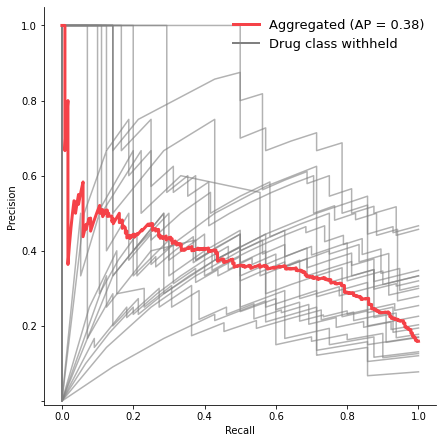

In [37]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6.5,6.5))

font = {'family': 'normal',
        'weight': 'normal',
        'size': 18}
matplotlib.rc('font', **font)
for cl in keys:
    plt.plot(pr.recall[cl][1], pr.precision[cl][1],
             color='grey', lw=1.5, alpha=0.6)
    plt.xlim([-0.05, 1.05])
plt.plot(recall_micro, prec_micro,
        label='Aggregated (AP = {0:0.2f})'
               ''.format(ap_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.ylim([-0.01, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title(title)
plt.legend(handles=handles, loc='upper right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-antagonism-vs-rest-grey.pdf')

In [38]:
# A "micro-average": quantifying score on all classes jointly
prec_micro, recall_micro, _ = precision_recall_curve(pred_vs_true['syn'].values,
                                                    pred_vs_true['score_syn'].values)
ap_micro = average_precision_score(pred_vs_true['syn'].values,
                                   pred_vs_true['score_syn'].values,
                                   average="micro")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


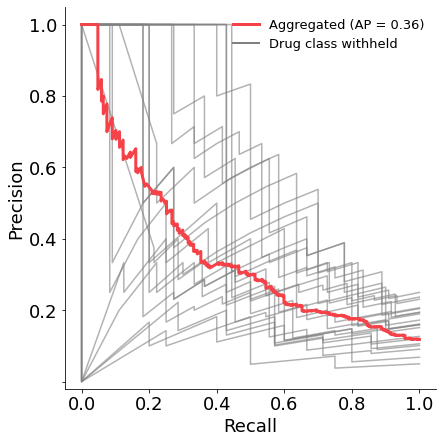

In [39]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in keys:
    plt.plot(pr.recall[cl][2], pr.precision[cl][2],
            color='grey', lw=1.5, alpha=0.6)
    plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_micro, prec_micro,
        label='Aggregated (AP = {0:0.2f})'
               ''.format(ap_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.ylim([-0.02, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title(title)
plt.legend(handles=handles, loc='upper right',
           prop={"size": 13},
            #bbox_to_anchor=(1.2,0.8),
          frameon=False)
#plt.legend([], frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-synergy-vs-rest-grey.pdf')

Plot ROC curves:

In [40]:
fpr_micro, tpr_micro, _ = roc_curve(pred_vs_true['ant'].values,
                                                    pred_vs_true['score_antag'].values)
roc_auc_micro = auc(fpr_micro, tpr_micro)

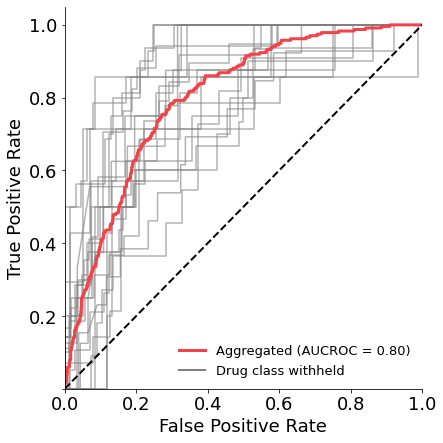

In [41]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in keys:
    plt.plot(pr.fpr[cl][1], pr.tpr[cl][1],
             color='grey', lw=1.5, alpha=0.6)
plt.plot(fpr_micro, tpr_micro,
        label='Aggregated (AUCROC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(handles=handles, loc='lower right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-ROC-antagonism-vs-rest-grey.pdf')

In [42]:
fpr_micro, tpr_micro, _ = roc_curve(pred_vs_true['syn'].values,
                                                    pred_vs_true['score_syn'].values)
roc_auc_micro = auc(fpr_micro, tpr_micro)

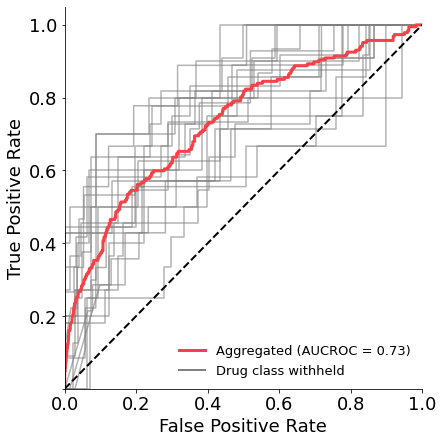

In [43]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in keys:
    plt.plot(pr.fpr[cl][2], pr.tpr[cl][2],
             color='grey', lw=1.5, alpha=0.6)
plt.plot(fpr_micro, tpr_micro,
        label='Aggregated (AUCROC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#ax.xaxis.get_major_ticks()[0].label1.set_visible(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
plt.legend(handles=handles, loc='lower right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-ROC-synergy-vs-rest-grey.pdf')

Plot average precision (AP) vs interaction rate for each cross-validation fold:

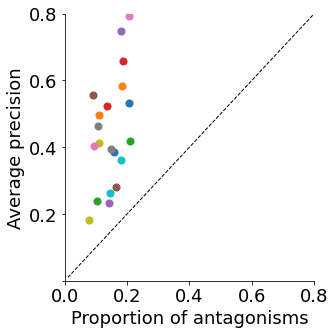

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
# for antagonism predictions
for cl in keys:
    ycl = y[np.isin(combs, pr.predicted[cl]['comb'].values)].argmax(axis=1)
    antag_rate = np.sum(ycl == 1) / ycl.size
    plt.scatter(antag_rate, pr.avprec[cl][1], marker='o', 
             label=cl, s=50)
    plt.xlim((0,0.8))
    plt.ylim((0,0.8))
plt.plot([0.01, 1], [0.01, 1], 'k--', lw=1)
plt.xlabel('Proportion of antagonisms')
plt.ylabel('Average precision')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
plt.tight_layout()
#plt.savefig('Ecoli-AP-antag-vs-rate.pdf')

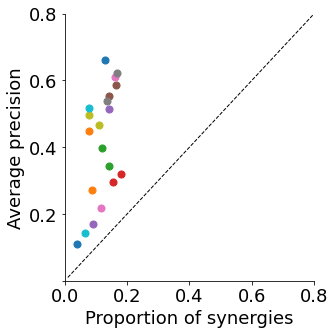

In [45]:
fig, ax = plt.subplots(figsize=(5,5))
# for antagonism predictions
for cl in keys:
    ycl = y[np.isin(combs, pr.predicted[cl]['comb'].values)].argmax(axis=1)
    syn_rate = np.sum(ycl == 2) / ycl.size
    plt.scatter(syn_rate, pr.avprec[cl][2], marker='o', 
             label=cl, s=50)
    plt.xlim((0,0.8))
    plt.ylim((0,0.8))
plt.plot([0.01, 1], [0.01, 1], 'k--', lw=1)
plt.xlabel('Proportion of synergies')
plt.ylabel('Average precision')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
plt.tight_layout()
#plt.savefig('Ecoli-AP-syn-vs-rate.pdf')

<a id="calib"></a> 
## Probability calibration

In [46]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
def build_nn(dropout=0.2, nodes=32, layers=3, learning_rate_deep=0.001):
    model = Sequential()
    for i in range(layers):
        #With BN
        #model.add(Dense(self.nodes, activation="linear", use_bias="False"))
        #model.add(BatchNormalization())
        #model.add(Activation("relu"))
        #model.add(Dropout(self.dropout))
        #Without BN
        model.add(Dense(nodes, activation="relu"))
        model.add(Dropout(dropout))
        model.add(Dense(3, activation="softmax"))
                
        opt = keras.optimizers.Adam(learning_rate=learning_rate_deep)#, beta_1=self.beta_1, beta_2=self.beta_2)
        model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = opt,  metrics = ["accuracy"]) #other option loss = "binary_crossentropy"
        return model

In [47]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
#clf = OneVsRestClassifier(RandomForestClassifier(bootstrap=True,
#                                                max_features='sqrt',
#                                                **param_dict,
#                                                random_state=2305,
#                                              n_jobs=-1))
keras_clf = OneVsRestClassifier(tf.keras.wrappers.scikit_learn.KerasClassifier(build_nn, epochs=200))

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_onehot, y, test_size=0.2,
                                                    random_state=2305,
                                                    stratify=np.argmax(y, axis=1))

In [49]:
#clf = clf.fit(X_train, y_train)
clf= keras_clf.fit(X_train, y_train)

Epoch 1/200
25/25 [==============================] - 0s 877us/step - loss: 0.7189 - accuracy: 0.6869
Epoch 2/200
25/25 [==============================] - 0s 782us/step - loss: 0.5509 - accuracy: 0.7162
Epoch 3/200
25/25 [==============================] - 0s 744us/step - loss: 0.4898 - accuracy: 0.7792
Epoch 4/200
25/25 [==============================] - 0s 754us/step - loss: 0.5112 - accuracy: 0.7715
Epoch 5/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4628 - accuracy: 0.8095
Epoch 6/200
25/25 [==============================] - 0s 926us/step - loss: 0.4541 - accuracy: 0.7813
Epoch 7/200
25/25 [==============================] - 0s 789us/step - loss: 0.4336 - accuracy: 0.7889
Epoch 8/200
25/25 [==============================] - 0s 783us/step - loss: 0.4630 - accuracy: 0.7763
Epoch 9/200
25/25 [==============================] - 0s 745us/step - loss: 0.3919 - accuracy: 0.8322
Epoch 10/200
25/25 [==============================] - 0s 715us/step - loss: 0.4237 - accuracy

25/25 [==============================] - 0s 881us/step - loss: 0.0800 - accuracy: 0.9751
Epoch 82/200
25/25 [==============================] - 0s 776us/step - loss: 0.0758 - accuracy: 0.9823
Epoch 83/200
25/25 [==============================] - 0s 746us/step - loss: 0.0864 - accuracy: 0.9740
Epoch 84/200
25/25 [==============================] - 0s 738us/step - loss: 0.0877 - accuracy: 0.9763
Epoch 85/200
25/25 [==============================] - 0s 728us/step - loss: 0.0612 - accuracy: 0.9850
Epoch 86/200
25/25 [==============================] - 0s 727us/step - loss: 0.0818 - accuracy: 0.9766
Epoch 87/200
25/25 [==============================] - 0s 779us/step - loss: 0.0721 - accuracy: 0.9791
Epoch 88/200
25/25 [==============================] - 0s 888us/step - loss: 0.0714 - accuracy: 0.9802
Epoch 89/200
25/25 [==============================] - 0s 817us/step - loss: 0.0563 - accuracy: 0.9876
Epoch 90/200
25/25 [==============================] - 0s 830us/step - loss: 0.0813 - accuracy: 

25/25 [==============================] - 0s 793us/step - loss: 0.0563 - accuracy: 0.9844
Epoch 161/200
25/25 [==============================] - 0s 802us/step - loss: 0.0483 - accuracy: 0.9778
Epoch 162/200
25/25 [==============================] - 0s 801us/step - loss: 0.0283 - accuracy: 0.9919
Epoch 163/200
25/25 [==============================] - 0s 829us/step - loss: 0.0285 - accuracy: 0.9936
Epoch 164/200
25/25 [==============================] - 0s 825us/step - loss: 0.0190 - accuracy: 0.9918
Epoch 165/200
25/25 [==============================] - 0s 817us/step - loss: 0.0641 - accuracy: 0.9819
Epoch 166/200
25/25 [==============================] - 0s 833us/step - loss: 0.0331 - accuracy: 0.9890
Epoch 167/200
25/25 [==============================] - 0s 809us/step - loss: 0.0425 - accuracy: 0.9839
Epoch 168/200
25/25 [==============================] - 0s 822us/step - loss: 0.0408 - accuracy: 0.9840
Epoch 169/200
25/25 [==============================] - 0s 854us/step - loss: 0.0375 - a

25/25 [==============================] - 0s 771us/step - loss: 0.0916 - accuracy: 0.9627
Epoch 41/200
25/25 [==============================] - 0s 832us/step - loss: 0.0920 - accuracy: 0.9743
Epoch 42/200
25/25 [==============================] - 0s 770us/step - loss: 0.1172 - accuracy: 0.9501
Epoch 43/200
25/25 [==============================] - 0s 828us/step - loss: 0.0912 - accuracy: 0.9707
Epoch 44/200
25/25 [==============================] - 0s 852us/step - loss: 0.0856 - accuracy: 0.9711
Epoch 45/200
25/25 [==============================] - 0s 842us/step - loss: 0.0798 - accuracy: 0.9747
Epoch 46/200
25/25 [==============================] - 0s 833us/step - loss: 0.0894 - accuracy: 0.9681
Epoch 47/200
25/25 [==============================] - 0s 822us/step - loss: 0.0994 - accuracy: 0.9589
Epoch 48/200
25/25 [==============================] - 0s 848us/step - loss: 0.0825 - accuracy: 0.9822
Epoch 49/200
25/25 [==============================] - 0s 825us/step - loss: 0.0852 - accuracy: 

25/25 [==============================] - 0s 1ms/step - loss: 0.0177 - accuracy: 0.9932
Epoch 121/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0245 - accuracy: 0.9914
Epoch 122/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9964
Epoch 123/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0245 - accuracy: 0.9912
Epoch 124/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0204 - accuracy: 0.9930
Epoch 125/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0175 - accuracy: 0.9943
Epoch 126/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0281 - accuracy: 0.9914
Epoch 127/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0177 - accuracy: 0.9956
Epoch 128/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0185 - accuracy: 0.9923
Epoch 129/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0149 - accuracy: 0.9947
Epoc

25/25 [==============================] - 0s 795us/step - loss: 0.0158 - accuracy: 0.9943
Epoch 1/200
25/25 [==============================] - 0s 796us/step - loss: 0.5411 - accuracy: 0.7889
Epoch 2/200
25/25 [==============================] - 0s 736us/step - loss: 0.3786 - accuracy: 0.8822
Epoch 3/200
25/25 [==============================] - 0s 747us/step - loss: 0.3284 - accuracy: 0.8838
Epoch 4/200
25/25 [==============================] - 0s 744us/step - loss: 0.2996 - accuracy: 0.8909
Epoch 5/200
25/25 [==============================] - 0s 909us/step - loss: 0.3139 - accuracy: 0.8690
Epoch 6/200
25/25 [==============================] - 0s 902us/step - loss: 0.2893 - accuracy: 0.8841
Epoch 7/200
25/25 [==============================] - 0s 827us/step - loss: 0.2756 - accuracy: 0.8866
Epoch 8/200
25/25 [==============================] - 0s 824us/step - loss: 0.2808 - accuracy: 0.8934
Epoch 9/200
25/25 [==============================] - 0s 841us/step - loss: 0.2875 - accuracy: 0.8915
Ep

25/25 [==============================] - 0s 824us/step - loss: 0.0398 - accuracy: 0.9908
Epoch 81/200
25/25 [==============================] - 0s 824us/step - loss: 0.0389 - accuracy: 0.9939
Epoch 82/200
25/25 [==============================] - 0s 805us/step - loss: 0.0374 - accuracy: 0.9862
Epoch 83/200
25/25 [==============================] - 0s 829us/step - loss: 0.0436 - accuracy: 0.9882
Epoch 84/200
25/25 [==============================] - 0s 825us/step - loss: 0.0500 - accuracy: 0.9822
Epoch 85/200
25/25 [==============================] - 0s 826us/step - loss: 0.0305 - accuracy: 0.9892
Epoch 86/200
25/25 [==============================] - 0s 836us/step - loss: 0.0335 - accuracy: 0.9901
Epoch 87/200
25/25 [==============================] - 0s 836us/step - loss: 0.0416 - accuracy: 0.9836
Epoch 88/200
25/25 [==============================] - 0s 834us/step - loss: 0.0418 - accuracy: 0.9862
Epoch 89/200
25/25 [==============================] - 0s 825us/step - loss: 0.0289 - accuracy: 

25/25 [==============================] - 0s 846us/step - loss: 0.0189 - accuracy: 0.9926
Epoch 160/200
25/25 [==============================] - 0s 770us/step - loss: 0.0149 - accuracy: 0.9944
Epoch 161/200
25/25 [==============================] - 0s 791us/step - loss: 0.0160 - accuracy: 0.9960
Epoch 162/200
25/25 [==============================] - 0s 774us/step - loss: 0.0174 - accuracy: 0.9962
Epoch 163/200
25/25 [==============================] - 0s 755us/step - loss: 0.0260 - accuracy: 0.9909
Epoch 164/200
25/25 [==============================] - 0s 742us/step - loss: 0.0261 - accuracy: 0.9907
Epoch 165/200
25/25 [==============================] - 0s 742us/step - loss: 0.0253 - accuracy: 0.9885
Epoch 166/200
25/25 [==============================] - 0s 812us/step - loss: 0.0134 - accuracy: 0.9943
Epoch 167/200
25/25 [==============================] - 0s 993us/step - loss: 0.0247 - accuracy: 0.9876
Epoch 168/200
25/25 [==============================] - 0s 849us/step - loss: 0.0199 - a

In [50]:
probas_ = clf.predict(X_val)

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Plot precision-recall for the training set:

In [51]:
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
thresh = dict()
average_precision = dict()

In [52]:
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], probas_[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], thresh[i] = precision_recall_curve(y_val[:, i],
                                                        probas_[:, i])
    average_precision[i] = average_precision_score(y_val[:, i], probas_[:, i])


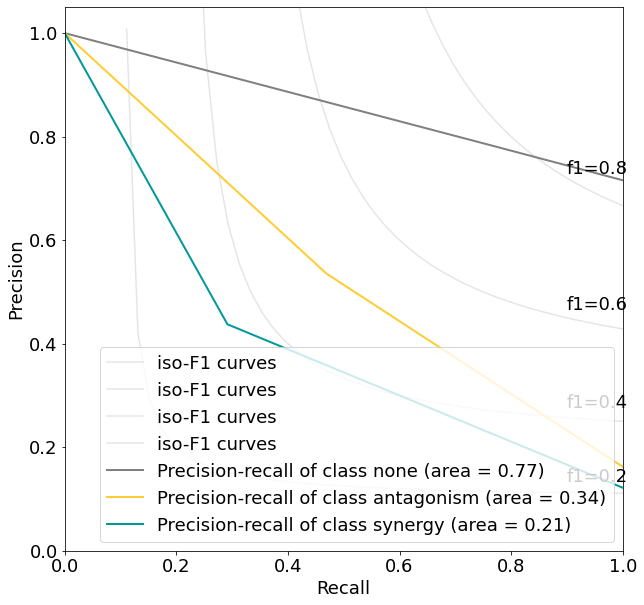

In [53]:
from itertools import cycle
class_names = ['none', 'antagonism', 'synergy']
colors = cycle(['#808080','#FFCC33', '#009999'])


plt.figure(figsize=(10,10))
f_scores = np.linspace(0.2, 0.8, num=4)

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y_ = f_score * x / (2 * x - f_score)
    plt.plot(x[y_ >= 0], y_[y_ >= 0], color='gray', alpha=0.2,
             label='iso-F1 curves')
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y_[45] + 0.02))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [54]:
from sklearn.calibration import calibration_curve
fraction_of_positives = dict()
mean_predicted_value = dict()
for i in range(n_classes):
    proba_val = clf.predict_proba(X_val)[:, i]
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(y_val[:,i],
                                                                proba_val,
                                                                n_bins=6)

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

In [55]:
mean_predicted_value[2]

array([0.00509713, 0.26705122, 0.44835931, 0.59294522, 0.74089634,
       0.9373042 ])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


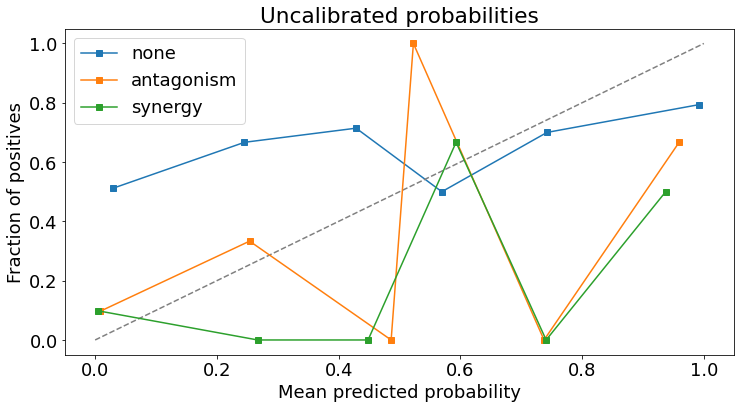

In [56]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value[0], fraction_of_positives[0], 's-', label='none')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(mean_predicted_value[1], fraction_of_positives[1], 's-', label='antagonism')
plt.plot(mean_predicted_value[2], fraction_of_positives[2], 's-', label='synergy')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Uncalibrated probabilities')
plt.legend()

In [57]:
from sklearn.calibration import CalibratedClassifierCV
fraction_of_positives = dict()
mean_predicted_value = dict()
for i in range(n_classes):
    #proba_val = clf.predict_proba(X_val)[:, i]
#    clf_calib = CalibratedClassifierCV(clf.estimators_[i], cv=10, method='isotonic')
    clf_calib = CalibratedClassifierCV(clf, cv=10, method='isotonic')
    proba_val = clf_calib.fit(X_train, y_train[:,i]).predict_proba(X_val)[:,1]
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(y_val[:,i],
                                                                proba_val,
                                                                n_bins=5)

Epoch 1/200
23/23 [==============================] - 0s 933us/step - loss: 0.8684 - accuracy: 0.5720
Epoch 2/200
23/23 [==============================] - 0s 970us/step - loss: 0.5671 - accuracy: 0.7360
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5268 - accuracy: 0.7452
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4904 - accuracy: 0.7553
Epoch 5/200
23/23 [==============================] - 0s 983us/step - loss: 0.4716 - accuracy: 0.7986
Epoch 6/200
23/23 [==============================] - 0s 916us/step - loss: 0.4585 - accuracy: 0.8106
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.8008
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.8152
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4231 - accuracy: 0.8399
Epoch 10/200
23/23 [==============================] - 0s 990us/step - loss: 0.4230 - accuracy: 0.7955

Epoch 82/200
23/23 [==============================] - 0s 867us/step - loss: 0.1204 - accuracy: 0.9631
Epoch 83/200
23/23 [==============================] - 0s 913us/step - loss: 0.1194 - accuracy: 0.9644
Epoch 84/200
23/23 [==============================] - 0s 895us/step - loss: 0.1620 - accuracy: 0.9446
Epoch 85/200
23/23 [==============================] - 0s 925us/step - loss: 0.1191 - accuracy: 0.9612
Epoch 86/200
23/23 [==============================] - 0s 883us/step - loss: 0.1065 - accuracy: 0.9590
Epoch 87/200
23/23 [==============================] - 0s 885us/step - loss: 0.1303 - accuracy: 0.9534
Epoch 88/200
23/23 [==============================] - 0s 810us/step - loss: 0.1377 - accuracy: 0.9410
Epoch 89/200
23/23 [==============================] - 0s 933us/step - loss: 0.1842 - accuracy: 0.9162
Epoch 90/200
23/23 [==============================] - 0s 829us/step - loss: 0.1362 - accuracy: 0.9603
Epoch 91/200
23/23 [==============================] - 0s 869us/step - loss: 0.1263

23/23 [==============================] - 0s 832us/step - loss: 0.0542 - accuracy: 0.9829
Epoch 162/200
23/23 [==============================] - 0s 821us/step - loss: 0.0720 - accuracy: 0.9720
Epoch 163/200
23/23 [==============================] - 0s 838us/step - loss: 0.0622 - accuracy: 0.9766
Epoch 164/200
23/23 [==============================] - 0s 905us/step - loss: 0.0689 - accuracy: 0.9696
Epoch 165/200
23/23 [==============================] - 0s 900us/step - loss: 0.0615 - accuracy: 0.9802
Epoch 166/200
23/23 [==============================] - 0s 804us/step - loss: 0.0544 - accuracy: 0.9774
Epoch 167/200
23/23 [==============================] - 0s 928us/step - loss: 0.0528 - accuracy: 0.9816
Epoch 168/200
23/23 [==============================] - 0s 852us/step - loss: 0.0438 - accuracy: 0.9891
Epoch 169/200
23/23 [==============================] - 0s 898us/step - loss: 0.0461 - accuracy: 0.9901
Epoch 170/200
23/23 [==============================] - 0s 891us/step - loss: 0.0578 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 834us/step - loss: 0.7198 - accuracy: 0.6747
Epoch 2/200
23/23 [==============================] - 0s 725us/step - loss: 0.5326 - accuracy: 0.7307
Epoch 3/200
23/23 [==============================] - 0s 925us/step - loss: 0.4808 - accuracy: 0.7910
Epoch 4/200
23/23 [==============================] - 0s 877us/step - loss: 0.4722 - accuracy: 0.7830
Epoch 5/200
23/23 [==============================] - 0s 907us/step - loss: 0.4575 - accuracy: 0.7898
Epoch 6/200
23/23 [==============================] - 0s 857us/step - loss: 0.4434 - accuracy: 0.8037
Epoch 7/200
23/23 [==============================] - 0s 865us/step - loss: 0.4373 - accuracy: 0.8190
Epoch 8/200
23/23 [==============================] - 0s 866us/step - loss: 0.4268 - accuracy: 0.7997
Epoch 9/200
23/23 [==============================] - 0s 848us/step - loss: 0.4546 - accuracy: 0.7908
Epoch 10/200
23/23 [==============================] - 0s 870us/step - loss: 0.3907 - accuracy: 0.8292
E

23/23 [==============================] - 0s 832us/step - loss: 0.0777 - accuracy: 0.9744
Epoch 82/200
23/23 [==============================] - 0s 814us/step - loss: 0.0871 - accuracy: 0.9663
Epoch 83/200
23/23 [==============================] - 0s 839us/step - loss: 0.0850 - accuracy: 0.9774
Epoch 84/200
23/23 [==============================] - 0s 899us/step - loss: 0.0779 - accuracy: 0.9717
Epoch 85/200
23/23 [==============================] - 0s 855us/step - loss: 0.0695 - accuracy: 0.9840
Epoch 86/200
23/23 [==============================] - 0s 851us/step - loss: 0.0777 - accuracy: 0.9749
Epoch 87/200
23/23 [==============================] - 0s 870us/step - loss: 0.0839 - accuracy: 0.9701
Epoch 88/200
23/23 [==============================] - 0s 841us/step - loss: 0.0733 - accuracy: 0.9756
Epoch 89/200
23/23 [==============================] - 0s 845us/step - loss: 0.0728 - accuracy: 0.9820
Epoch 90/200
23/23 [==============================] - 0s 878us/step - loss: 0.0925 - accuracy: 

23/23 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.9939
Epoch 162/200
23/23 [==============================] - 0s 949us/step - loss: 0.0386 - accuracy: 0.9874
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.9906
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0232 - accuracy: 0.9980
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0219 - accuracy: 0.9958
Epoch 166/200
23/23 [==============================] - 0s 937us/step - loss: 0.0226 - accuracy: 0.9909
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0599 - accuracy: 0.9645
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0504 - accuracy: 0.9813
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0419 - accuracy: 0.9888
Epoch 170/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0415 - accuracy: 0.9826


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 809us/step - loss: 0.8524 - accuracy: 0.5837
Epoch 2/200
23/23 [==============================] - 0s 773us/step - loss: 0.5601 - accuracy: 0.7427
Epoch 3/200
23/23 [==============================] - 0s 893us/step - loss: 0.5210 - accuracy: 0.7409
Epoch 4/200
23/23 [==============================] - 0s 869us/step - loss: 0.5085 - accuracy: 0.7614
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.7601
Epoch 6/200
23/23 [==============================] - 0s 936us/step - loss: 0.4595 - accuracy: 0.7803
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4310 - accuracy: 0.8010
Epoch 8/200
23/23 [==============================] - 0s 975us/step - loss: 0.4332 - accuracy: 0.8169
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.8036
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4178 - accuracy: 0.8196
Epoch 11/

23/23 [==============================] - 0s 793us/step - loss: 0.0779 - accuracy: 0.9748
Epoch 83/200
23/23 [==============================] - 0s 818us/step - loss: 0.0748 - accuracy: 0.9828
Epoch 84/200
23/23 [==============================] - 0s 775us/step - loss: 0.0745 - accuracy: 0.9751
Epoch 85/200
23/23 [==============================] - 0s 830us/step - loss: 0.0701 - accuracy: 0.9822
Epoch 86/200
23/23 [==============================] - 0s 845us/step - loss: 0.0760 - accuracy: 0.9746
Epoch 87/200
23/23 [==============================] - 0s 810us/step - loss: 0.0585 - accuracy: 0.9912
Epoch 88/200
23/23 [==============================] - 0s 833us/step - loss: 0.0906 - accuracy: 0.9660
Epoch 89/200
23/23 [==============================] - 0s 856us/step - loss: 0.0675 - accuracy: 0.9778
Epoch 90/200
23/23 [==============================] - 0s 879us/step - loss: 0.0602 - accuracy: 0.9795
Epoch 91/200
23/23 [==============================] - 0s 824us/step - loss: 0.0714 - accuracy: 

23/23 [==============================] - 0s 781us/step - loss: 0.0335 - accuracy: 0.9886
Epoch 162/200
23/23 [==============================] - 0s 808us/step - loss: 0.0237 - accuracy: 0.9963
Epoch 163/200
23/23 [==============================] - 0s 789us/step - loss: 0.0311 - accuracy: 0.9939
Epoch 164/200
23/23 [==============================] - 0s 816us/step - loss: 0.0324 - accuracy: 0.9903
Epoch 165/200
23/23 [==============================] - 0s 816us/step - loss: 0.0273 - accuracy: 0.9921
Epoch 166/200
23/23 [==============================] - 0s 849us/step - loss: 0.0422 - accuracy: 0.9879
Epoch 167/200
23/23 [==============================] - 0s 832us/step - loss: 0.0312 - accuracy: 0.9882
Epoch 168/200
23/23 [==============================] - 0s 837us/step - loss: 0.0264 - accuracy: 0.9924
Epoch 169/200
23/23 [==============================] - 0s 836us/step - loss: 0.0377 - accuracy: 0.9829
Epoch 170/200
23/23 [==============================] - 0s 866us/step - loss: 0.0397 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 839us/step - loss: 0.7762 - accuracy: 0.5932
Epoch 2/200
23/23 [==============================] - 0s 742us/step - loss: 0.5624 - accuracy: 0.7295
Epoch 3/200
23/23 [==============================] - 0s 852us/step - loss: 0.4922 - accuracy: 0.7732
Epoch 4/200
23/23 [==============================] - 0s 841us/step - loss: 0.4901 - accuracy: 0.7784
Epoch 5/200
23/23 [==============================] - 0s 848us/step - loss: 0.4794 - accuracy: 0.7854
Epoch 6/200
23/23 [==============================] - 0s 829us/step - loss: 0.4558 - accuracy: 0.7931
Epoch 7/200
23/23 [==============================] - 0s 850us/step - loss: 0.4509 - accuracy: 0.7831
Epoch 8/200
23/23 [==============================] - 0s 893us/step - loss: 0.4341 - accuracy: 0.8112
Epoch 9/200
23/23 [==============================] - 0s 973us/step - loss: 0.4244 - accuracy: 0.7935
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4087 - accuracy: 0.8366
Epo

23/23 [==============================] - 0s 1ms/step - loss: 0.0918 - accuracy: 0.9736
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9820
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0962 - accuracy: 0.9702
Epoch 85/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0733 - accuracy: 0.9818
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9662
Epoch 87/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9863
Epoch 88/200
23/23 [==============================] - 0s 1000us/step - loss: 0.0956 - accuracy: 0.9644
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0824 - accuracy: 0.9681
Epoch 90/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0654 - accuracy: 0.9842
Epoch 91/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0833 - accuracy: 0.9807
Epoch 92/2

23/23 [==============================] - 0s 1ms/step - loss: 0.0484 - accuracy: 0.9812
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0618 - accuracy: 0.9814
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0418 - accuracy: 0.9877
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9907
Epoch 166/200
23/23 [==============================] - 0s 896us/step - loss: 0.0350 - accuracy: 0.9911
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0397 - accuracy: 0.9904
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.9906
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0508 - accuracy: 0.9843
Epoch 170/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.9905
Epoch 171/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9793
Ep

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/200
23/23 [==============================] - 0s 851us/step - loss: 0.6772 - accuracy: 0.6452
Epoch 2/200
23/23 [==============================] - 0s 813us/step - loss: 0.5048 - accuracy: 0.7675
Epoch 3/200
23/23 [==============================] - 0s 828us/step - loss: 0.4790 - accuracy: 0.7789
Epoch 4/200
23/23 [==============================] - 0s 878us/step - loss: 0.5035 - accuracy: 0.7566
Epoch 5/200
23/23 [==============================] - 0s 865us/step - loss: 0.4561 - accuracy: 0.7936
Epoch 6/200
23/23 [==============================] - 0s 825us/step - loss: 0.4244 - accuracy: 0.8055
Epoch 7/200
23/23 [==============================] - 0s 837us/step - loss: 0.4200 - accuracy: 0.8112
Epoch 8/200
23/23 [==============================] - 0s 870us/step - loss: 0.3985 - accuracy: 0.8180
Epoch 9/200
23/23 [==============================] - 0s 846us/step - loss: 0.4312 - accuracy: 0.8088
Epoch 10/200
23/23 [==============================] - 0s 846us/step - loss: 0.4007 - accura

23/23 [==============================] - 0s 799us/step - loss: 0.0944 - accuracy: 0.9704
Epoch 82/200
23/23 [==============================] - 0s 817us/step - loss: 0.0919 - accuracy: 0.9736
Epoch 83/200
23/23 [==============================] - 0s 791us/step - loss: 0.0831 - accuracy: 0.9711
Epoch 84/200
23/23 [==============================] - 0s 850us/step - loss: 0.0810 - accuracy: 0.9752
Epoch 85/200
23/23 [==============================] - 0s 867us/step - loss: 0.0952 - accuracy: 0.9724
Epoch 86/200
23/23 [==============================] - 0s 824us/step - loss: 0.0925 - accuracy: 0.9759
Epoch 87/200
23/23 [==============================] - 0s 844us/step - loss: 0.0881 - accuracy: 0.9618
Epoch 88/200
23/23 [==============================] - 0s 838us/step - loss: 0.0677 - accuracy: 0.9769
Epoch 89/200
23/23 [==============================] - 0s 874us/step - loss: 0.0796 - accuracy: 0.9721
Epoch 90/200
23/23 [==============================] - 0s 825us/step - loss: 0.0735 - accuracy: 

23/23 [==============================] - 0s 1ms/step - loss: 0.0301 - accuracy: 0.9875
Epoch 162/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9978
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0402 - accuracy: 0.9820
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0495 - accuracy: 0.9843
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0437 - accuracy: 0.9880
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0289 - accuracy: 0.9940
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0286 - accuracy: 0.9952
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0501 - accuracy: 0.9830
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy: 0.9889
Epoch 170/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0342 - accuracy: 0.9891
Epoc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.9670 - accuracy: 0.5651
Epoch 2/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5676 - accuracy: 0.7341
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5449 - accuracy: 0.7142
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5372 - accuracy: 0.7445
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5453 - accuracy: 0.7369
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4959 - accuracy: 0.7814
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4844 - accuracy: 0.7609
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.8090
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4393 - accuracy: 0.8062
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4162 - accuracy: 0.8196
Epoch 11/200
23/23 [=

23/23 [==============================] - 0s 812us/step - loss: 0.1250 - accuracy: 0.9670
Epoch 83/200
23/23 [==============================] - 0s 796us/step - loss: 0.1299 - accuracy: 0.9513
Epoch 84/200
23/23 [==============================] - 0s 758us/step - loss: 0.1308 - accuracy: 0.9606
Epoch 85/200
23/23 [==============================] - 0s 867us/step - loss: 0.0772 - accuracy: 0.9851
Epoch 86/200
23/23 [==============================] - 0s 834us/step - loss: 0.1071 - accuracy: 0.9698
Epoch 87/200
23/23 [==============================] - 0s 894us/step - loss: 0.1113 - accuracy: 0.9701
Epoch 88/200
23/23 [==============================] - 0s 851us/step - loss: 0.1245 - accuracy: 0.9648
Epoch 89/200
23/23 [==============================] - 0s 820us/step - loss: 0.1131 - accuracy: 0.9672
Epoch 90/200
23/23 [==============================] - 0s 868us/step - loss: 0.0996 - accuracy: 0.9720
Epoch 91/200
23/23 [==============================] - 0s 822us/step - loss: 0.1052 - accuracy: 

23/23 [==============================] - 0s 805us/step - loss: 0.0549 - accuracy: 0.9833
Epoch 162/200
23/23 [==============================] - 0s 789us/step - loss: 0.0678 - accuracy: 0.9756
Epoch 163/200
23/23 [==============================] - 0s 829us/step - loss: 0.0677 - accuracy: 0.9739
Epoch 164/200
23/23 [==============================] - 0s 815us/step - loss: 0.0662 - accuracy: 0.9793
Epoch 165/200
23/23 [==============================] - 0s 836us/step - loss: 0.0534 - accuracy: 0.9868
Epoch 166/200
23/23 [==============================] - 0s 830us/step - loss: 0.0666 - accuracy: 0.9759
Epoch 167/200
23/23 [==============================] - 0s 832us/step - loss: 0.1790 - accuracy: 0.9279
Epoch 168/200
23/23 [==============================] - 0s 841us/step - loss: 0.1004 - accuracy: 0.9675
Epoch 169/200
23/23 [==============================] - 0s 876us/step - loss: 0.1207 - accuracy: 0.9483
Epoch 170/200
23/23 [==============================] - 0s 878us/step - loss: 0.1196 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 798us/step - loss: 0.6495 - accuracy: 0.7050
Epoch 2/200
23/23 [==============================] - 0s 754us/step - loss: 0.5038 - accuracy: 0.7723
Epoch 3/200
23/23 [==============================] - 0s 822us/step - loss: 0.4782 - accuracy: 0.7850
Epoch 4/200
23/23 [==============================] - 0s 868us/step - loss: 0.4748 - accuracy: 0.7890
Epoch 5/200
23/23 [==============================] - 0s 827us/step - loss: 0.4787 - accuracy: 0.7786
Epoch 6/200
23/23 [==============================] - 0s 830us/step - loss: 0.4041 - accuracy: 0.8285
Epoch 7/200
23/23 [==============================] - 0s 818us/step - loss: 0.4353 - accuracy: 0.8223
Epoch 8/200
23/23 [==============================] - 0s 837us/step - loss: 0.4162 - accuracy: 0.8177
Epoch 9/200
23/23 [==============================] - 0s 822us/step - loss: 0.3867 - accuracy: 0.8495
Epoch 10/200
23/23 [==============================] - 0s 827us/step - loss: 0.3782 - accuracy: 0.8353
E

23/23 [==============================] - 0s 1ms/step - loss: 0.0835 - accuracy: 0.9723
Epoch 82/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.9774
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0866 - accuracy: 0.9766
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0860 - accuracy: 0.9790
Epoch 85/200
23/23 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.9421
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0891 - accuracy: 0.9774
Epoch 87/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0854 - accuracy: 0.9758
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0894 - accuracy: 0.9680
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0744 - accuracy: 0.9753
Epoch 90/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.9757
Epoch 91/200


23/23 [==============================] - 0s 1ms/step - loss: 0.0468 - accuracy: 0.9795
Epoch 162/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0370 - accuracy: 0.9920
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0359 - accuracy: 0.9861
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0372 - accuracy: 0.9927
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9907
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0278 - accuracy: 0.9951
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0394 - accuracy: 0.9856
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0316 - accuracy: 0.9922
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.9934
Epoch 170/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0273 - accuracy: 0.9929
Epoc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 872us/step - loss: 0.7234 - accuracy: 0.6355
Epoch 2/200
23/23 [==============================] - 0s 850us/step - loss: 0.5099 - accuracy: 0.7600
Epoch 3/200
23/23 [==============================] - 0s 918us/step - loss: 0.5386 - accuracy: 0.7358
Epoch 4/200
23/23 [==============================] - 0s 931us/step - loss: 0.5193 - accuracy: 0.7649
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5095 - accuracy: 0.7717
Epoch 6/200
23/23 [==============================] - 0s 910us/step - loss: 0.4613 - accuracy: 0.7794
Epoch 7/200
23/23 [==============================] - 0s 948us/step - loss: 0.4241 - accuracy: 0.8149
Epoch 8/200
23/23 [==============================] - 0s 878us/step - loss: 0.4603 - accuracy: 0.7824
Epoch 9/200
23/23 [==============================] - 0s 947us/step - loss: 0.4339 - accuracy: 0.7973
Epoch 10/200
23/23 [==============================] - 0s 917us/step - loss: 0.4221 - accuracy: 0.7943
Epo

23/23 [==============================] - 0s 953us/step - loss: 0.1154 - accuracy: 0.9662
Epoch 82/200
23/23 [==============================] - 0s 893us/step - loss: 0.0954 - accuracy: 0.9769
Epoch 83/200
23/23 [==============================] - 0s 892us/step - loss: 0.0993 - accuracy: 0.9733
Epoch 84/200
23/23 [==============================] - 0s 930us/step - loss: 0.1267 - accuracy: 0.9587
Epoch 85/200
23/23 [==============================] - 0s 961us/step - loss: 0.1023 - accuracy: 0.9692
Epoch 86/200
23/23 [==============================] - 0s 989us/step - loss: 0.0854 - accuracy: 0.9757
Epoch 87/200
23/23 [==============================] - 0s 963us/step - loss: 0.0937 - accuracy: 0.9717
Epoch 88/200
23/23 [==============================] - 0s 930us/step - loss: 0.0915 - accuracy: 0.9647
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0978 - accuracy: 0.9666
Epoch 90/200
23/23 [==============================] - 0s 899us/step - loss: 0.0945 - accuracy: 0.

23/23 [==============================] - 0s 908us/step - loss: 0.0307 - accuracy: 0.9924
Epoch 161/200
23/23 [==============================] - 0s 858us/step - loss: 0.0344 - accuracy: 0.9892
Epoch 162/200
23/23 [==============================] - 0s 811us/step - loss: 0.0644 - accuracy: 0.9782
Epoch 163/200
23/23 [==============================] - 0s 972us/step - loss: 0.0531 - accuracy: 0.9798
Epoch 164/200
23/23 [==============================] - 0s 939us/step - loss: 0.0566 - accuracy: 0.9739
Epoch 165/200
23/23 [==============================] - 0s 949us/step - loss: 0.0509 - accuracy: 0.9863
Epoch 166/200
23/23 [==============================] - 0s 862us/step - loss: 0.0410 - accuracy: 0.9839
Epoch 167/200
23/23 [==============================] - 0s 924us/step - loss: 0.0450 - accuracy: 0.9871
Epoch 168/200
23/23 [==============================] - 0s 887us/step - loss: 0.0495 - accuracy: 0.9887
Epoch 169/200
23/23 [==============================] - 0s 902us/step - loss: 0.0353 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 865us/step - loss: 0.7658 - accuracy: 0.6297
Epoch 2/200
23/23 [==============================] - 0s 741us/step - loss: 0.5227 - accuracy: 0.7776
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5033 - accuracy: 0.7454
Epoch 4/200
23/23 [==============================] - 0s 905us/step - loss: 0.4959 - accuracy: 0.7651
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4452 - accuracy: 0.7943
Epoch 6/200
23/23 [==============================] - 0s 943us/step - loss: 0.4506 - accuracy: 0.7884
Epoch 7/200
23/23 [==============================] - 0s 878us/step - loss: 0.4169 - accuracy: 0.8120
Epoch 8/200
23/23 [==============================] - 0s 943us/step - loss: 0.4292 - accuracy: 0.8219
Epoch 9/200
23/23 [==============================] - 0s 868us/step - loss: 0.4169 - accuracy: 0.8280
Epoch 10/200
23/23 [==============================] - 0s 961us/step - loss: 0.3943 - accuracy: 0.8445
Epoch

23/23 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9707
Epoch 82/200
23/23 [==============================] - 0s 985us/step - loss: 0.0982 - accuracy: 0.9625
Epoch 83/200
23/23 [==============================] - 0s 961us/step - loss: 0.0872 - accuracy: 0.9681
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0918 - accuracy: 0.9765
Epoch 85/200
23/23 [==============================] - 0s 993us/step - loss: 0.0789 - accuracy: 0.9761
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0868 - accuracy: 0.9664
Epoch 87/200
23/23 [==============================] - 0s 963us/step - loss: 0.1005 - accuracy: 0.9693
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.9828
Epoch 89/200
23/23 [==============================] - 0s 890us/step - loss: 0.0953 - accuracy: 0.9692
Epoch 90/200
23/23 [==============================] - 0s 815us/step - loss: 0.0738 - accuracy: 0.9725
E

23/23 [==============================] - 0s 965us/step - loss: 0.0657 - accuracy: 0.9727
Epoch 162/200
23/23 [==============================] - 0s 958us/step - loss: 0.0427 - accuracy: 0.9851
Epoch 163/200
23/23 [==============================] - 0s 879us/step - loss: 0.0350 - accuracy: 0.9950
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0378 - accuracy: 0.9927
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9908
Epoch 166/200
23/23 [==============================] - 0s 917us/step - loss: 0.0380 - accuracy: 0.9936
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0483 - accuracy: 0.9801
Epoch 168/200
23/23 [==============================] - 0s 888us/step - loss: 0.0516 - accuracy: 0.9842
Epoch 169/200
23/23 [==============================] - 0s 902us/step - loss: 0.0550 - accuracy: 0.9794
Epoch 170/200
23/23 [==============================] - 0s 997us/step - loss: 0.0424 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.8305 - accuracy: 0.5861
Epoch 2/200
23/23 [==============================] - 0s 913us/step - loss: 0.5752 - accuracy: 0.7200
Epoch 3/200
23/23 [==============================] - 0s 965us/step - loss: 0.5249 - accuracy: 0.7577
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5062 - accuracy: 0.7747
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7809
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.5024 - accuracy: 0.7616
Epoch 7/200
23/23 [==============================] - 0s 966us/step - loss: 0.4760 - accuracy: 0.7671
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4465 - accuracy: 0.7853
Epoch 9/200
23/23 [==============================] - 0s 947us/step - loss: 0.4234 - accuracy: 0.8210
Epoch 10/200
23/23 [==============================] - 0s 959us/step - loss: 0.4309 - accuracy: 0.8092
Epoch 11/20

23/23 [==============================] - 0s 935us/step - loss: 0.1227 - accuracy: 0.9578
Epoch 82/200
23/23 [==============================] - 0s 895us/step - loss: 0.1210 - accuracy: 0.9666
Epoch 83/200
23/23 [==============================] - 0s 879us/step - loss: 0.0851 - accuracy: 0.9717
Epoch 84/200
23/23 [==============================] - 0s 924us/step - loss: 0.1166 - accuracy: 0.9722
Epoch 85/200
23/23 [==============================] - 0s 967us/step - loss: 0.1003 - accuracy: 0.9660
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0796 - accuracy: 0.9800
Epoch 87/200
23/23 [==============================] - 0s 998us/step - loss: 0.0889 - accuracy: 0.9777
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.1132 - accuracy: 0.9581
Epoch 89/200
23/23 [==============================] - 0s 910us/step - loss: 0.1018 - accuracy: 0.9610
Epoch 90/200
23/23 [==============================] - 0s 938us/step - loss: 0.1010 - accuracy: 0.96

23/23 [==============================] - 0s 925us/step - loss: 0.0573 - accuracy: 0.9763
Epoch 162/200
23/23 [==============================] - 0s 852us/step - loss: 0.0432 - accuracy: 0.9883
Epoch 163/200
23/23 [==============================] - 0s 918us/step - loss: 0.0382 - accuracy: 0.9909
Epoch 164/200
23/23 [==============================] - 0s 974us/step - loss: 0.0516 - accuracy: 0.9897
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0470 - accuracy: 0.9846
Epoch 166/200
23/23 [==============================] - 0s 879us/step - loss: 0.0391 - accuracy: 0.9888
Epoch 167/200
23/23 [==============================] - 0s 968us/step - loss: 0.0577 - accuracy: 0.9800
Epoch 168/200
23/23 [==============================] - 0s 909us/step - loss: 0.0452 - accuracy: 0.9784
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.9842
Epoch 170/200
23/23 [==============================] - 0s 967us/step - loss: 0.0364 - accur

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/200
23/23 [==============================] - 0s 964us/step - loss: 0.8046 - accuracy: 0.6284
Epoch 2/200
23/23 [==============================] - 0s 933us/step - loss: 0.4093 - accuracy: 0.8283
Epoch 3/200
23/23 [==============================] - 0s 913us/step - loss: 0.3812 - accuracy: 0.8307
Epoch 4/200
23/23 [==============================] - 0s 914us/step - loss: 0.3679 - accuracy: 0.8579
Epoch 5/200
23/23 [==============================] - 0s 976us/step - loss: 0.3326 - accuracy: 0.8663
Epoch 6/200
23/23 [==============================] - 0s 991us/step - loss: 0.3332 - accuracy: 0.8409
Epoch 7/200
23/23 [==============================] - 0s 883us/step - loss: 0.3220 - accuracy: 0.8673
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.9001
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2667 - accuracy: 0.8826
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3132 - accuracy: 0.

23/23 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.9749
Epoch 82/200
23/23 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9743
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0586 - accuracy: 0.9816
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0754 - accuracy: 0.9698
Epoch 85/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9856
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0536 - accuracy: 0.9798
Epoch 87/200
23/23 [==============================] - 0s 990us/step - loss: 0.0719 - accuracy: 0.9736
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0541 - accuracy: 0.9812
Epoch 89/200
23/23 [==============================] - 0s 992us/step - loss: 0.0482 - accuracy: 0.9801
Epoch 90/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0458 - accuracy: 0.9912
Epoch 91/

23/23 [==============================] - 0s 909us/step - loss: 0.0443 - accuracy: 0.9920
Epoch 162/200
23/23 [==============================] - 0s 847us/step - loss: 0.0241 - accuracy: 0.9981
Epoch 163/200
23/23 [==============================] - 0s 915us/step - loss: 0.0169 - accuracy: 0.9978
Epoch 164/200
23/23 [==============================] - 0s 929us/step - loss: 0.0258 - accuracy: 0.9882
Epoch 165/200
23/23 [==============================] - 0s 947us/step - loss: 0.0269 - accuracy: 0.9946
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0184 - accuracy: 0.9958
Epoch 167/200
23/23 [==============================] - 0s 885us/step - loss: 0.0143 - accuracy: 0.9959
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.9994
Epoch 169/200
23/23 [==============================] - 0s 977us/step - loss: 0.0135 - accuracy: 0.9958
Epoch 170/200
23/23 [==============================] - 0s 985us/step - loss: 0.0241 - accur

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 807us/step - loss: 0.5979 - accuracy: 0.7585
Epoch 2/200
23/23 [==============================] - 0s 909us/step - loss: 0.4328 - accuracy: 0.8274
Epoch 3/200
23/23 [==============================] - 0s 993us/step - loss: 0.3228 - accuracy: 0.8497
Epoch 4/200
23/23 [==============================] - 0s 918us/step - loss: 0.3307 - accuracy: 0.8676
Epoch 5/200
23/23 [==============================] - 0s 886us/step - loss: 0.3308 - accuracy: 0.8920
Epoch 6/200
23/23 [==============================] - 0s 930us/step - loss: 0.3026 - accuracy: 0.8864
Epoch 7/200
23/23 [==============================] - 0s 857us/step - loss: 0.3091 - accuracy: 0.8551
Epoch 8/200
23/23 [==============================] - 0s 946us/step - loss: 0.2832 - accuracy: 0.8853
Epoch 9/200
23/23 [==============================] - 0s 892us/step - loss: 0.2632 - accuracy: 0.8843
Epoch 10/200
23/23 [==============================] - 0s 945us/step - loss: 0.2786 - accuracy: 0.8854
E

23/23 [==============================] - 0s 931us/step - loss: 0.0351 - accuracy: 0.9916
Epoch 83/200
23/23 [==============================] - 0s 991us/step - loss: 0.0326 - accuracy: 0.9982
Epoch 84/200
23/23 [==============================] - 0s 875us/step - loss: 0.0369 - accuracy: 0.9919
Epoch 85/200
23/23 [==============================] - 0s 896us/step - loss: 0.0449 - accuracy: 0.9833
Epoch 86/200
23/23 [==============================] - 0s 936us/step - loss: 0.0424 - accuracy: 0.9847
Epoch 87/200
23/23 [==============================] - 0s 938us/step - loss: 0.0380 - accuracy: 0.9911
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0294 - accuracy: 0.9930
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0299 - accuracy: 0.9954
Epoch 90/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0258 - accuracy: 0.9930
Epoch 91/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0273 - accuracy: 0.9921
E

23/23 [==============================] - 0s 956us/step - loss: 0.0364 - accuracy: 0.9851
Epoch 163/200
23/23 [==============================] - 0s 817us/step - loss: 0.0171 - accuracy: 0.9974
Epoch 164/200
23/23 [==============================] - 0s 952us/step - loss: 0.0135 - accuracy: 0.9965
Epoch 165/200
23/23 [==============================] - 0s 899us/step - loss: 0.0233 - accuracy: 0.9887
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.9978
Epoch 167/200
23/23 [==============================] - 0s 891us/step - loss: 0.0138 - accuracy: 0.9956
Epoch 168/200
23/23 [==============================] - 0s 972us/step - loss: 0.0342 - accuracy: 0.9846
Epoch 169/200
23/23 [==============================] - 0s 924us/step - loss: 0.0316 - accuracy: 0.9911
Epoch 170/200
23/23 [==============================] - 0s 859us/step - loss: 0.0156 - accuracy: 0.9959
Epoch 171/200
23/23 [==============================] - 0s 969us/step - loss: 0.0134 - acc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 847us/step - loss: 0.6040 - accuracy: 0.7898
Epoch 2/200
23/23 [==============================] - 0s 850us/step - loss: 0.3843 - accuracy: 0.8508
Epoch 3/200
23/23 [==============================] - 0s 884us/step - loss: 0.4374 - accuracy: 0.7971
Epoch 4/200
23/23 [==============================] - 0s 933us/step - loss: 0.3314 - accuracy: 0.8684
Epoch 5/200
23/23 [==============================] - 0s 878us/step - loss: 0.3273 - accuracy: 0.8866
Epoch 6/200
23/23 [==============================] - 0s 911us/step - loss: 0.3467 - accuracy: 0.8671
Epoch 7/200
23/23 [==============================] - 0s 907us/step - loss: 0.3095 - accuracy: 0.8777
Epoch 8/200
23/23 [==============================] - 0s 977us/step - loss: 0.2852 - accuracy: 0.8834
Epoch 9/200
23/23 [==============================] - 0s 971us/step - loss: 0.2958 - accuracy: 0.8828
Epoch 10/200
23/23 [==============================] - 0s 985us/step - loss: 0.2616 - accuracy: 0.9140
E

23/23 [==============================] - 0s 895us/step - loss: 0.0480 - accuracy: 0.9838
Epoch 82/200
23/23 [==============================] - 0s 867us/step - loss: 0.0383 - accuracy: 0.9921
Epoch 83/200
23/23 [==============================] - 0s 876us/step - loss: 0.0449 - accuracy: 0.9880
Epoch 84/200
23/23 [==============================] - 0s 931us/step - loss: 0.0354 - accuracy: 0.9913
Epoch 85/200
23/23 [==============================] - 0s 938us/step - loss: 0.0432 - accuracy: 0.9871
Epoch 86/200
23/23 [==============================] - 0s 955us/step - loss: 0.0411 - accuracy: 0.9871
Epoch 87/200
23/23 [==============================] - 0s 922us/step - loss: 0.0461 - accuracy: 0.9823
Epoch 88/200
23/23 [==============================] - 0s 874us/step - loss: 0.0323 - accuracy: 0.9963
Epoch 89/200
23/23 [==============================] - 0s 948us/step - loss: 0.0304 - accuracy: 0.9933
Epoch 90/200
23/23 [==============================] - 0s 909us/step - loss: 0.0321 - accuracy: 

23/23 [==============================] - 0s 975us/step - loss: 0.0204 - accuracy: 0.9938
Epoch 161/200
23/23 [==============================] - 0s 912us/step - loss: 0.0135 - accuracy: 0.9971
Epoch 162/200
23/23 [==============================] - 0s 929us/step - loss: 0.0253 - accuracy: 0.9895
Epoch 163/200
23/23 [==============================] - 0s 938us/step - loss: 0.0131 - accuracy: 0.9966
Epoch 164/200
23/23 [==============================] - 0s 955us/step - loss: 0.0150 - accuracy: 0.9944
Epoch 165/200
23/23 [==============================] - 0s 897us/step - loss: 0.0372 - accuracy: 0.9833
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0114 - accuracy: 0.9982
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0171 - accuracy: 0.9960
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0132 - accuracy: 0.9990
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0137 - accuracy:

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 810us/step - loss: 0.6505 - accuracy: 0.7397
Epoch 2/200
23/23 [==============================] - 0s 904us/step - loss: 0.4014 - accuracy: 0.8196
Epoch 3/200
23/23 [==============================] - 0s 938us/step - loss: 0.3646 - accuracy: 0.8429
Epoch 4/200
23/23 [==============================] - 0s 917us/step - loss: 0.3511 - accuracy: 0.8512
Epoch 5/200
23/23 [==============================] - 0s 907us/step - loss: 0.3643 - accuracy: 0.8403
Epoch 6/200
23/23 [==============================] - 0s 956us/step - loss: 0.3262 - accuracy: 0.8665
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2909 - accuracy: 0.8813
Epoch 8/200
23/23 [==============================] - 0s 875us/step - loss: 0.2715 - accuracy: 0.8744
Epoch 9/200
23/23 [==============================] - 0s 943us/step - loss: 0.3252 - accuracy: 0.8411
Epoch 10/200
23/23 [==============================] - 0s 931us/step - loss: 0.2730 - accuracy: 0.8871
Epo

23/23 [==============================] - 0s 921us/step - loss: 0.0603 - accuracy: 0.9804
Epoch 82/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0420 - accuracy: 0.9827
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.9886
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0412 - accuracy: 0.9923
Epoch 85/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0362 - accuracy: 0.9947
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9924
Epoch 87/200
23/23 [==============================] - 0s 828us/step - loss: 0.0363 - accuracy: 0.9960
Epoch 88/200
23/23 [==============================] - 0s 953us/step - loss: 0.0339 - accuracy: 0.9933
Epoch 89/200
23/23 [==============================] - 0s 813us/step - loss: 0.0334 - accuracy: 0.9910
Epoch 90/200
23/23 [==============================] - 0s 890us/step - loss: 0.0382 - accuracy: 0.9898
Epo

23/23 [==============================] - 0s 884us/step - loss: 0.0153 - accuracy: 0.9943
Epoch 162/200
23/23 [==============================] - 0s 897us/step - loss: 0.0191 - accuracy: 0.9942
Epoch 163/200
23/23 [==============================] - 0s 846us/step - loss: 0.0293 - accuracy: 0.9882
Epoch 164/200
23/23 [==============================] - 0s 920us/step - loss: 0.0143 - accuracy: 0.9985
Epoch 165/200
23/23 [==============================] - 0s 917us/step - loss: 0.0194 - accuracy: 0.9964
Epoch 166/200
23/23 [==============================] - 0s 922us/step - loss: 0.0109 - accuracy: 0.9971
Epoch 167/200
23/23 [==============================] - 0s 947us/step - loss: 0.0178 - accuracy: 0.9957
Epoch 168/200
23/23 [==============================] - 0s 893us/step - loss: 0.0137 - accuracy: 0.9980
Epoch 169/200
23/23 [==============================] - 0s 965us/step - loss: 0.0269 - accuracy: 0.9903
Epoch 170/200
23/23 [==============================] - 0s 936us/step - loss: 0.0150 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 867us/step - loss: 0.5107 - accuracy: 0.8024
Epoch 2/200
23/23 [==============================] - 0s 904us/step - loss: 0.3778 - accuracy: 0.8335
Epoch 3/200
23/23 [==============================] - 0s 930us/step - loss: 0.3406 - accuracy: 0.8607
Epoch 4/200
23/23 [==============================] - 0s 930us/step - loss: 0.3432 - accuracy: 0.8555
Epoch 5/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3184 - accuracy: 0.8618
Epoch 6/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.8573
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3233 - accuracy: 0.8747
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2902 - accuracy: 0.8856
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2463 - accuracy: 0.9109
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2491 - accuracy: 0.9045
Epoch 11/200


23/23 [==============================] - 0s 918us/step - loss: 0.0286 - accuracy: 0.9967
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0361 - accuracy: 0.9889
Epoch 84/200
23/23 [==============================] - 0s 941us/step - loss: 0.0410 - accuracy: 0.9904
Epoch 85/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0380 - accuracy: 0.9903
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0359 - accuracy: 0.9832
Epoch 87/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0422 - accuracy: 0.9912
Epoch 88/200
23/23 [==============================] - 0s 973us/step - loss: 0.0201 - accuracy: 0.9980
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.9961
Epoch 90/200
23/23 [==============================] - 0s 942us/step - loss: 0.0245 - accuracy: 0.9906
Epoch 91/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0400 - accuracy: 0.9878
Epoch

23/23 [==============================] - 0s 893us/step - loss: 0.0085 - accuracy: 0.9991
Epoch 163/200
23/23 [==============================] - 0s 950us/step - loss: 0.0175 - accuracy: 0.9928
Epoch 164/200
23/23 [==============================] - 0s 939us/step - loss: 0.0143 - accuracy: 0.9985
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.9983
Epoch 166/200
23/23 [==============================] - 0s 960us/step - loss: 0.0183 - accuracy: 0.9947
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0138 - accuracy: 0.9984
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0186 - accuracy: 0.9911
Epoch 169/200
23/23 [==============================] - 0s 901us/step - loss: 0.0095 - accuracy: 0.9981
Epoch 170/200
23/23 [==============================] - 0s 957us/step - loss: 0.0066 - accuracy: 0.9996
Epoch 171/200
23/23 [==============================] - 0s 937us/step - loss: 0.0073 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 885us/step - loss: 0.6333 - accuracy: 0.7601
Epoch 2/200
23/23 [==============================] - 0s 993us/step - loss: 0.3931 - accuracy: 0.8329
Epoch 3/200
23/23 [==============================] - 0s 969us/step - loss: 0.3685 - accuracy: 0.8349
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8487
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3085 - accuracy: 0.8630
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3050 - accuracy: 0.8711
Epoch 7/200
23/23 [==============================] - 0s 909us/step - loss: 0.2517 - accuracy: 0.8942
Epoch 8/200
23/23 [==============================] - 0s 957us/step - loss: 0.2797 - accuracy: 0.8801
Epoch 9/200
23/23 [==============================] - 0s 894us/step - loss: 0.2473 - accuracy: 0.8990
Epoch 10/200
23/23 [==============================] - 0s 948us/step - loss: 0.2615 - accuracy: 0.8830
Epoch 1

23/23 [==============================] - 0s 911us/step - loss: 0.1012 - accuracy: 0.9625
Epoch 82/200
23/23 [==============================] - 0s 853us/step - loss: 0.0639 - accuracy: 0.9841
Epoch 83/200
23/23 [==============================] - 0s 845us/step - loss: 0.0695 - accuracy: 0.9770
Epoch 84/200
23/23 [==============================] - 0s 964us/step - loss: 0.0475 - accuracy: 0.9802
Epoch 85/200
23/23 [==============================] - 0s 960us/step - loss: 0.0416 - accuracy: 0.9920
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0256 - accuracy: 0.9940
Epoch 87/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0440 - accuracy: 0.9835
Epoch 88/200
23/23 [==============================] - 0s 965us/step - loss: 0.0512 - accuracy: 0.9798
Epoch 89/200
23/23 [==============================] - 0s 887us/step - loss: 0.0618 - accuracy: 0.9874
Epoch 90/200
23/23 [==============================] - 0s 955us/step - loss: 0.0411 - accuracy: 0.99

23/23 [==============================] - 0s 1ms/step - loss: 0.0275 - accuracy: 0.9912
Epoch 162/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0144 - accuracy: 0.9981
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0874 - accuracy: 0.9622
Epoch 164/200
23/23 [==============================] - 0s 916us/step - loss: 0.0499 - accuracy: 0.9844
Epoch 165/200
23/23 [==============================] - 0s 1000us/step - loss: 0.0359 - accuracy: 0.9912
Epoch 166/200
23/23 [==============================] - 0s 943us/step - loss: 0.0431 - accuracy: 0.9821
Epoch 167/200
23/23 [==============================] - 0s 953us/step - loss: 0.0323 - accuracy: 0.9883
Epoch 168/200
23/23 [==============================] - 0s 916us/step - loss: 0.0208 - accuracy: 0.9952
Epoch 169/200
23/23 [==============================] - 0s 952us/step - loss: 0.0237 - accuracy: 0.9927
Epoch 170/200
23/23 [==============================] - 0s 936us/step - loss: 0.0207 - accura

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.6484 - accuracy: 0.7564
Epoch 2/200
23/23 [==============================] - 0s 935us/step - loss: 0.4322 - accuracy: 0.8403
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3217 - accuracy: 0.8771
Epoch 4/200
23/23 [==============================] - 0s 923us/step - loss: 0.3258 - accuracy: 0.8518
Epoch 5/200
23/23 [==============================] - 0s 935us/step - loss: 0.3764 - accuracy: 0.8367
Epoch 6/200
23/23 [==============================] - 0s 926us/step - loss: 0.3294 - accuracy: 0.8558
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2896 - accuracy: 0.8763
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3018 - accuracy: 0.8932
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2536 - accuracy: 0.8911
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2422 - accuracy: 0.9073
Epoch 11/200


23/23 [==============================] - 0s 936us/step - loss: 0.0347 - accuracy: 0.9928
Epoch 82/200
23/23 [==============================] - 0s 982us/step - loss: 0.0586 - accuracy: 0.9740
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0899 - accuracy: 0.9679
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0587 - accuracy: 0.9832
Epoch 85/200
23/23 [==============================] - 0s 950us/step - loss: 0.0564 - accuracy: 0.9829
Epoch 86/200
23/23 [==============================] - 0s 884us/step - loss: 0.0461 - accuracy: 0.9811
Epoch 87/200
23/23 [==============================] - 0s 890us/step - loss: 0.0479 - accuracy: 0.9826
Epoch 88/200
23/23 [==============================] - 0s 966us/step - loss: 0.0321 - accuracy: 0.9955
Epoch 89/200
23/23 [==============================] - 0s 911us/step - loss: 0.0611 - accuracy: 0.9762
Epoch 90/200
23/23 [==============================] - 0s 872us/step - loss: 0.0426 - accuracy: 0.98

23/23 [==============================] - 0s 869us/step - loss: 0.0176 - accuracy: 0.9927
Epoch 162/200
23/23 [==============================] - 0s 922us/step - loss: 0.0179 - accuracy: 0.9964
Epoch 163/200
23/23 [==============================] - 0s 842us/step - loss: 0.0203 - accuracy: 0.9928
Epoch 164/200
23/23 [==============================] - 0s 875us/step - loss: 0.0105 - accuracy: 0.9992
Epoch 165/200
23/23 [==============================] - 0s 889us/step - loss: 0.0106 - accuracy: 0.9985
Epoch 166/200
23/23 [==============================] - 0s 947us/step - loss: 0.0266 - accuracy: 0.9897
Epoch 167/200
23/23 [==============================] - 0s 880us/step - loss: 0.0081 - accuracy: 0.9987
Epoch 168/200
23/23 [==============================] - 0s 966us/step - loss: 0.0147 - accuracy: 0.9965
Epoch 169/200
23/23 [==============================] - 0s 879us/step - loss: 0.0216 - accuracy: 0.9951
Epoch 170/200
23/23 [==============================] - 0s 945us/step - loss: 0.0154 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 853us/step - loss: 0.9691 - accuracy: 0.5883
Epoch 2/200
23/23 [==============================] - 0s 740us/step - loss: 0.4497 - accuracy: 0.8495
Epoch 3/200
23/23 [==============================] - 0s 966us/step - loss: 0.4039 - accuracy: 0.8221
Epoch 4/200
23/23 [==============================] - 0s 906us/step - loss: 0.3776 - accuracy: 0.8483
Epoch 5/200
23/23 [==============================] - 0s 865us/step - loss: 0.3412 - accuracy: 0.8497
Epoch 6/200
23/23 [==============================] - 0s 942us/step - loss: 0.3387 - accuracy: 0.8450
Epoch 7/200
23/23 [==============================] - 0s 897us/step - loss: 0.3163 - accuracy: 0.8563
Epoch 8/200
23/23 [==============================] - 0s 976us/step - loss: 0.3106 - accuracy: 0.8707
Epoch 9/200
23/23 [==============================] - 0s 894us/step - loss: 0.2922 - accuracy: 0.8832
Epoch 10/200
23/23 [==============================] - 0s 854us/step - loss: 0.2912 - accuracy: 0.8765
E

23/23 [==============================] - 0s 861us/step - loss: 0.0570 - accuracy: 0.9884
Epoch 82/200
23/23 [==============================] - 0s 885us/step - loss: 0.0329 - accuracy: 0.9961
Epoch 83/200
23/23 [==============================] - 0s 915us/step - loss: 0.0435 - accuracy: 0.9910
Epoch 84/200
23/23 [==============================] - 0s 916us/step - loss: 0.0440 - accuracy: 0.9867
Epoch 85/200
23/23 [==============================] - 0s 937us/step - loss: 0.0775 - accuracy: 0.9757
Epoch 86/200
23/23 [==============================] - 0s 953us/step - loss: 0.0515 - accuracy: 0.9937
Epoch 87/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0565 - accuracy: 0.9786
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0514 - accuracy: 0.9832
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0401 - accuracy: 0.9903
Epoch 90/200
23/23 [==============================] - 0s 953us/step - loss: 0.0443 - accuracy: 0.9880

23/23 [==============================] - 0s 873us/step - loss: 0.0201 - accuracy: 0.9958
Epoch 162/200
23/23 [==============================] - 0s 849us/step - loss: 0.0172 - accuracy: 0.9970
Epoch 163/200
23/23 [==============================] - 0s 872us/step - loss: 0.0168 - accuracy: 0.9935
Epoch 164/200
23/23 [==============================] - 0s 929us/step - loss: 0.0275 - accuracy: 0.9948
Epoch 165/200
23/23 [==============================] - 0s 949us/step - loss: 0.0275 - accuracy: 0.9907
Epoch 166/200
23/23 [==============================] - 0s 859us/step - loss: 0.0265 - accuracy: 0.9897
Epoch 167/200
23/23 [==============================] - 0s 936us/step - loss: 0.0187 - accuracy: 0.9948
Epoch 168/200
23/23 [==============================] - 0s 940us/step - loss: 0.0139 - accuracy: 0.9959
Epoch 169/200
23/23 [==============================] - 0s 875us/step - loss: 0.0234 - accuracy: 0.9905
Epoch 170/200
23/23 [==============================] - 0s 918us/step - loss: 0.0319 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/200
23/23 [==============================] - 0s 831us/step - loss: 0.5842 - accuracy: 0.8152
Epoch 2/200
23/23 [==============================] - 0s 965us/step - loss: 0.3902 - accuracy: 0.8474
Epoch 3/200
23/23 [==============================] - 0s 998us/step - loss: 0.3671 - accuracy: 0.8472
Epoch 4/200
23/23 [==============================] - 0s 882us/step - loss: 0.3847 - accuracy: 0.8333
Epoch 5/200
23/23 [==============================] - 0s 861us/step - loss: 0.3259 - accuracy: 0.8897
Epoch 6/200
23/23 [==============================] - 0s 858us/step - loss: 0.2896 - accuracy: 0.8853
Epoch 7/200
23/23 [==============================] - 0s 846us/step - loss: 0.3373 - accuracy: 0.8516
Epoch 8/200
23/23 [==============================] - 0s 864us/step - loss: 0.2927 - accuracy: 0.8658
Epoch 9/200
23/23 [==============================] - 0s 826us/step - loss: 0.2498 - accuracy: 0.8964
Epoch 10/200
23/23 [==============================] - 0s 843us/step - loss: 0.2604 - accura

23/23 [==============================] - 0s 827us/step - loss: 0.0515 - accuracy: 0.9835
Epoch 82/200
23/23 [==============================] - 0s 821us/step - loss: 0.0369 - accuracy: 0.9885
Epoch 83/200
23/23 [==============================] - 0s 841us/step - loss: 0.0359 - accuracy: 0.9914
Epoch 84/200
23/23 [==============================] - 0s 856us/step - loss: 0.0449 - accuracy: 0.9895
Epoch 85/200
23/23 [==============================] - 0s 878us/step - loss: 0.0498 - accuracy: 0.9825
Epoch 86/200
23/23 [==============================] - 0s 848us/step - loss: 0.0345 - accuracy: 0.9932
Epoch 87/200
23/23 [==============================] - 0s 848us/step - loss: 0.0382 - accuracy: 0.9956
Epoch 88/200
23/23 [==============================] - 0s 835us/step - loss: 0.0427 - accuracy: 0.9914
Epoch 89/200
23/23 [==============================] - 0s 864us/step - loss: 0.0475 - accuracy: 0.9874
Epoch 90/200
23/23 [==============================] - 0s 834us/step - loss: 0.0352 - accuracy: 

23/23 [==============================] - 0s 1ms/step - loss: 0.0153 - accuracy: 0.9963
Epoch 162/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 0.9922
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0317 - accuracy: 0.9901
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0303 - accuracy: 0.9926
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 0.9995
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.9935
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0157 - accuracy: 0.9949
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0076 - accuracy: 0.9976
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0362 - accuracy: 0.9870
Epoch 170/200
23/23 [==============================] - 0s 983us/step - loss: 0.0181 - accuracy: 0.9924
Ep

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.7611 - accuracy: 0.6939
Epoch 2/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4296 - accuracy: 0.8305
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3630 - accuracy: 0.8572
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3161 - accuracy: 0.8726
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3230 - accuracy: 0.8632
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3038 - accuracy: 0.8592
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2947 - accuracy: 0.8845
Epoch 8/200
23/23 [==============================] - 0s 998us/step - loss: 0.2849 - accuracy: 0.8807
Epoch 9/200
23/23 [==============================] - 0s 998us/step - loss: 0.2700 - accuracy: 0.8878
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2769 - accuracy: 0.8840
Epoch 11/200
23/2

23/23 [==============================] - 0s 827us/step - loss: 0.0453 - accuracy: 0.9826
Epoch 83/200
23/23 [==============================] - 0s 815us/step - loss: 0.0494 - accuracy: 0.9880
Epoch 84/200
23/23 [==============================] - 0s 817us/step - loss: 0.0385 - accuracy: 0.9903
Epoch 85/200
23/23 [==============================] - 0s 871us/step - loss: 0.0324 - accuracy: 0.9942
Epoch 86/200
23/23 [==============================] - 0s 844us/step - loss: 0.0500 - accuracy: 0.9808
Epoch 87/200
23/23 [==============================] - 0s 847us/step - loss: 0.0636 - accuracy: 0.9751
Epoch 88/200
23/23 [==============================] - 0s 838us/step - loss: 0.0437 - accuracy: 0.9773
Epoch 89/200
23/23 [==============================] - 0s 846us/step - loss: 0.0372 - accuracy: 0.9879
Epoch 90/200
23/23 [==============================] - 0s 858us/step - loss: 0.0361 - accuracy: 0.9929
Epoch 91/200
23/23 [==============================] - 0s 836us/step - loss: 0.0314 - accuracy: 

23/23 [==============================] - 0s 809us/step - loss: 0.0155 - accuracy: 0.9969
Epoch 162/200
23/23 [==============================] - 0s 819us/step - loss: 0.0196 - accuracy: 0.9932
Epoch 163/200
23/23 [==============================] - 0s 825us/step - loss: 0.0195 - accuracy: 0.9938
Epoch 164/200
23/23 [==============================] - 0s 778us/step - loss: 0.0165 - accuracy: 0.9975
Epoch 165/200
23/23 [==============================] - 0s 866us/step - loss: 0.0096 - accuracy: 0.9988
Epoch 166/200
23/23 [==============================] - 0s 873us/step - loss: 0.0107 - accuracy: 0.9995
Epoch 167/200
23/23 [==============================] - 0s 888us/step - loss: 0.0172 - accuracy: 0.9953
Epoch 168/200
23/23 [==============================] - 0s 862us/step - loss: 0.0110 - accuracy: 0.9998
Epoch 169/200
23/23 [==============================] - 0s 869us/step - loss: 0.0151 - accuracy: 0.9944
Epoch 170/200
23/23 [==============================] - 0s 845us/step - loss: 0.0152 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/200
23/23 [==============================] - 0s 1ms/step - loss: 0.6390 - accuracy: 0.7351
Epoch 2/200
23/23 [==============================] - 0s 1ms/step - loss: 0.4029 - accuracy: 0.8648
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3263 - accuracy: 0.8817
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3946 - accuracy: 0.8470
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3271 - accuracy: 0.8706
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3365 - accuracy: 0.8740
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3683 - accuracy: 0.8680
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2941 - accuracy: 0.8821
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2924 - accuracy: 0.8875
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2788 - accuracy: 0.8948
Epoch 11/

23/23 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.9720
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0485 - accuracy: 0.9847
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0423 - accuracy: 0.9874
Epoch 85/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0482 - accuracy: 0.9847
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0373 - accuracy: 0.9905
Epoch 87/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9856
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0456 - accuracy: 0.9919
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0517 - accuracy: 0.9881
Epoch 90/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0539 - accuracy: 0.9794
Epoch 91/200
23/23 [==============================] - 0s 2ms/step - loss: 0.0606 - accuracy: 0.9766
Epoch 92/200


23/23 [==============================] - 0s 837us/step - loss: 0.0159 - accuracy: 0.9984
Epoch 163/200
23/23 [==============================] - 0s 993us/step - loss: 0.0244 - accuracy: 0.9948
Epoch 164/200
23/23 [==============================] - 0s 982us/step - loss: 0.0147 - accuracy: 0.9989
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.9925
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0237 - accuracy: 0.9908
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0173 - accuracy: 0.9971
Epoch 168/200
23/23 [==============================] - 0s 968us/step - loss: 0.0146 - accuracy: 0.9971
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0208 - accuracy: 0.9965
Epoch 170/200
23/23 [==============================] - 0s 963us/step - loss: 0.0186 - accuracy: 0.9924
Epoch 171/200
23/23 [==============================] - 0s 858us/step - loss: 0.0128 - accuracy:

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 824us/step - loss: 0.6024 - accuracy: 0.7706
Epoch 2/200
23/23 [==============================] - 0s 802us/step - loss: 0.3824 - accuracy: 0.8783
Epoch 3/200
23/23 [==============================] - 0s 851us/step - loss: 0.3182 - accuracy: 0.8773
Epoch 4/200
23/23 [==============================] - 0s 823us/step - loss: 0.3450 - accuracy: 0.8762
Epoch 5/200
23/23 [==============================] - 0s 878us/step - loss: 0.3211 - accuracy: 0.8817
Epoch 6/200
23/23 [==============================] - 0s 871us/step - loss: 0.2865 - accuracy: 0.8886
Epoch 7/200
23/23 [==============================] - 0s 864us/step - loss: 0.2916 - accuracy: 0.8849
Epoch 8/200
23/23 [==============================] - 0s 831us/step - loss: 0.2789 - accuracy: 0.8847
Epoch 9/200
23/23 [==============================] - 0s 835us/step - loss: 0.2909 - accuracy: 0.8865
Epoch 10/200
23/23 [==============================] - 0s 858us/step - loss: 0.2658 - accuracy: 0.8835
E

23/23 [==============================] - 0s 816us/step - loss: 0.0334 - accuracy: 0.9880
Epoch 82/200
23/23 [==============================] - 0s 801us/step - loss: 0.0263 - accuracy: 0.9919
Epoch 83/200
23/23 [==============================] - 0s 798us/step - loss: 0.0285 - accuracy: 0.9898
Epoch 84/200
23/23 [==============================] - 0s 876us/step - loss: 0.0300 - accuracy: 0.9926
Epoch 85/200
23/23 [==============================] - 0s 856us/step - loss: 0.0525 - accuracy: 0.9779
Epoch 86/200
23/23 [==============================] - 0s 854us/step - loss: 0.0317 - accuracy: 0.9893
Epoch 87/200
23/23 [==============================] - 0s 818us/step - loss: 0.0309 - accuracy: 0.9926
Epoch 88/200
23/23 [==============================] - 0s 818us/step - loss: 0.0285 - accuracy: 0.9887
Epoch 89/200
23/23 [==============================] - 0s 825us/step - loss: 0.0331 - accuracy: 0.9929
Epoch 90/200
23/23 [==============================] - 0s 833us/step - loss: 0.0326 - accuracy: 

23/23 [==============================] - 0s 814us/step - loss: 0.0201 - accuracy: 0.9933
Epoch 161/200
23/23 [==============================] - 0s 780us/step - loss: 0.0257 - accuracy: 0.9914
Epoch 162/200
23/23 [==============================] - 0s 839us/step - loss: 0.0184 - accuracy: 0.9935
Epoch 163/200
23/23 [==============================] - 0s 851us/step - loss: 0.0088 - accuracy: 0.9996
Epoch 164/200
23/23 [==============================] - 0s 840us/step - loss: 0.0190 - accuracy: 0.9946
Epoch 165/200
23/23 [==============================] - 0s 841us/step - loss: 0.0183 - accuracy: 0.9912
Epoch 166/200
23/23 [==============================] - 0s 846us/step - loss: 0.0232 - accuracy: 0.9904
Epoch 167/200
23/23 [==============================] - 0s 863us/step - loss: 0.0113 - accuracy: 0.9992
Epoch 168/200
23/23 [==============================] - 0s 837us/step - loss: 0.0130 - accuracy: 0.9940
Epoch 169/200
23/23 [==============================] - 0s 871us/step - loss: 0.0071 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.6036 - accuracy: 0.8271
Epoch 2/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3581 - accuracy: 0.8838
Epoch 3/200
23/23 [==============================] - 0s 969us/step - loss: 0.3308 - accuracy: 0.8860
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3180 - accuracy: 0.8897
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3203 - accuracy: 0.8903
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2712 - accuracy: 0.8964
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3008 - accuracy: 0.8762
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2772 - accuracy: 0.8959
Epoch 9/200
23/23 [==============================] - 0s 881us/step - loss: 0.2820 - accuracy: 0.8837
Epoch 10/200
23/23 [==============================] - 0s 868us/step - loss: 0.2637 - accuracy: 0.8999
Epoch 11/200
23

23/23 [==============================] - 0s 818us/step - loss: 0.0321 - accuracy: 0.9890
Epoch 82/200
23/23 [==============================] - 0s 811us/step - loss: 0.0253 - accuracy: 0.9950
Epoch 83/200
23/23 [==============================] - 0s 796us/step - loss: 0.0230 - accuracy: 0.9963
Epoch 84/200
23/23 [==============================] - 0s 853us/step - loss: 0.0337 - accuracy: 0.9899
Epoch 85/200
23/23 [==============================] - 0s 866us/step - loss: 0.0330 - accuracy: 0.9923
Epoch 86/200
23/23 [==============================] - 0s 822us/step - loss: 0.0352 - accuracy: 0.9862
Epoch 87/200
23/23 [==============================] - 0s 835us/step - loss: 0.0259 - accuracy: 0.9969
Epoch 88/200
23/23 [==============================] - 0s 822us/step - loss: 0.0366 - accuracy: 0.9924
Epoch 89/200
23/23 [==============================] - 0s 846us/step - loss: 0.0360 - accuracy: 0.9910
Epoch 90/200
23/23 [==============================] - 0s 839us/step - loss: 0.0362 - accuracy: 

23/23 [==============================] - 0s 853us/step - loss: 0.0103 - accuracy: 0.9990
Epoch 162/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0191 - accuracy: 0.9906
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0134 - accuracy: 0.9978
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0123 - accuracy: 0.9973
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0277 - accuracy: 0.9899
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0249 - accuracy: 0.9929
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9974
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0147 - accuracy: 0.9961
Epoch 169/200
23/23 [==============================] - 0s 936us/step - loss: 0.0157 - accuracy: 0.9921
Epoch 170/200
23/23 [==============================] - 0s 973us/step - loss: 0.0149 - accuracy: 0.995

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 770us/step - loss: 0.5402 - accuracy: 0.8500
Epoch 2/200
23/23 [==============================] - 0s 831us/step - loss: 0.3537 - accuracy: 0.8846
Epoch 3/200
23/23 [==============================] - 0s 859us/step - loss: 0.3603 - accuracy: 0.8732
Epoch 4/200
23/23 [==============================] - 0s 894us/step - loss: 0.3273 - accuracy: 0.8844
Epoch 5/200
23/23 [==============================] - 0s 826us/step - loss: 0.2888 - accuracy: 0.8926
Epoch 6/200
23/23 [==============================] - 0s 842us/step - loss: 0.2714 - accuracy: 0.9029
Epoch 7/200
23/23 [==============================] - 0s 854us/step - loss: 0.2967 - accuracy: 0.8901
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2804 - accuracy: 0.8894
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2609 - accuracy: 0.9040
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2719 - accuracy: 0.9144
Epoch 1

23/23 [==============================] - 0s 1ms/step - loss: 0.0336 - accuracy: 0.9845
Epoch 83/200
23/23 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9910
Epoch 84/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0278 - accuracy: 0.9952
Epoch 85/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9791
Epoch 86/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0390 - accuracy: 0.9930
Epoch 87/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9945
Epoch 88/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9903
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9722
Epoch 90/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0325 - accuracy: 0.9915
Epoch 91/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0299 - accuracy: 0.9919
Epoch 92/200


23/23 [==============================] - 0s 1ms/step - loss: 0.0233 - accuracy: 0.9883
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0.9900
Epoch 164/200
23/23 [==============================] - 0s 863us/step - loss: 0.0102 - accuracy: 0.9960
Epoch 165/200
23/23 [==============================] - 0s 866us/step - loss: 0.0120 - accuracy: 0.9996
Epoch 166/200
23/23 [==============================] - 0s 873us/step - loss: 0.0121 - accuracy: 0.9989
Epoch 167/200
23/23 [==============================] - 0s 964us/step - loss: 0.0296 - accuracy: 0.9845
Epoch 168/200
23/23 [==============================] - 0s 994us/step - loss: 0.0211 - accuracy: 0.9955
Epoch 169/200
23/23 [==============================] - 0s 896us/step - loss: 0.0167 - accuracy: 0.9972
Epoch 170/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0179 - accuracy: 0.9961
Epoch 171/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0539 - accuracy:

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 888us/step - loss: 0.7196 - accuracy: 0.7326
Epoch 2/200
23/23 [==============================] - 0s 902us/step - loss: 0.3413 - accuracy: 0.8894
Epoch 3/200
23/23 [==============================] - 0s 924us/step - loss: 0.3610 - accuracy: 0.8708
Epoch 4/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3549 - accuracy: 0.8719
Epoch 5/200
23/23 [==============================] - 0s 961us/step - loss: 0.3238 - accuracy: 0.8800
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3074 - accuracy: 0.8916
Epoch 7/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3065 - accuracy: 0.8809
Epoch 8/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3078 - accuracy: 0.8849
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2649 - accuracy: 0.9016
Epoch 10/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3138 - accuracy: 0.8787
Epoch 11/200


23/23 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.9923
Epoch 83/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy: 0.9871
Epoch 84/200
23/23 [==============================] - 0s 971us/step - loss: 0.0393 - accuracy: 0.9843
Epoch 85/200
23/23 [==============================] - 0s 858us/step - loss: 0.0476 - accuracy: 0.9802
Epoch 86/200
23/23 [==============================] - 0s 983us/step - loss: 0.0423 - accuracy: 0.9865
Epoch 87/200
23/23 [==============================] - 0s 951us/step - loss: 0.0472 - accuracy: 0.9872
Epoch 88/200
23/23 [==============================] - 0s 856us/step - loss: 0.0535 - accuracy: 0.9851
Epoch 89/200
23/23 [==============================] - 0s 985us/step - loss: 0.0371 - accuracy: 0.9913
Epoch 90/200
23/23 [==============================] - 0s 884us/step - loss: 0.0368 - accuracy: 0.9927
Epoch 91/200
23/23 [==============================] - 0s 847us/step - loss: 0.0331 - accuracy: 0.99

23/23 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.9865
Epoch 163/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9883
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0271 - accuracy: 0.9849
Epoch 165/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0240 - accuracy: 0.9928
Epoch 166/200
23/23 [==============================] - 0s 910us/step - loss: 0.0240 - accuracy: 0.9923
Epoch 167/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0188 - accuracy: 0.9955
Epoch 168/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0206 - accuracy: 0.9948
Epoch 169/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0161 - accuracy: 0.9974
Epoch 170/200
23/23 [==============================] - 0s 939us/step - loss: 0.0164 - accuracy: 0.9967
Epoch 171/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0291 - accuracy: 0.9902


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 773us/step - loss: 0.7765 - accuracy: 0.7095
Epoch 2/200
23/23 [==============================] - 0s 969us/step - loss: 0.3929 - accuracy: 0.8630
Epoch 3/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3448 - accuracy: 0.8743
Epoch 4/200
23/23 [==============================] - 0s 957us/step - loss: 0.3425 - accuracy: 0.8774
Epoch 5/200
23/23 [==============================] - 0s 810us/step - loss: 0.3135 - accuracy: 0.8856
Epoch 6/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2906 - accuracy: 0.8841
Epoch 7/200
23/23 [==============================] - 0s 856us/step - loss: 0.2951 - accuracy: 0.8759
Epoch 8/200
23/23 [==============================] - 0s 837us/step - loss: 0.2798 - accuracy: 0.8887
Epoch 9/200
23/23 [==============================] - 0s 879us/step - loss: 0.2307 - accuracy: 0.9048
Epoch 10/200
23/23 [==============================] - 0s 846us/step - loss: 0.2684 - accuracy: 0.8961
Epoch

23/23 [==============================] - 0s 878us/step - loss: 0.0434 - accuracy: 0.9852
Epoch 82/200
23/23 [==============================] - 0s 835us/step - loss: 0.0372 - accuracy: 0.9911
Epoch 83/200
23/23 [==============================] - 0s 885us/step - loss: 0.0552 - accuracy: 0.9773
Epoch 84/200
23/23 [==============================] - 0s 897us/step - loss: 0.0400 - accuracy: 0.9895
Epoch 85/200
23/23 [==============================] - 0s 859us/step - loss: 0.0355 - accuracy: 0.9940
Epoch 86/200
23/23 [==============================] - 0s 902us/step - loss: 0.0559 - accuracy: 0.9786
Epoch 87/200
23/23 [==============================] - 0s 908us/step - loss: 0.0437 - accuracy: 0.9847
Epoch 88/200
23/23 [==============================] - 0s 903us/step - loss: 0.0963 - accuracy: 0.9696
Epoch 89/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.9837
Epoch 90/200
23/23 [==============================] - 0s 904us/step - loss: 0.0378 - accuracy: 0.

23/23 [==============================] - 0s 827us/step - loss: 0.0131 - accuracy: 0.9973
Epoch 161/200
23/23 [==============================] - 0s 878us/step - loss: 0.0163 - accuracy: 0.9976
Epoch 162/200
23/23 [==============================] - 0s 822us/step - loss: 0.0096 - accuracy: 0.9980
Epoch 163/200
23/23 [==============================] - 0s 864us/step - loss: 0.0124 - accuracy: 0.9946
Epoch 164/200
23/23 [==============================] - 0s 873us/step - loss: 0.0128 - accuracy: 0.9971
Epoch 165/200
23/23 [==============================] - 0s 911us/step - loss: 0.0058 - accuracy: 0.9993
Epoch 166/200
23/23 [==============================] - 0s 866us/step - loss: 0.0124 - accuracy: 0.9975
Epoch 167/200
23/23 [==============================] - 0s 898us/step - loss: 0.0169 - accuracy: 0.9967
Epoch 168/200
23/23 [==============================] - 0s 906us/step - loss: 0.0209 - accuracy: 0.9929
Epoch 169/200
23/23 [==============================] - 0s 875us/step - loss: 0.0107 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 867us/step - loss: 0.4352 - accuracy: 0.8763
Epoch 2/200
23/23 [==============================] - 0s 803us/step - loss: 0.3650 - accuracy: 0.8835
Epoch 3/200
23/23 [==============================] - 0s 837us/step - loss: 0.3133 - accuracy: 0.8881
Epoch 4/200
23/23 [==============================] - 0s 874us/step - loss: 0.3407 - accuracy: 0.8902
Epoch 5/200
23/23 [==============================] - 0s 895us/step - loss: 0.3273 - accuracy: 0.8793
Epoch 6/200
23/23 [==============================] - 0s 859us/step - loss: 0.2745 - accuracy: 0.8992
Epoch 7/200
23/23 [==============================] - 0s 837us/step - loss: 0.2684 - accuracy: 0.8973
Epoch 8/200
23/23 [==============================] - 0s 846us/step - loss: 0.2700 - accuracy: 0.9077
Epoch 9/200
23/23 [==============================] - 0s 843us/step - loss: 0.2602 - accuracy: 0.9092
Epoch 10/200
23/23 [==============================] - 0s 870us/step - loss: 0.2410 - accuracy: 0.9155
E

23/23 [==============================] - 0s 834us/step - loss: 0.0242 - accuracy: 0.9947
Epoch 82/200
23/23 [==============================] - 0s 860us/step - loss: 0.0285 - accuracy: 0.9951
Epoch 83/200
23/23 [==============================] - 0s 794us/step - loss: 0.0555 - accuracy: 0.9778
Epoch 84/200
23/23 [==============================] - 0s 848us/step - loss: 0.0427 - accuracy: 0.9837
Epoch 85/200
23/23 [==============================] - 0s 907us/step - loss: 0.0246 - accuracy: 0.9960
Epoch 86/200
23/23 [==============================] - 0s 860us/step - loss: 0.0298 - accuracy: 0.9897
Epoch 87/200
23/23 [==============================] - 0s 859us/step - loss: 0.0282 - accuracy: 0.9878
Epoch 88/200
23/23 [==============================] - 0s 882us/step - loss: 0.0341 - accuracy: 0.9878
Epoch 89/200
23/23 [==============================] - 0s 885us/step - loss: 0.0385 - accuracy: 0.9878
Epoch 90/200
23/23 [==============================] - 0s 862us/step - loss: 0.0204 - accuracy: 

23/23 [==============================] - 0s 875us/step - loss: 0.0061 - accuracy: 0.9978
Epoch 161/200
23/23 [==============================] - 0s 820us/step - loss: 0.0223 - accuracy: 0.9892
Epoch 162/200
23/23 [==============================] - 0s 869us/step - loss: 0.0226 - accuracy: 0.9951
Epoch 163/200
23/23 [==============================] - 0s 823us/step - loss: 0.0157 - accuracy: 0.9991
Epoch 164/200
23/23 [==============================] - 0s 889us/step - loss: 0.0154 - accuracy: 0.9966
Epoch 165/200
23/23 [==============================] - 0s 917us/step - loss: 0.0108 - accuracy: 0.9965
Epoch 166/200
23/23 [==============================] - 0s 879us/step - loss: 0.0134 - accuracy: 0.9955
Epoch 167/200
23/23 [==============================] - 0s 852us/step - loss: 0.0248 - accuracy: 0.9936
Epoch 168/200
23/23 [==============================] - 0s 866us/step - loss: 0.0095 - accuracy: 0.9969
Epoch 169/200
23/23 [==============================] - 0s 856us/step - loss: 0.0106 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 871us/step - loss: 0.5720 - accuracy: 0.8155
Epoch 2/200
23/23 [==============================] - 0s 871us/step - loss: 0.3811 - accuracy: 0.8881
Epoch 3/200
23/23 [==============================] - 0s 952us/step - loss: 0.3317 - accuracy: 0.8849
Epoch 4/200
23/23 [==============================] - 0s 916us/step - loss: 0.3379 - accuracy: 0.8643
Epoch 5/200
23/23 [==============================] - 0s 1ms/step - loss: 0.3191 - accuracy: 0.8774
Epoch 6/200
23/23 [==============================] - 0s 920us/step - loss: 0.2951 - accuracy: 0.8840
Epoch 7/200
23/23 [==============================] - 0s 945us/step - loss: 0.2652 - accuracy: 0.8926
Epoch 8/200
23/23 [==============================] - 0s 918us/step - loss: 0.2652 - accuracy: 0.8923
Epoch 9/200
23/23 [==============================] - 0s 1ms/step - loss: 0.2588 - accuracy: 0.8987
Epoch 10/200
23/23 [==============================] - 0s 968us/step - loss: 0.2626 - accuracy: 0.8973
Epoch

23/23 [==============================] - 0s 841us/step - loss: 0.0540 - accuracy: 0.9821
Epoch 82/200
23/23 [==============================] - 0s 858us/step - loss: 0.0453 - accuracy: 0.9872
Epoch 83/200
23/23 [==============================] - 0s 844us/step - loss: 0.0488 - accuracy: 0.9884
Epoch 84/200
23/23 [==============================] - 0s 888us/step - loss: 0.0386 - accuracy: 0.9956
Epoch 85/200
23/23 [==============================] - 0s 878us/step - loss: 0.0444 - accuracy: 0.9863
Epoch 86/200
23/23 [==============================] - 0s 853us/step - loss: 0.0330 - accuracy: 0.9948
Epoch 87/200
23/23 [==============================] - 0s 869us/step - loss: 0.0447 - accuracy: 0.9913
Epoch 88/200
23/23 [==============================] - 0s 859us/step - loss: 0.0333 - accuracy: 0.9948
Epoch 89/200
23/23 [==============================] - 0s 846us/step - loss: 0.0585 - accuracy: 0.9781
Epoch 90/200
23/23 [==============================] - 0s 900us/step - loss: 0.0374 - accuracy: 

23/23 [==============================] - 0s 836us/step - loss: 0.0130 - accuracy: 1.0000
Epoch 161/200
23/23 [==============================] - 0s 824us/step - loss: 0.0206 - accuracy: 0.9963
Epoch 162/200
23/23 [==============================] - 0s 845us/step - loss: 0.0127 - accuracy: 0.9988
Epoch 163/200
23/23 [==============================] - 0s 882us/step - loss: 0.0173 - accuracy: 0.9951
Epoch 164/200
23/23 [==============================] - 0s 884us/step - loss: 0.0127 - accuracy: 0.9985
Epoch 165/200
23/23 [==============================] - 0s 882us/step - loss: 0.0220 - accuracy: 0.9955
Epoch 166/200
23/23 [==============================] - 0s 919us/step - loss: 0.0109 - accuracy: 0.9986
Epoch 167/200
23/23 [==============================] - 0s 849us/step - loss: 0.0163 - accuracy: 0.9951
Epoch 168/200
23/23 [==============================] - 0s 885us/step - loss: 0.0117 - accuracy: 0.9995
Epoch 169/200
23/23 [==============================] - 0s 922us/step - loss: 0.0149 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 856us/step - loss: 0.5337 - accuracy: 0.8165
Epoch 2/200
23/23 [==============================] - 0s 833us/step - loss: 0.3661 - accuracy: 0.8899
Epoch 3/200
23/23 [==============================] - 0s 853us/step - loss: 0.3374 - accuracy: 0.8934
Epoch 4/200
23/23 [==============================] - 0s 919us/step - loss: 0.3149 - accuracy: 0.8905
Epoch 5/200
23/23 [==============================] - 0s 905us/step - loss: 0.2977 - accuracy: 0.8871
Epoch 6/200
23/23 [==============================] - 0s 863us/step - loss: 0.3249 - accuracy: 0.8771
Epoch 7/200
23/23 [==============================] - 0s 983us/step - loss: 0.2962 - accuracy: 0.8965
Epoch 8/200
23/23 [==============================] - 0s 850us/step - loss: 0.2700 - accuracy: 0.9070
Epoch 9/200
23/23 [==============================] - 0s 912us/step - loss: 0.2759 - accuracy: 0.9082
Epoch 10/200
23/23 [==============================] - 0s 904us/step - loss: 0.2505 - accuracy: 0.9015
E

23/23 [==============================] - 0s 846us/step - loss: 0.0401 - accuracy: 0.9838
Epoch 82/200
23/23 [==============================] - 0s 804us/step - loss: 0.0403 - accuracy: 0.9894
Epoch 83/200
23/23 [==============================] - 0s 867us/step - loss: 0.0324 - accuracy: 0.9921
Epoch 84/200
23/23 [==============================] - 0s 825us/step - loss: 0.0381 - accuracy: 0.9914
Epoch 85/200
23/23 [==============================] - 0s 921us/step - loss: 0.0539 - accuracy: 0.9789
Epoch 86/200
23/23 [==============================] - 0s 883us/step - loss: 0.0380 - accuracy: 0.9855
Epoch 87/200
23/23 [==============================] - 0s 850us/step - loss: 0.0412 - accuracy: 0.9905
Epoch 88/200
23/23 [==============================] - 0s 933us/step - loss: 0.0367 - accuracy: 0.9885
Epoch 89/200
23/23 [==============================] - 0s 852us/step - loss: 0.0420 - accuracy: 0.9745
Epoch 90/200
23/23 [==============================] - 0s 831us/step - loss: 0.0408 - accuracy: 

23/23 [==============================] - 0s 808us/step - loss: 0.0149 - accuracy: 1.0000
Epoch 161/200
23/23 [==============================] - 0s 806us/step - loss: 0.0136 - accuracy: 0.9978
Epoch 162/200
23/23 [==============================] - 0s 854us/step - loss: 0.0186 - accuracy: 0.9922
Epoch 163/200
23/23 [==============================] - 0s 852us/step - loss: 0.0250 - accuracy: 0.9884
Epoch 164/200
23/23 [==============================] - 0s 889us/step - loss: 0.0209 - accuracy: 0.9935
Epoch 165/200
23/23 [==============================] - 0s 920us/step - loss: 0.0126 - accuracy: 0.9999
Epoch 166/200
23/23 [==============================] - 0s 856us/step - loss: 0.0402 - accuracy: 0.9838
Epoch 167/200
23/23 [==============================] - 0s 883us/step - loss: 0.0254 - accuracy: 0.9920
Epoch 168/200
23/23 [==============================] - 0s 922us/step - loss: 0.0245 - accuracy: 0.9950
Epoch 169/200
23/23 [==============================] - 0s 858us/step - loss: 0.0181 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 860us/step - loss: 0.6171 - accuracy: 0.7429
Epoch 2/200
23/23 [==============================] - 0s 731us/step - loss: 0.3621 - accuracy: 0.8767
Epoch 3/200
23/23 [==============================] - 0s 923us/step - loss: 0.3405 - accuracy: 0.8868
Epoch 4/200
23/23 [==============================] - 0s 888us/step - loss: 0.2949 - accuracy: 0.8902
Epoch 5/200
23/23 [==============================] - 0s 948us/step - loss: 0.3122 - accuracy: 0.8831
Epoch 6/200
23/23 [==============================] - 0s 887us/step - loss: 0.3054 - accuracy: 0.8920
Epoch 7/200
23/23 [==============================] - 0s 869us/step - loss: 0.2472 - accuracy: 0.9149
Epoch 8/200
23/23 [==============================] - 0s 907us/step - loss: 0.2649 - accuracy: 0.9014
Epoch 9/200
23/23 [==============================] - 0s 885us/step - loss: 0.2886 - accuracy: 0.8834
Epoch 10/200
23/23 [==============================] - 0s 878us/step - loss: 0.2454 - accuracy: 0.8987
E

23/23 [==============================] - 0s 884us/step - loss: 0.0670 - accuracy: 0.9691
Epoch 82/200
23/23 [==============================] - 0s 863us/step - loss: 0.0589 - accuracy: 0.9791
Epoch 83/200
23/23 [==============================] - 0s 845us/step - loss: 0.0401 - accuracy: 0.9857
Epoch 84/200
23/23 [==============================] - 0s 888us/step - loss: 0.0359 - accuracy: 0.9906
Epoch 85/200
23/23 [==============================] - 0s 828us/step - loss: 0.0847 - accuracy: 0.9743
Epoch 86/200
23/23 [==============================] - 0s 952us/step - loss: 0.0538 - accuracy: 0.9842
Epoch 87/200
23/23 [==============================] - 0s 870us/step - loss: 0.0614 - accuracy: 0.9717
Epoch 88/200
23/23 [==============================] - 0s 845us/step - loss: 0.0389 - accuracy: 0.9864
Epoch 89/200
23/23 [==============================] - 0s 940us/step - loss: 0.0677 - accuracy: 0.9656
Epoch 90/200
23/23 [==============================] - 0s 858us/step - loss: 0.0483 - accuracy: 

23/23 [==============================] - 0s 1ms/step - loss: 0.0316 - accuracy: 0.9904
Epoch 162/200
23/23 [==============================] - 0s 981us/step - loss: 0.0131 - accuracy: 0.9971
Epoch 163/200
23/23 [==============================] - 0s 977us/step - loss: 0.0149 - accuracy: 0.9948
Epoch 164/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0186 - accuracy: 0.9946
Epoch 165/200
23/23 [==============================] - 0s 999us/step - loss: 0.0202 - accuracy: 0.9963
Epoch 166/200
23/23 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9949
Epoch 167/200
23/23 [==============================] - 0s 954us/step - loss: 0.0151 - accuracy: 0.9981
Epoch 168/200
23/23 [==============================] - 0s 976us/step - loss: 0.0325 - accuracy: 0.9880
Epoch 169/200
23/23 [==============================] - 0s 945us/step - loss: 0.0226 - accuracy: 0.9958
Epoch 170/200
23/23 [==============================] - 0s 996us/step - loss: 0.0279 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

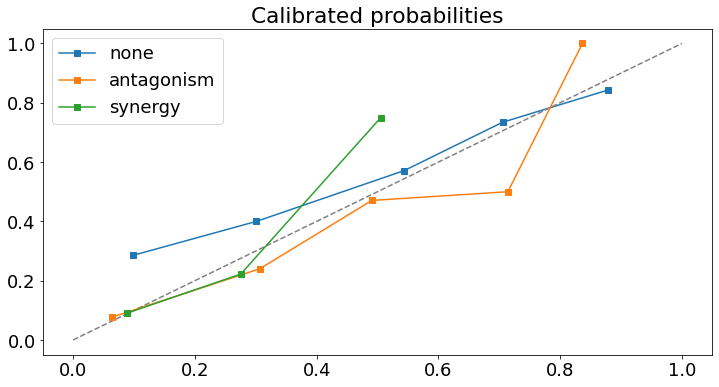

In [58]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value[0], fraction_of_positives[0], 's-', label='none')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(mean_predicted_value[1], fraction_of_positives[1], 's-', label='antagonism')
plt.plot(mean_predicted_value[2], fraction_of_positives[2], 's-', label='synergy')
plt.title('Calibrated probabilities')
plt.legend()

Somehow probability calibration doesn't work for synergy prediction

<a id="test"></a> 
## Generate Predictions on the Test Set

In [59]:
X_drugs = pd.read_csv('../data/chemgenetics/nichols_testset_signed.csv', index_col=0)

In [60]:
X_drugs = X_drugs.iloc[:,np.where(np.isin(X_drugs.columns, gene_subset))[0]]

In [61]:
X_drugs.shape

(45, 350)

In [62]:
test_drugs = X_drugs.index.values

In [63]:
combs_test = list(itertools.combinations(test_drugs, 2))
combs_test = np.array([i[0]+"_"+i[1] for i in combs_test])

In [64]:
len(combs_test)

990

In [65]:
X_test = pd.DataFrame([utl.get_comb_feat_signed(X_drugs, c) for c in combs_test])

In [66]:
X_test = pd.get_dummies(X_test.astype('category'))

In [67]:
X_test.iloc[:10,:12]

,ACRA_-2,ACRA_-1,ACRA_0,ACRA_1,ACRA_2,ACRA_3,ACRB_-2,ACRB_-1,ACRB_0,ACRB_1,ACRB_2,ACRB_3
0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,0,0,1,0,0,0,0
7,0,1,0,0,0,0,0,1,0,0,0,0
8,0,1,0,0,0,0,0,1,0,0,0,0
9,0,1,0,0,0,0,0,1,0,0,0,0


Pad some columns (as some are all zeros in the test set):

In [68]:
X_test.shape

(990, 1179)

In [69]:
cols_pad = np.setdiff1d(X_onehot.columns, X_test.columns)

In [70]:
for col in cols_pad:
    X_test[col] = 0

In [71]:
X_test = X_test.loc[:,np.isin(X_test.columns, X_onehot.columns)]

In [72]:
X_test = X_test[X_onehot.columns]

In [73]:
np.all(X_test.columns == X_onehot.columns)

True

In [74]:
# without probability calibration
y_test_proba = clf.fit(X_onehot, y).predict_proba(X_test)
antag = combs_test[y_test_proba[:,1] > antag_thresh]
syn = combs_test[y_test_proba[:,2] > syn_thresh]

Epoch 1/200
31/31 [==============================] - 0s 942us/step - loss: 0.7658 - accuracy: 0.6452
Epoch 2/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5971 - accuracy: 0.7144
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5160 - accuracy: 0.7506
Epoch 4/200
31/31 [==============================] - 0s 1ms/step - loss: 0.4647 - accuracy: 0.7984
Epoch 5/200
31/31 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.7719
Epoch 6/200
31/31 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.8160
Epoch 7/200
31/31 [==============================] - 0s 876us/step - loss: 0.4370 - accuracy: 0.7964
Epoch 8/200
31/31 [==============================] - 0s 974us/step - loss: 0.4485 - accuracy: 0.7998
Epoch 9/200
31/31 [==============================] - 0s 1ms/step - loss: 0.4086 - accuracy: 0.8068
Epoch 10/200
31/31 [==============================] - 0s 1ms/step - loss: 0.4125 - accuracy: 0.8139
Epo

Epoch 82/200
31/31 [==============================] - 0s 817us/step - loss: 0.0906 - accuracy: 0.9731
Epoch 83/200
31/31 [==============================] - 0s 824us/step - loss: 0.0841 - accuracy: 0.9642
Epoch 84/200
31/31 [==============================] - 0s 806us/step - loss: 0.0762 - accuracy: 0.9741
Epoch 85/200
31/31 [==============================] - 0s 819us/step - loss: 0.1081 - accuracy: 0.9630
Epoch 86/200
31/31 [==============================] - 0s 841us/step - loss: 0.0903 - accuracy: 0.9721
Epoch 87/200
31/31 [==============================] - 0s 804us/step - loss: 0.0762 - accuracy: 0.9721
Epoch 88/200
31/31 [==============================] - 0s 822us/step - loss: 0.0907 - accuracy: 0.9735
Epoch 89/200
31/31 [==============================] - 0s 829us/step - loss: 0.0963 - accuracy: 0.9652
Epoch 90/200
31/31 [==============================] - 0s 818us/step - loss: 0.0769 - accuracy: 0.9730
Epoch 91/200
31/31 [==============================] - 0s 823us/step - loss: 0.0811

31/31 [==============================] - 0s 845us/step - loss: 0.0683 - accuracy: 0.9703
Epoch 163/200
31/31 [==============================] - 0s 817us/step - loss: 0.0528 - accuracy: 0.9828
Epoch 164/200
31/31 [==============================] - 0s 816us/step - loss: 0.0445 - accuracy: 0.9837
Epoch 165/200
31/31 [==============================] - 0s 806us/step - loss: 0.0370 - accuracy: 0.9865
Epoch 166/200
31/31 [==============================] - 0s 807us/step - loss: 0.0384 - accuracy: 0.9867
Epoch 167/200
31/31 [==============================] - 0s 824us/step - loss: 0.0245 - accuracy: 0.9931
Epoch 168/200
31/31 [==============================] - 0s 836us/step - loss: 0.0369 - accuracy: 0.9858
Epoch 169/200
31/31 [==============================] - 0s 791us/step - loss: 0.0428 - accuracy: 0.9829
Epoch 170/200
31/31 [==============================] - 0s 817us/step - loss: 0.0426 - accuracy: 0.9825
Epoch 171/200
31/31 [==============================] - 0s 825us/step - loss: 0.0363 - a

31/31 [==============================] - 0s 993us/step - loss: 0.0998 - accuracy: 0.9695
Epoch 43/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0827 - accuracy: 0.9651
Epoch 44/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1002 - accuracy: 0.9601
Epoch 45/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1044 - accuracy: 0.9729
Epoch 46/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0992 - accuracy: 0.9625
Epoch 47/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1055 - accuracy: 0.9519
Epoch 48/200
31/31 [==============================] - 0s 995us/step - loss: 0.0767 - accuracy: 0.9728
Epoch 49/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0808 - accuracy: 0.9809
Epoch 50/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0870 - accuracy: 0.9610
Epoch 51/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0770 - accuracy: 0.9628
Epoch 52/

31/31 [==============================] - 0s 1ms/step - loss: 0.0243 - accuracy: 0.9952
Epoch 123/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0317 - accuracy: 0.9875
Epoch 124/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0220 - accuracy: 0.9940
Epoch 125/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0293 - accuracy: 0.9865
Epoch 126/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0162 - accuracy: 0.9957
Epoch 127/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0202 - accuracy: 0.9913
Epoch 128/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0337 - accuracy: 0.9890
Epoch 129/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0269 - accuracy: 0.9891
Epoch 130/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0242 - accuracy: 0.9935
Epoch 131/200
31/31 [==============================] - 0s 949us/step - loss: 0.0213 - accuracy: 0.9941
Ep

31/31 [==============================] - 0s 1ms/step - loss: 0.3053 - accuracy: 0.8872
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 0.3678 - accuracy: 0.8632
Epoch 4/200
31/31 [==============================] - 0s 1ms/step - loss: 0.2784 - accuracy: 0.8975
Epoch 5/200
31/31 [==============================] - 0s 931us/step - loss: 0.3156 - accuracy: 0.8910
Epoch 6/200
31/31 [==============================] - 0s 933us/step - loss: 0.2716 - accuracy: 0.8924
Epoch 7/200
31/31 [==============================] - 0s 888us/step - loss: 0.2598 - accuracy: 0.8982
Epoch 8/200
31/31 [==============================] - 0s 912us/step - loss: 0.2925 - accuracy: 0.8797
Epoch 9/200
31/31 [==============================] - 0s 893us/step - loss: 0.2793 - accuracy: 0.8972
Epoch 10/200
31/31 [==============================] - 0s 838us/step - loss: 0.2422 - accuracy: 0.9043
Epoch 11/200
31/31 [==============================] - 0s 851us/step - loss: 0.2293 - accuracy: 0.9097
Epoch 

31/31 [==============================] - 0s 847us/step - loss: 0.0426 - accuracy: 0.9790
Epoch 83/200
31/31 [==============================] - 0s 843us/step - loss: 0.0437 - accuracy: 0.9881
Epoch 84/200
31/31 [==============================] - 0s 963us/step - loss: 0.0390 - accuracy: 0.9906
Epoch 85/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9882
Epoch 86/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0486 - accuracy: 0.9835
Epoch 87/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.9927
Epoch 88/200
31/31 [==============================] - 0s 838us/step - loss: 0.0339 - accuracy: 0.9923
Epoch 89/200
31/31 [==============================] - 0s 854us/step - loss: 0.0356 - accuracy: 0.9863
Epoch 90/200
31/31 [==============================] - 0s 849us/step - loss: 0.0336 - accuracy: 0.9892
Epoch 91/200
31/31 [==============================] - 0s 900us/step - loss: 0.0317 - accuracy: 0.9882

31/31 [==============================] - 0s 830us/step - loss: 0.0165 - accuracy: 0.9978
Epoch 162/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0246 - accuracy: 0.9857
Epoch 163/200
31/31 [==============================] - 0s 982us/step - loss: 0.0118 - accuracy: 0.9946
Epoch 164/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9878
Epoch 165/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0180 - accuracy: 0.9898
Epoch 166/200
31/31 [==============================] - 0s 927us/step - loss: 0.0222 - accuracy: 0.9869
Epoch 167/200
31/31 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0.9891
Epoch 168/200
31/31 [==============================] - 0s 926us/step - loss: 0.0114 - accuracy: 0.9972
Epoch 169/200
31/31 [==============================] - 0s 999us/step - loss: 0.0125 - accuracy: 0.9956
Epoch 170/200
31/31 [==============================] - 0s 963us/step - loss: 0.0114 - accuracy:

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [75]:
np.setdiff1d(antag, syn)

array(['Actinomycin D_Carbenicillin', 'Actinomycin D_Chlorpromazine',
       'Ampicillin_Dibucaine', 'Azidothymidine_Chlorpromazine',
       'Bicyclomycin_Sds', 'Bile_Chlorpromazine',
       'Carbenicillin_Chlorpromazine', 'Carbenicillin_Cholate',
       'Cecropinb_Norfloxacin', 'Cecropinb_Sds',
       'Ceftazidime_Deoxycholate', 'Ceftazidime_Dibucaine',
       'Ceftazidime_Sds', 'Chir090_Chlorpromazine',
       'Chlorpromazine_Ethidiumbromide', 'Chlorpromazine_Norfloxacin',
       'Chlorpromazine_Sds', 'Chlorpromazine_Taurocholate',
       'Chlorpromazine_Tetracycline', 'Chlorpromazine_Uv',
       'Deoxycholate_Sds', 'Methotrexate_Norfloxacin', 'Methotrexate_Sds',
       'Nigericin_Norfloxacin', 'Nigericin_Sds', 'Norfloxacin_Sds',
       'Pms_Sds', 'Sds_Tetracycline', 'Streptomycin_Tetracycline'],
      dtype='<U31')

In [76]:
np.setdiff1d(syn, antag)

array(['Actinomycin D_Deoxycholate', 'Actinomycin D_Ethanol',
       'Ampicillin_Cefoxitin', 'Azidothymidine_Ethanol',
       'Azidothymidine_Sds', 'Cefoxitin_Ceftazidime',
       'Cefoxitin_Taurocholate', 'Cefoxitin_Vancomycin',
       'Ceftazidime_Radicicol', 'Chlorpromazine_Nalidixicacid',
       'Chlorpromazine_Peroxide', 'Chlorpromazine_Vancomycin',
       'Cholate_Norfloxacin', 'Cholate_Radicicol', 'Deoxycholate_Ethanol',
       'Deoxycholate_Nalidixicacid', 'Epinephrine_Peroxide',
       'Epinephrine_Taurocholate', 'Isoniazid_Peroxide',
       'Nalidixicacid_Streptonigrin', 'Radicicol_Taurocholate',
       'Taurocholate_Vancomycin'], dtype='<U31')

In [77]:
np.intersect1d(antag, syn)

array(['Actinomycin D_Taurocholate', 'Sds_Sulfamethizole'], dtype='<U31')

In [78]:
prob_uncalibr = pd.DataFrame(y_test_proba, index=combs_test,
             columns=['none', 'antag', 'synergy'])

In [79]:
prob_uncalibr.to_csv('nichols_test_pred.csv')

In [80]:
prob_uncalibr.sort_values('antag', ascending=False).iloc[:20,:]

,none,antag,synergy
Deoxycholate_Sds,0.000002,0.999906,1.415680e-04
Ceftazidime_Dibucaine,0.000020,0.999878,2.519536e-10
Ceftazidime_Sds,0.000117,0.999718,4.931456e-08
Bicyclomycin_Sds,0.000165,0.999078,2.937713e-02
Norfloxacin_Sds,0.000075,0.999001,8.375962e-04
Carbenicillin_Cholate,0.015052,0.998681,1.490311e-11
Chlorpromazine_Sds,0.005793,0.997589,2.350738e-01
Chlorpromazine_Taurocholate,0.012932,0.989746,1.591111e-02
Azidothymidine_Chlorpromazine,0.105469,0.988430,2.213059e-01
Methotrexate_Norfloxacin,0.437550,0.981116,1.569646e-05


In [81]:
prob_uncalibr.sort_values('synergy', ascending=False).iloc[:20,:]

,none,antag,synergy
Nalidixicacid_Streptonigrin,0.753998,1.889142e-17,0.984839
Cefoxitin_Ceftazidime,0.400368,9.335238e-13,0.973902
Ceftazidime_Radicicol,0.571502,2.626599e-04,0.963931
Azidothymidine_Sds,0.145679,3.704839e-06,0.939499
Epinephrine_Taurocholate,0.078117,7.855433e-06,0.911133
Taurocholate_Vancomycin,0.000047,1.434091e-04,0.896034
Azidothymidine_Ethanol,0.626038,4.617234e-09,0.857221
Ampicillin_Cefoxitin,0.902034,7.833438e-18,0.823103
Cefoxitin_Vancomycin,0.160119,8.189893e-07,0.810583
Radicicol_Taurocholate,0.170094,2.266181e-08,0.807362


In [82]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# with calibration (using stratified KFold for calibrator)
probs = dict()
for i in range(n_classes):
#    clf_calib = CalibratedClassifierCV(clf.estimators_[i], cv=skf, method='isotonic')
    clf_calib = CalibratedClassifierCV(clf, cv=skf, method='isotonic')
    probs[i] = clf_calib.fit(X_onehot, y[:,i]).predict_proba(X_test)

Epoch 1/200
28/28 [==============================] - 0s 974us/step - loss: 0.7114 - accuracy: 0.6558
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.5541 - accuracy: 0.7305
Epoch 3/200
28/28 [==============================] - 0s 962us/step - loss: 0.5448 - accuracy: 0.7245
Epoch 4/200
28/28 [==============================] - 0s 973us/step - loss: 0.5035 - accuracy: 0.7692
Epoch 5/200
28/28 [==============================] - 0s 939us/step - loss: 0.4834 - accuracy: 0.7727
Epoch 6/200
28/28 [==============================] - 0s 940us/step - loss: 0.4587 - accuracy: 0.7839
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4412 - accuracy: 0.8137
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4019 - accuracy: 0.8284
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.8163
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3987 - accuracy: 0.8236

28/28 [==============================] - 0s 2ms/step - loss: 0.0995 - accuracy: 0.9627
Epoch 83/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0791 - accuracy: 0.9772
Epoch 84/200
28/28 [==============================] - 0s 852us/step - loss: 0.0745 - accuracy: 0.9761
Epoch 85/200
28/28 [==============================] - 0s 848us/step - loss: 0.0595 - accuracy: 0.9867
Epoch 86/200
28/28 [==============================] - 0s 836us/step - loss: 0.0680 - accuracy: 0.9772
Epoch 87/200
28/28 [==============================] - 0s 839us/step - loss: 0.0587 - accuracy: 0.9826
Epoch 88/200
28/28 [==============================] - 0s 822us/step - loss: 0.0651 - accuracy: 0.9827
Epoch 89/200
28/28 [==============================] - 0s 857us/step - loss: 0.0741 - accuracy: 0.9776
Epoch 90/200
28/28 [==============================] - 0s 819us/step - loss: 0.0652 - accuracy: 0.9745
Epoch 91/200
28/28 [==============================] - 0s 834us/step - loss: 0.0781 - accuracy: 0.97

28/28 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9939
Epoch 163/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9923
Epoch 164/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0339 - accuracy: 0.9867
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9867
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0434 - accuracy: 0.9865
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0360 - accuracy: 0.9924
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0250 - accuracy: 0.9950
Epoch 169/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.9923
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.9915
Epoch 171/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0280 - accuracy: 0.9936
Epoc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 882us/step - loss: 0.8370 - accuracy: 0.6033
Epoch 2/200
28/28 [==============================] - 0s 885us/step - loss: 0.5862 - accuracy: 0.7083
Epoch 3/200
28/28 [==============================] - 0s 973us/step - loss: 0.5543 - accuracy: 0.7248
Epoch 4/200
28/28 [==============================] - 0s 922us/step - loss: 0.4744 - accuracy: 0.7852
Epoch 5/200
28/28 [==============================] - 0s 882us/step - loss: 0.5007 - accuracy: 0.7701
Epoch 6/200
28/28 [==============================] - 0s 892us/step - loss: 0.4603 - accuracy: 0.8065
Epoch 7/200
28/28 [==============================] - 0s 898us/step - loss: 0.4617 - accuracy: 0.8025
Epoch 8/200
28/28 [==============================] - 0s 859us/step - loss: 0.4655 - accuracy: 0.7939
Epoch 9/200
28/28 [==============================] - 0s 899us/step - loss: 0.4197 - accuracy: 0.8181
Epoch 10/200
28/28 [==============================] - 0s 926us/step - loss: 0.4415 - accuracy: 0.8211
E

28/28 [==============================] - 0s 907us/step - loss: 0.0912 - accuracy: 0.9695
Epoch 82/200
28/28 [==============================] - 0s 851us/step - loss: 0.0811 - accuracy: 0.9754
Epoch 83/200
28/28 [==============================] - 0s 898us/step - loss: 0.0712 - accuracy: 0.9759
Epoch 84/200
28/28 [==============================] - 0s 880us/step - loss: 0.0673 - accuracy: 0.9780
Epoch 85/200
28/28 [==============================] - 0s 889us/step - loss: 0.0852 - accuracy: 0.9711
Epoch 86/200
28/28 [==============================] - 0s 915us/step - loss: 0.0737 - accuracy: 0.9720
Epoch 87/200
28/28 [==============================] - 0s 903us/step - loss: 0.1019 - accuracy: 0.9636
Epoch 88/200
28/28 [==============================] - 0s 879us/step - loss: 0.0641 - accuracy: 0.9791
Epoch 89/200
28/28 [==============================] - 0s 910us/step - loss: 0.0837 - accuracy: 0.9721
Epoch 90/200
28/28 [==============================] - 0s 898us/step - loss: 0.0579 - accuracy: 

28/28 [==============================] - 0s 870us/step - loss: 0.0420 - accuracy: 0.9789
Epoch 161/200
28/28 [==============================] - 0s 938us/step - loss: 0.0419 - accuracy: 0.9820
Epoch 162/200
28/28 [==============================] - 0s 884us/step - loss: 0.0608 - accuracy: 0.9817
Epoch 163/200
28/28 [==============================] - 0s 976us/step - loss: 0.0319 - accuracy: 0.9897
Epoch 164/200
28/28 [==============================] - 0s 915us/step - loss: 0.0517 - accuracy: 0.9885
Epoch 165/200
28/28 [==============================] - 0s 997us/step - loss: 0.0385 - accuracy: 0.9839
Epoch 166/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9925
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0357 - accuracy: 0.9931
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0299 - accuracy: 0.9884
Epoch 169/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy:

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 853us/step - loss: 1.0020 - accuracy: 0.5591
Epoch 2/200
28/28 [==============================] - 0s 897us/step - loss: 0.5695 - accuracy: 0.7436
Epoch 3/200
28/28 [==============================] - 0s 932us/step - loss: 0.5715 - accuracy: 0.7180
Epoch 4/200
28/28 [==============================] - 0s 901us/step - loss: 0.5074 - accuracy: 0.7565
Epoch 5/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4787 - accuracy: 0.7682
Epoch 6/200
28/28 [==============================] - 0s 938us/step - loss: 0.4792 - accuracy: 0.7853
Epoch 7/200
28/28 [==============================] - 0s 917us/step - loss: 0.4413 - accuracy: 0.8127
Epoch 8/200
28/28 [==============================] - 0s 913us/step - loss: 0.4210 - accuracy: 0.8180
Epoch 9/200
28/28 [==============================] - 0s 887us/step - loss: 0.4966 - accuracy: 0.7642
Epoch 10/200
28/28 [==============================] - 0s 951us/step - loss: 0.4060 - accuracy: 0.8281
Epo

28/28 [==============================] - 0s 926us/step - loss: 0.1022 - accuracy: 0.9649
Epoch 82/200
28/28 [==============================] - 0s 942us/step - loss: 0.0915 - accuracy: 0.9648
Epoch 83/200
28/28 [==============================] - 0s 959us/step - loss: 0.0998 - accuracy: 0.9641
Epoch 84/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0898 - accuracy: 0.9749
Epoch 85/200
28/28 [==============================] - 0s 981us/step - loss: 0.0801 - accuracy: 0.9768
Epoch 86/200
28/28 [==============================] - 0s 925us/step - loss: 0.0891 - accuracy: 0.9716
Epoch 87/200
28/28 [==============================] - 0s 938us/step - loss: 0.0948 - accuracy: 0.9729
Epoch 88/200
28/28 [==============================] - 0s 920us/step - loss: 0.1044 - accuracy: 0.9588
Epoch 89/200
28/28 [==============================] - 0s 991us/step - loss: 0.0808 - accuracy: 0.9750
Epoch 90/200
28/28 [==============================] - 0s 937us/step - loss: 0.0635 - accuracy: 0.

28/28 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.9810
Epoch 162/200
28/28 [==============================] - 0s 937us/step - loss: 0.0537 - accuracy: 0.9822
Epoch 163/200
28/28 [==============================] - 0s 936us/step - loss: 0.0456 - accuracy: 0.9847
Epoch 164/200
28/28 [==============================] - 0s 925us/step - loss: 0.0405 - accuracy: 0.9856
Epoch 165/200
28/28 [==============================] - 0s 976us/step - loss: 0.0561 - accuracy: 0.9744
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0434 - accuracy: 0.9827
Epoch 167/200
28/28 [==============================] - 0s 989us/step - loss: 0.0414 - accuracy: 0.9802
Epoch 168/200
28/28 [==============================] - 0s 985us/step - loss: 0.0404 - accuracy: 0.9832
Epoch 169/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0458 - accuracy: 0.9868
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy:

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 862us/step - loss: 0.8035 - accuracy: 0.6289
Epoch 2/200
28/28 [==============================] - 0s 846us/step - loss: 0.5498 - accuracy: 0.7439
Epoch 3/200
28/28 [==============================] - 0s 902us/step - loss: 0.5257 - accuracy: 0.7553
Epoch 4/200
28/28 [==============================] - 0s 918us/step - loss: 0.5420 - accuracy: 0.7413
Epoch 5/200
28/28 [==============================] - 0s 836us/step - loss: 0.4713 - accuracy: 0.8001
Epoch 6/200
28/28 [==============================] - 0s 948us/step - loss: 0.4867 - accuracy: 0.7865
Epoch 7/200
28/28 [==============================] - 0s 943us/step - loss: 0.4617 - accuracy: 0.7747
Epoch 8/200
28/28 [==============================] - 0s 917us/step - loss: 0.4633 - accuracy: 0.7944
Epoch 9/200
28/28 [==============================] - 0s 919us/step - loss: 0.4379 - accuracy: 0.8266
Epoch 10/200
28/28 [==============================] - 0s 916us/step - loss: 0.4508 - accuracy: 0.8018
E

28/28 [==============================] - 0s 1ms/step - loss: 0.1206 - accuracy: 0.9531
Epoch 82/200
28/28 [==============================] - 0s 939us/step - loss: 0.1218 - accuracy: 0.9601
Epoch 83/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0895 - accuracy: 0.9758
Epoch 84/200
28/28 [==============================] - 0s 913us/step - loss: 0.1221 - accuracy: 0.9488
Epoch 85/200
28/28 [==============================] - 0s 924us/step - loss: 0.1105 - accuracy: 0.9557
Epoch 86/200
28/28 [==============================] - 0s 971us/step - loss: 0.0986 - accuracy: 0.9692
Epoch 87/200
28/28 [==============================] - 0s 914us/step - loss: 0.1194 - accuracy: 0.9608
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1307 - accuracy: 0.9357
Epoch 89/200
28/28 [==============================] - 0s 965us/step - loss: 0.1086 - accuracy: 0.9689
Epoch 90/200
28/28 [==============================] - 0s 950us/step - loss: 0.0963 - accuracy: 0.9639

28/28 [==============================] - 0s 926us/step - loss: 0.0509 - accuracy: 0.9768
Epoch 162/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.9833
Epoch 163/200
28/28 [==============================] - 0s 993us/step - loss: 0.0655 - accuracy: 0.9731
Epoch 164/200
28/28 [==============================] - 0s 941us/step - loss: 0.0594 - accuracy: 0.9771
Epoch 165/200
28/28 [==============================] - 0s 938us/step - loss: 0.0744 - accuracy: 0.9684
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0626 - accuracy: 0.9761
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.9654
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9773
Epoch 169/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0909 - accuracy: 0.9626
Epoch 170/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 828us/step - loss: 0.6566 - accuracy: 0.7018
Epoch 2/200
28/28 [==============================] - 0s 883us/step - loss: 0.5493 - accuracy: 0.7264
Epoch 3/200
28/28 [==============================] - 0s 892us/step - loss: 0.5156 - accuracy: 0.7529
Epoch 4/200
28/28 [==============================] - 0s 954us/step - loss: 0.5244 - accuracy: 0.7515
Epoch 5/200
28/28 [==============================] - 0s 880us/step - loss: 0.4427 - accuracy: 0.7898
Epoch 6/200
28/28 [==============================] - 0s 887us/step - loss: 0.4582 - accuracy: 0.7985
Epoch 7/200
28/28 [==============================] - 0s 911us/step - loss: 0.4400 - accuracy: 0.8050
Epoch 8/200
28/28 [==============================] - 0s 910us/step - loss: 0.4126 - accuracy: 0.8326
Epoch 9/200
28/28 [==============================] - 0s 972us/step - loss: 0.3980 - accuracy: 0.8350
Epoch 10/200
28/28 [==============================] - 0s 954us/step - loss: 0.4022 - accuracy: 0.8163
E

28/28 [==============================] - 0s 939us/step - loss: 0.0846 - accuracy: 0.9753
Epoch 82/200
28/28 [==============================] - 0s 888us/step - loss: 0.0762 - accuracy: 0.9742
Epoch 83/200
28/28 [==============================] - 0s 851us/step - loss: 0.0690 - accuracy: 0.9837
Epoch 84/200
28/28 [==============================] - 0s 916us/step - loss: 0.0750 - accuracy: 0.9776
Epoch 85/200
28/28 [==============================] - 0s 951us/step - loss: 0.0839 - accuracy: 0.9694
Epoch 86/200
28/28 [==============================] - 0s 947us/step - loss: 0.0828 - accuracy: 0.9670
Epoch 87/200
28/28 [==============================] - 0s 914us/step - loss: 0.0972 - accuracy: 0.9662
Epoch 88/200
28/28 [==============================] - 0s 910us/step - loss: 0.0658 - accuracy: 0.9789
Epoch 89/200
28/28 [==============================] - 0s 928us/step - loss: 0.0609 - accuracy: 0.9800
Epoch 90/200
28/28 [==============================] - 0s 926us/step - loss: 0.0767 - accuracy: 

28/28 [==============================] - 0s 957us/step - loss: 0.0432 - accuracy: 0.9837
Epoch 161/200
28/28 [==============================] - 0s 864us/step - loss: 0.0518 - accuracy: 0.9838
Epoch 162/200
28/28 [==============================] - 0s 902us/step - loss: 0.0320 - accuracy: 0.9893
Epoch 163/200
28/28 [==============================] - 0s 917us/step - loss: 0.0338 - accuracy: 0.9867
Epoch 164/200
28/28 [==============================] - 0s 984us/step - loss: 0.0299 - accuracy: 0.9917
Epoch 165/200
28/28 [==============================] - 0s 956us/step - loss: 0.0406 - accuracy: 0.9893
Epoch 166/200
28/28 [==============================] - 0s 891us/step - loss: 0.0373 - accuracy: 0.9904
Epoch 167/200
28/28 [==============================] - 0s 896us/step - loss: 0.0357 - accuracy: 0.9875
Epoch 168/200
28/28 [==============================] - 0s 902us/step - loss: 0.0315 - accuracy: 0.9909
Epoch 169/200
28/28 [==============================] - 0s 919us/step - loss: 0.0314 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 881us/step - loss: 0.7521 - accuracy: 0.6365
Epoch 2/200
28/28 [==============================] - 0s 885us/step - loss: 0.5532 - accuracy: 0.7175
Epoch 3/200
28/28 [==============================] - 0s 906us/step - loss: 0.5008 - accuracy: 0.7452
Epoch 4/200
28/28 [==============================] - 0s 901us/step - loss: 0.5035 - accuracy: 0.7770
Epoch 5/200
28/28 [==============================] - 0s 845us/step - loss: 0.4771 - accuracy: 0.7952
Epoch 6/200
28/28 [==============================] - 0s 840us/step - loss: 0.4467 - accuracy: 0.8058
Epoch 7/200
28/28 [==============================] - 0s 926us/step - loss: 0.4382 - accuracy: 0.7910
Epoch 8/200
28/28 [==============================] - 0s 924us/step - loss: 0.4490 - accuracy: 0.7878
Epoch 9/200
28/28 [==============================] - 0s 954us/step - loss: 0.4201 - accuracy: 0.8078
Epoch 10/200
28/28 [==============================] - 0s 935us/step - loss: 0.4105 - accuracy: 0.8326
E

28/28 [==============================] - 0s 883us/step - loss: 0.0985 - accuracy: 0.9666
Epoch 82/200
28/28 [==============================] - 0s 836us/step - loss: 0.1086 - accuracy: 0.9644
Epoch 83/200
28/28 [==============================] - 0s 969us/step - loss: 0.1011 - accuracy: 0.9612
Epoch 84/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0893 - accuracy: 0.9667
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0786 - accuracy: 0.9800
Epoch 86/200
28/28 [==============================] - 0s 872us/step - loss: 0.0959 - accuracy: 0.9593
Epoch 87/200
28/28 [==============================] - 0s 922us/step - loss: 0.0754 - accuracy: 0.9738
Epoch 88/200
28/28 [==============================] - 0s 923us/step - loss: 0.0785 - accuracy: 0.9799
Epoch 89/200
28/28 [==============================] - 0s 930us/step - loss: 0.0650 - accuracy: 0.9797
Epoch 90/200
28/28 [==============================] - 0s 918us/step - loss: 0.0882 - accuracy: 0.96

28/28 [==============================] - 0s 905us/step - loss: 0.0524 - accuracy: 0.9825
Epoch 161/200
28/28 [==============================] - 0s 875us/step - loss: 0.0483 - accuracy: 0.9822
Epoch 162/200
28/28 [==============================] - 0s 828us/step - loss: 0.0441 - accuracy: 0.9902
Epoch 163/200
28/28 [==============================] - 0s 908us/step - loss: 0.0366 - accuracy: 0.9916
Epoch 164/200
28/28 [==============================] - 0s 914us/step - loss: 0.0425 - accuracy: 0.9899
Epoch 165/200
28/28 [==============================] - 0s 936us/step - loss: 0.0360 - accuracy: 0.9863
Epoch 166/200
28/28 [==============================] - 0s 888us/step - loss: 0.0421 - accuracy: 0.9848
Epoch 167/200
28/28 [==============================] - 0s 855us/step - loss: 0.0397 - accuracy: 0.9857
Epoch 168/200
28/28 [==============================] - 0s 955us/step - loss: 0.0618 - accuracy: 0.9754
Epoch 169/200
28/28 [==============================] - 0s 884us/step - loss: 0.0446 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 825us/step - loss: 0.8514 - accuracy: 0.6097
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.5409 - accuracy: 0.7332
Epoch 3/200
28/28 [==============================] - 0s 972us/step - loss: 0.5183 - accuracy: 0.7401
Epoch 4/200
28/28 [==============================] - 0s 987us/step - loss: 0.4809 - accuracy: 0.7784
Epoch 5/200
28/28 [==============================] - 0s 988us/step - loss: 0.5254 - accuracy: 0.7428
Epoch 6/200
28/28 [==============================] - 0s 880us/step - loss: 0.4565 - accuracy: 0.7872
Epoch 7/200
28/28 [==============================] - 0s 986us/step - loss: 0.4522 - accuracy: 0.7953
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.8257
Epoch 9/200
28/28 [==============================] - 0s 891us/step - loss: 0.4352 - accuracy: 0.8124
Epoch 10/200
28/28 [==============================] - 0s 948us/step - loss: 0.4181 - accuracy: 0.8316
Epoch

28/28 [==============================] - 0s 1ms/step - loss: 0.0849 - accuracy: 0.9740
Epoch 83/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1026 - accuracy: 0.9643
Epoch 84/200
28/28 [==============================] - 0s 936us/step - loss: 0.1243 - accuracy: 0.9600
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0755 - accuracy: 0.9766
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0966 - accuracy: 0.9620
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0779 - accuracy: 0.9760
Epoch 88/200
28/28 [==============================] - 0s 975us/step - loss: 0.0928 - accuracy: 0.9610
Epoch 89/200
28/28 [==============================] - 0s 946us/step - loss: 0.0984 - accuracy: 0.9624
Epoch 90/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9621
Epoch 91/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0736 - accuracy: 0.9800
Epoch 9

28/28 [==============================] - 0s 872us/step - loss: 0.0273 - accuracy: 0.9958
Epoch 163/200
28/28 [==============================] - 0s 888us/step - loss: 0.0368 - accuracy: 0.9908
Epoch 164/200
28/28 [==============================] - 0s 937us/step - loss: 0.0441 - accuracy: 0.9910
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0484 - accuracy: 0.9844
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0516 - accuracy: 0.9857
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0473 - accuracy: 0.9852
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0432 - accuracy: 0.9876
Epoch 169/200
28/28 [==============================] - 0s 930us/step - loss: 0.0459 - accuracy: 0.9835
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0378 - accuracy: 0.9888
Epoch 171/200
28/28 [==============================] - 0s 978us/step - loss: 0.0557 - accuracy: 0

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 846us/step - loss: 0.9792 - accuracy: 0.4791
Epoch 2/200
28/28 [==============================] - 0s 981us/step - loss: 0.5816 - accuracy: 0.7173
Epoch 3/200
28/28 [==============================] - 0s 959us/step - loss: 0.5387 - accuracy: 0.7538
Epoch 4/200
28/28 [==============================] - 0s 915us/step - loss: 0.5131 - accuracy: 0.7665
Epoch 5/200
28/28 [==============================] - 0s 958us/step - loss: 0.5118 - accuracy: 0.7438
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4796 - accuracy: 0.7734
Epoch 7/200
28/28 [==============================] - 0s 2ms/step - loss: 0.4724 - accuracy: 0.7768
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4610 - accuracy: 0.7768
Epoch 9/200
28/28 [==============================] - 0s 2ms/step - loss: 0.4410 - accuracy: 0.7911
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4608 - accuracy: 0.7930
Epoch 11/20

28/28 [==============================] - 0s 953us/step - loss: 0.1487 - accuracy: 0.9465
Epoch 83/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1817 - accuracy: 0.9214
Epoch 84/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.9492
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1393 - accuracy: 0.9341
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.9460
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1729 - accuracy: 0.9236
Epoch 88/200
28/28 [==============================] - 0s 900us/step - loss: 0.1683 - accuracy: 0.9316
Epoch 89/200
28/28 [==============================] - 0s 907us/step - loss: 0.1290 - accuracy: 0.9514
Epoch 90/200
28/28 [==============================] - 0s 987us/step - loss: 0.1476 - accuracy: 0.9415
Epoch 91/200
28/28 [==============================] - 0s 950us/step - loss: 0.1177 - accuracy: 0.9642
Epo

28/28 [==============================] - 0s 930us/step - loss: 0.0664 - accuracy: 0.9719
Epoch 163/200
28/28 [==============================] - 0s 956us/step - loss: 0.0843 - accuracy: 0.9681
Epoch 164/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9761
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0799 - accuracy: 0.9602
Epoch 166/200
28/28 [==============================] - 0s 927us/step - loss: 0.0546 - accuracy: 0.9781
Epoch 167/200
28/28 [==============================] - 0s 878us/step - loss: 0.0717 - accuracy: 0.9696
Epoch 168/200
28/28 [==============================] - 0s 895us/step - loss: 0.0523 - accuracy: 0.9799
Epoch 169/200
28/28 [==============================] - 0s 899us/step - loss: 0.0710 - accuracy: 0.9724
Epoch 170/200
28/28 [==============================] - 0s 901us/step - loss: 0.0658 - accuracy: 0.9740
Epoch 171/200
28/28 [==============================] - 0s 1ms/step - loss: 0.1157 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 866us/step - loss: 0.7301 - accuracy: 0.6647
Epoch 2/200
28/28 [==============================] - 0s 864us/step - loss: 0.5397 - accuracy: 0.7348
Epoch 3/200
28/28 [==============================] - 0s 937us/step - loss: 0.5019 - accuracy: 0.7600
Epoch 4/200
28/28 [==============================] - 0s 935us/step - loss: 0.4618 - accuracy: 0.7817
Epoch 5/200
28/28 [==============================] - 0s 987us/step - loss: 0.4715 - accuracy: 0.7923
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4244 - accuracy: 0.8176
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4068 - accuracy: 0.7975
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.7943
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3985 - accuracy: 0.8335
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3815 - accuracy: 0.8276
Epoch 11/20

28/28 [==============================] - 0s 853us/step - loss: 0.1018 - accuracy: 0.9648
Epoch 82/200
28/28 [==============================] - 0s 836us/step - loss: 0.0781 - accuracy: 0.9705
Epoch 83/200
28/28 [==============================] - 0s 867us/step - loss: 0.0973 - accuracy: 0.9607
Epoch 84/200
28/28 [==============================] - 0s 960us/step - loss: 0.0858 - accuracy: 0.9615
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0732 - accuracy: 0.9683
Epoch 86/200
28/28 [==============================] - 0s 884us/step - loss: 0.0740 - accuracy: 0.9821
Epoch 87/200
28/28 [==============================] - 0s 886us/step - loss: 0.0656 - accuracy: 0.9817
Epoch 88/200
28/28 [==============================] - 0s 947us/step - loss: 0.0757 - accuracy: 0.9739
Epoch 89/200
28/28 [==============================] - 0s 887us/step - loss: 0.0847 - accuracy: 0.9778
Epoch 90/200
28/28 [==============================] - 0s 921us/step - loss: 0.0756 - accuracy: 0.

28/28 [==============================] - 0s 848us/step - loss: 0.0314 - accuracy: 0.9903
Epoch 161/200
28/28 [==============================] - 0s 908us/step - loss: 0.0432 - accuracy: 0.9824
Epoch 162/200
28/28 [==============================] - 0s 897us/step - loss: 0.0312 - accuracy: 0.9896
Epoch 163/200
28/28 [==============================] - 0s 906us/step - loss: 0.0342 - accuracy: 0.9866
Epoch 164/200
28/28 [==============================] - 0s 978us/step - loss: 0.0438 - accuracy: 0.9839
Epoch 165/200
28/28 [==============================] - 0s 907us/step - loss: 0.0287 - accuracy: 0.9920
Epoch 166/200
28/28 [==============================] - 0s 937us/step - loss: 0.0416 - accuracy: 0.9857
Epoch 167/200
28/28 [==============================] - 0s 898us/step - loss: 0.0311 - accuracy: 0.9857
Epoch 168/200
28/28 [==============================] - 0s 894us/step - loss: 0.0447 - accuracy: 0.9863
Epoch 169/200
28/28 [==============================] - 0s 894us/step - loss: 0.0400 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 1s 817us/step - loss: 0.7902 - accuracy: 0.6772
Epoch 2/200
28/28 [==============================] - 0s 916us/step - loss: 0.6385 - accuracy: 0.7039
Epoch 3/200
28/28 [==============================] - 0s 923us/step - loss: 0.5598 - accuracy: 0.7191
Epoch 4/200
28/28 [==============================] - 0s 943us/step - loss: 0.4833 - accuracy: 0.7757
Epoch 5/200
28/28 [==============================] - 0s 904us/step - loss: 0.4888 - accuracy: 0.7788
Epoch 6/200
28/28 [==============================] - 0s 857us/step - loss: 0.4664 - accuracy: 0.7505
Epoch 7/200
28/28 [==============================] - 0s 947us/step - loss: 0.4033 - accuracy: 0.8300
Epoch 8/200
28/28 [==============================] - 0s 955us/step - loss: 0.4299 - accuracy: 0.8160
Epoch 9/200
28/28 [==============================] - 0s 916us/step - loss: 0.4228 - accuracy: 0.8211
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3814 - accuracy: 0.8395
Epo

28/28 [==============================] - 0s 1ms/step - loss: 0.0638 - accuracy: 0.9848
Epoch 82/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0626 - accuracy: 0.9837
Epoch 83/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0814 - accuracy: 0.9675
Epoch 84/200
28/28 [==============================] - 0s 997us/step - loss: 0.0865 - accuracy: 0.9663
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0604 - accuracy: 0.9813
Epoch 86/200
28/28 [==============================] - 0s 954us/step - loss: 0.0700 - accuracy: 0.9820
Epoch 87/200
28/28 [==============================] - 0s 932us/step - loss: 0.0588 - accuracy: 0.9799
Epoch 88/200
28/28 [==============================] - 0s 929us/step - loss: 0.0527 - accuracy: 0.9800
Epoch 89/200
28/28 [==============================] - 0s 977us/step - loss: 0.0564 - accuracy: 0.9785
Epoch 90/200
28/28 [==============================] - 0s 966us/step - loss: 0.0730 - accuracy: 0.9753
E

28/28 [==============================] - 0s 1ms/step - loss: 0.0278 - accuracy: 0.9952
Epoch 162/200
28/28 [==============================] - 0s 994us/step - loss: 0.0286 - accuracy: 0.9901
Epoch 163/200
28/28 [==============================] - 0s 938us/step - loss: 0.0400 - accuracy: 0.9824
Epoch 164/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9796
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0367 - accuracy: 0.9902
Epoch 166/200
28/28 [==============================] - 0s 981us/step - loss: 0.0367 - accuracy: 0.9919
Epoch 167/200
28/28 [==============================] - 0s 943us/step - loss: 0.0405 - accuracy: 0.9832
Epoch 168/200
28/28 [==============================] - 0s 956us/step - loss: 0.0402 - accuracy: 0.9869
Epoch 169/200
28/28 [==============================] - 0s 897us/step - loss: 0.0361 - accuracy: 0.9840
Epoch 170/200
28/28 [==============================] - 0s 977us/step - loss: 0.0402 - accurac

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/200
28/28 [==============================] - 0s 1ms/step - loss: 0.6638 - accuracy: 0.7425
Epoch 2/200
28/28 [==============================] - 0s 937us/step - loss: 0.4036 - accuracy: 0.8406
Epoch 3/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4189 - accuracy: 0.8400
Epoch 4/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3632 - accuracy: 0.8557
Epoch 5/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3259 - accuracy: 0.8762
Epoch 6/200
28/28 [==============================] - 0s 948us/step - loss: 0.3609 - accuracy: 0.8399
Epoch 7/200
28/28 [==============================] - 0s 946us/step - loss: 0.3138 - accuracy: 0.8534
Epoch 8/200
28/28 [==============================] - 0s 919us/step - loss: 0.2818 - accuracy: 0.8797
Epoch 9/200
28/28 [==============================] - 0s 910us/step - loss: 0.2778 - accuracy: 0.8839
Epoch 10/200
28/28 [==============================] - 0s 937us/step - loss: 0.2502 - accuracy: 0.89

28/28 [==============================] - 0s 960us/step - loss: 0.0667 - accuracy: 0.9825
Epoch 82/200
28/28 [==============================] - 0s 932us/step - loss: 0.0557 - accuracy: 0.9814
Epoch 83/200
28/28 [==============================] - 0s 947us/step - loss: 0.0466 - accuracy: 0.9872
Epoch 84/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.9915
Epoch 85/200
28/28 [==============================] - 0s 991us/step - loss: 0.0609 - accuracy: 0.9812
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0500 - accuracy: 0.9883
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0438 - accuracy: 0.9924
Epoch 88/200
28/28 [==============================] - 0s 948us/step - loss: 0.0498 - accuracy: 0.9845
Epoch 89/200
28/28 [==============================] - 0s 915us/step - loss: 0.0401 - accuracy: 0.9888
Epoch 90/200
28/28 [==============================] - 0s 915us/step - loss: 0.0470 - accuracy: 0.9917

28/28 [==============================] - 0s 962us/step - loss: 0.0233 - accuracy: 0.9955
Epoch 162/200
28/28 [==============================] - 0s 975us/step - loss: 0.0163 - accuracy: 0.9968
Epoch 163/200
28/28 [==============================] - 0s 945us/step - loss: 0.0303 - accuracy: 0.9896
Epoch 164/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0257 - accuracy: 0.9876
Epoch 165/200
28/28 [==============================] - 0s 972us/step - loss: 0.0229 - accuracy: 0.9894
Epoch 166/200
28/28 [==============================] - 0s 915us/step - loss: 0.0112 - accuracy: 0.9998
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0142 - accuracy: 0.9967
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0271 - accuracy: 0.9879
Epoch 169/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0285 - accuracy: 0.9875
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0189 - accuracy: 0

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 769us/step - loss: 0.6175 - accuracy: 0.7654
Epoch 2/200
28/28 [==============================] - 0s 874us/step - loss: 0.3764 - accuracy: 0.8561
Epoch 3/200
28/28 [==============================] - 0s 892us/step - loss: 0.3664 - accuracy: 0.8534
Epoch 4/200
28/28 [==============================] - 0s 905us/step - loss: 0.3497 - accuracy: 0.8627
Epoch 5/200
28/28 [==============================] - 0s 849us/step - loss: 0.3410 - accuracy: 0.8543
Epoch 6/200
28/28 [==============================] - 0s 854us/step - loss: 0.3251 - accuracy: 0.8553
Epoch 7/200
28/28 [==============================] - 0s 961us/step - loss: 0.3314 - accuracy: 0.8566
Epoch 8/200
28/28 [==============================] - 0s 925us/step - loss: 0.3049 - accuracy: 0.8771
Epoch 9/200
28/28 [==============================] - 0s 911us/step - loss: 0.2936 - accuracy: 0.8838
Epoch 10/200
28/28 [==============================] - 0s 944us/step - loss: 0.2716 - accuracy: 0.8884
E

28/28 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9908
Epoch 82/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0295 - accuracy: 0.9917
Epoch 83/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0208 - accuracy: 0.9995
Epoch 84/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9919
Epoch 85/200
28/28 [==============================] - 0s 998us/step - loss: 0.0303 - accuracy: 0.9916
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0258 - accuracy: 0.9948
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0363 - accuracy: 0.9840
Epoch 88/200
28/28 [==============================] - 0s 957us/step - loss: 0.0285 - accuracy: 0.9963
Epoch 89/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0361 - accuracy: 0.9912
Epoch 90/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9915
Epoch 91/

28/28 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9902
Epoch 163/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9904
Epoch 164/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9910
Epoch 165/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9914
Epoch 166/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9911
Epoch 167/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9897
Epoch 168/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9947
Epoch 169/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9954
Epoch 170/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9957
Epoch 171/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9978
Epoc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.7659 - accuracy: 0.7145
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3822 - accuracy: 0.8479
Epoch 3/200
28/28 [==============================] - 0s 2ms/step - loss: 0.3822 - accuracy: 0.8483
Epoch 4/200
28/28 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8445
Epoch 5/200
28/28 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.8547
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3329 - accuracy: 0.8692
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3162 - accuracy: 0.8701
Epoch 8/200
28/28 [==============================] - 0s 936us/step - loss: 0.3085 - accuracy: 0.8675
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2892 - accuracy: 0.8731
Epoch 10/200
28/28 [==============================] - 0s 997us/step - loss: 0.2700 - accuracy: 0.8944
Epoch 11/200
28/2

28/28 [==============================] - 0s 2ms/step - loss: 0.0448 - accuracy: 0.9864
Epoch 83/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9846
Epoch 84/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.9778
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0446 - accuracy: 0.9852
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0543 - accuracy: 0.9846
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0413 - accuracy: 0.9848
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.9892
Epoch 89/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9877
Epoch 90/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0415 - accuracy: 0.9885
Epoch 91/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0390 - accuracy: 0.9912
Epoch 92/200


28/28 [==============================] - 0s 886us/step - loss: 0.0197 - accuracy: 0.9937
Epoch 163/200
28/28 [==============================] - 0s 913us/step - loss: 0.0242 - accuracy: 0.9896
Epoch 164/200
28/28 [==============================] - 0s 981us/step - loss: 0.0146 - accuracy: 0.9973
Epoch 165/200
28/28 [==============================] - 0s 914us/step - loss: 0.0269 - accuracy: 0.9874
Epoch 166/200
28/28 [==============================] - 0s 884us/step - loss: 0.0201 - accuracy: 0.9965
Epoch 167/200
28/28 [==============================] - 0s 894us/step - loss: 0.0194 - accuracy: 0.9936
Epoch 168/200
28/28 [==============================] - 0s 917us/step - loss: 0.0187 - accuracy: 0.9940
Epoch 169/200
28/28 [==============================] - 0s 925us/step - loss: 0.0288 - accuracy: 0.9897
Epoch 170/200
28/28 [==============================] - 0s 935us/step - loss: 0.0293 - accuracy: 0.9896
Epoch 171/200
28/28 [==============================] - 0s 929us/step - loss: 0.0263 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.5332 - accuracy: 0.8294
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3852 - accuracy: 0.8412
Epoch 3/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3350 - accuracy: 0.8718
Epoch 4/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3293 - accuracy: 0.8553
Epoch 5/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2935 - accuracy: 0.8808
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3026 - accuracy: 0.8702
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.8753
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3065 - accuracy: 0.8658
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2635 - accuracy: 0.8776
Epoch 10/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2773 - accuracy: 0.8861
Epoch 11/200
28/28 [=

28/28 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9870
Epoch 83/200
28/28 [==============================] - 0s 939us/step - loss: 0.0444 - accuracy: 0.9832
Epoch 84/200
28/28 [==============================] - 0s 960us/step - loss: 0.0407 - accuracy: 0.9918
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.9966
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9918
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.9907
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0355 - accuracy: 0.9904
Epoch 89/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9974
Epoch 90/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9946
Epoch 91/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0381 - accuracy: 0.9868
Epoch 92/

28/28 [==============================] - 0s 945us/step - loss: 0.0131 - accuracy: 0.9967
Epoch 163/200
28/28 [==============================] - 0s 953us/step - loss: 0.0191 - accuracy: 0.9920
Epoch 164/200
28/28 [==============================] - 0s 950us/step - loss: 0.0114 - accuracy: 0.9968
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0191 - accuracy: 0.9903
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0239 - accuracy: 0.9880
Epoch 167/200
28/28 [==============================] - 0s 953us/step - loss: 0.0184 - accuracy: 0.9954
Epoch 168/200
28/28 [==============================] - 0s 921us/step - loss: 0.0134 - accuracy: 0.9972
Epoch 169/200
28/28 [==============================] - 0s 880us/step - loss: 0.0128 - accuracy: 0.9965
Epoch 170/200
28/28 [==============================] - 0s 916us/step - loss: 0.0267 - accuracy: 0.9907
Epoch 171/200
28/28 [==============================] - 0s 958us/step - loss: 0.0247 - accur

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 838us/step - loss: 0.6337 - accuracy: 0.7251
Epoch 2/200
28/28 [==============================] - 0s 953us/step - loss: 0.4153 - accuracy: 0.8303
Epoch 3/200
28/28 [==============================] - 0s 951us/step - loss: 0.3780 - accuracy: 0.8581
Epoch 4/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3602 - accuracy: 0.8451
Epoch 5/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3458 - accuracy: 0.8462
Epoch 6/200
28/28 [==============================] - 0s 942us/step - loss: 0.3159 - accuracy: 0.8609
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3244 - accuracy: 0.8629
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2829 - accuracy: 0.8744
Epoch 9/200
28/28 [==============================] - 0s 977us/step - loss: 0.2726 - accuracy: 0.8815
Epoch 10/200
28/28 [==============================] - 0s 929us/step - loss: 0.2741 - accuracy: 0.8991
Epoch 11/

28/28 [==============================] - 0s 963us/step - loss: 0.0554 - accuracy: 0.9846
Epoch 82/200
28/28 [==============================] - 0s 927us/step - loss: 0.0586 - accuracy: 0.9721
Epoch 83/200
28/28 [==============================] - 0s 927us/step - loss: 0.0653 - accuracy: 0.9798
Epoch 84/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9757
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0572 - accuracy: 0.9791
Epoch 86/200
28/28 [==============================] - 0s 918us/step - loss: 0.0481 - accuracy: 0.9841
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0440 - accuracy: 0.9787
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.9954
Epoch 89/200
28/28 [==============================] - 0s 1000us/step - loss: 0.0516 - accuracy: 0.9789
Epoch 90/200
28/28 [==============================] - 0s 919us/step - loss: 0.0496 - accuracy: 0.9863


28/28 [==============================] - 0s 933us/step - loss: 0.0234 - accuracy: 0.9919
Epoch 162/200
28/28 [==============================] - 0s 941us/step - loss: 0.0263 - accuracy: 0.9922
Epoch 163/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0216 - accuracy: 0.9941
Epoch 164/200
28/28 [==============================] - 0s 998us/step - loss: 0.0293 - accuracy: 0.9863
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0203 - accuracy: 0.9931
Epoch 166/200
28/28 [==============================] - 0s 941us/step - loss: 0.0101 - accuracy: 0.9969
Epoch 167/200
28/28 [==============================] - 0s 924us/step - loss: 0.0284 - accuracy: 0.9873
Epoch 168/200
28/28 [==============================] - 0s 898us/step - loss: 0.0215 - accuracy: 0.9915
Epoch 169/200
28/28 [==============================] - 0s 918us/step - loss: 0.0148 - accuracy: 0.9984
Epoch 170/200
28/28 [==============================] - 0s 897us/step - loss: 0.0280 - accur

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 995us/step - loss: 0.6678 - accuracy: 0.7188
Epoch 2/200
28/28 [==============================] - 0s 959us/step - loss: 0.3933 - accuracy: 0.8447
Epoch 3/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3712 - accuracy: 0.8454
Epoch 4/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3553 - accuracy: 0.8563
Epoch 5/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2968 - accuracy: 0.8791
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3327 - accuracy: 0.8611
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3155 - accuracy: 0.8690
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2974 - accuracy: 0.8610
Epoch 9/200
28/28 [==============================] - 0s 832us/step - loss: 0.2857 - accuracy: 0.8881
Epoch 10/200
28/28 [==============================] - 0s 914us/step - loss: 0.2957 - accuracy: 0.8650
Epoch 11/200


28/28 [==============================] - 0s 972us/step - loss: 0.0472 - accuracy: 0.9839
Epoch 82/200
28/28 [==============================] - 0s 985us/step - loss: 0.0516 - accuracy: 0.9813
Epoch 83/200
28/28 [==============================] - 0s 965us/step - loss: 0.0585 - accuracy: 0.9725
Epoch 84/200
28/28 [==============================] - 0s 979us/step - loss: 0.0717 - accuracy: 0.9673
Epoch 85/200
28/28 [==============================] - 0s 940us/step - loss: 0.0543 - accuracy: 0.9814
Epoch 86/200
28/28 [==============================] - 0s 994us/step - loss: 0.0422 - accuracy: 0.9883
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0365 - accuracy: 0.9897
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0505 - accuracy: 0.9872
Epoch 89/200
28/28 [==============================] - 0s 996us/step - loss: 0.0456 - accuracy: 0.9933
Epoch 90/200
28/28 [==============================] - 0s 990us/step - loss: 0.0305 - accuracy: 0.99

28/28 [==============================] - 0s 1ms/step - loss: 0.0116 - accuracy: 0.9971
Epoch 162/200
28/28 [==============================] - 0s 922us/step - loss: 0.0175 - accuracy: 0.9962
Epoch 163/200
28/28 [==============================] - 0s 963us/step - loss: 0.0246 - accuracy: 0.9880
Epoch 164/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0157 - accuracy: 0.9960
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0163 - accuracy: 0.9957
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9974
Epoch 167/200
28/28 [==============================] - 0s 971us/step - loss: 0.0267 - accuracy: 0.9920
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0344 - accuracy: 0.9865
Epoch 169/200
28/28 [==============================] - 0s 939us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0237 - accuracy: 0.9

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.6057 - accuracy: 0.7649
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.4156 - accuracy: 0.8218
Epoch 3/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3482 - accuracy: 0.8639
Epoch 4/200
28/28 [==============================] - 0s 996us/step - loss: 0.3657 - accuracy: 0.8410
Epoch 5/200
28/28 [==============================] - 0s 958us/step - loss: 0.3605 - accuracy: 0.8427
Epoch 6/200
28/28 [==============================] - 0s 984us/step - loss: 0.3027 - accuracy: 0.8711
Epoch 7/200
28/28 [==============================] - 0s 942us/step - loss: 0.3297 - accuracy: 0.8493
Epoch 8/200
28/28 [==============================] - 0s 875us/step - loss: 0.2928 - accuracy: 0.8841
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2795 - accuracy: 0.8795
Epoch 10/200
28/28 [==============================] - 0s 872us/step - loss: 0.2539 - accuracy: 0.8978
Epoch 11/

28/28 [==============================] - 0s 916us/step - loss: 0.0317 - accuracy: 0.9928
Epoch 82/200
28/28 [==============================] - 0s 939us/step - loss: 0.0455 - accuracy: 0.9926
Epoch 83/200
28/28 [==============================] - 0s 887us/step - loss: 0.0395 - accuracy: 0.9872
Epoch 84/200
28/28 [==============================] - 0s 923us/step - loss: 0.0287 - accuracy: 0.9949
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0289 - accuracy: 0.9911
Epoch 86/200
28/28 [==============================] - 0s 990us/step - loss: 0.0326 - accuracy: 0.9953
Epoch 87/200
28/28 [==============================] - 0s 988us/step - loss: 0.0363 - accuracy: 0.9903
Epoch 88/200
28/28 [==============================] - 0s 971us/step - loss: 0.0270 - accuracy: 0.9977
Epoch 89/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0264 - accuracy: 0.9908
Epoch 90/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0473 - accuracy: 0.9910

28/28 [==============================] - 0s 940us/step - loss: 0.0177 - accuracy: 0.9945
Epoch 162/200
28/28 [==============================] - 0s 903us/step - loss: 0.0093 - accuracy: 0.9997
Epoch 163/200
28/28 [==============================] - 0s 950us/step - loss: 0.0238 - accuracy: 0.9886
Epoch 164/200
28/28 [==============================] - 0s 943us/step - loss: 0.0101 - accuracy: 0.9965
Epoch 165/200
28/28 [==============================] - 0s 940us/step - loss: 0.0174 - accuracy: 0.9940
Epoch 166/200
28/28 [==============================] - 0s 891us/step - loss: 0.0301 - accuracy: 0.9918
Epoch 167/200
28/28 [==============================] - 0s 885us/step - loss: 0.0217 - accuracy: 0.9869
Epoch 168/200
28/28 [==============================] - 0s 911us/step - loss: 0.0141 - accuracy: 0.9945
Epoch 169/200
28/28 [==============================] - 0s 971us/step - loss: 0.0088 - accuracy: 0.9985
Epoch 170/200
28/28 [==============================] - 0s 938us/step - loss: 0.0092 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 960us/step - loss: 0.6503 - accuracy: 0.7114
Epoch 2/200
28/28 [==============================] - 0s 828us/step - loss: 0.4339 - accuracy: 0.8249
Epoch 3/200
28/28 [==============================] - 0s 941us/step - loss: 0.4094 - accuracy: 0.8253
Epoch 4/200
28/28 [==============================] - 0s 896us/step - loss: 0.3225 - accuracy: 0.8662
Epoch 5/200
28/28 [==============================] - 0s 875us/step - loss: 0.3269 - accuracy: 0.8574
Epoch 6/200
28/28 [==============================] - 0s 935us/step - loss: 0.3334 - accuracy: 0.8542
Epoch 7/200
28/28 [==============================] - 0s 916us/step - loss: 0.2972 - accuracy: 0.8796
Epoch 8/200
28/28 [==============================] - 0s 935us/step - loss: 0.2733 - accuracy: 0.8724
Epoch 9/200
28/28 [==============================] - 0s 859us/step - loss: 0.2700 - accuracy: 0.8899
Epoch 10/200
28/28 [==============================] - 0s 904us/step - loss: 0.2956 - accuracy: 0.8614
E

Epoch 82/200
28/28 [==============================] - 0s 840us/step - loss: 0.0305 - accuracy: 0.9958
Epoch 83/200
28/28 [==============================] - 0s 863us/step - loss: 0.0398 - accuracy: 0.9874
Epoch 84/200
28/28 [==============================] - 0s 976us/step - loss: 0.0446 - accuracy: 0.9881
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0344 - accuracy: 0.9956
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0467 - accuracy: 0.9861
Epoch 87/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0349 - accuracy: 0.9934
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.9909
Epoch 89/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9809
Epoch 90/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0369 - accuracy: 0.9951
Epoch 91/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0372 - accuracy: 0

28/28 [==============================] - 0s 821us/step - loss: 0.0180 - accuracy: 0.9937
Epoch 163/200
28/28 [==============================] - 0s 840us/step - loss: 0.0142 - accuracy: 0.9953
Epoch 164/200
28/28 [==============================] - 0s 822us/step - loss: 0.0165 - accuracy: 0.9938
Epoch 165/200
28/28 [==============================] - 0s 881us/step - loss: 0.0318 - accuracy: 0.9874
Epoch 166/200
28/28 [==============================] - 0s 810us/step - loss: 0.0313 - accuracy: 0.9898
Epoch 167/200
28/28 [==============================] - 0s 823us/step - loss: 0.0193 - accuracy: 0.9965
Epoch 168/200
28/28 [==============================] - 0s 825us/step - loss: 0.0228 - accuracy: 0.9946
Epoch 169/200
28/28 [==============================] - 0s 854us/step - loss: 0.0189 - accuracy: 0.9966
Epoch 170/200
28/28 [==============================] - 0s 826us/step - loss: 0.0144 - accuracy: 1.0000
Epoch 171/200
28/28 [==============================] - 0s 868us/step - loss: 0.0132 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 889us/step - loss: 0.7336 - accuracy: 0.6773
Epoch 2/200
28/28 [==============================] - 0s 835us/step - loss: 0.4381 - accuracy: 0.8138
Epoch 3/200
28/28 [==============================] - 0s 836us/step - loss: 0.3963 - accuracy: 0.8295
Epoch 4/200
28/28 [==============================] - 0s 841us/step - loss: 0.3425 - accuracy: 0.8545
Epoch 5/200
28/28 [==============================] - 0s 828us/step - loss: 0.3272 - accuracy: 0.8486
Epoch 6/200
28/28 [==============================] - 0s 840us/step - loss: 0.2947 - accuracy: 0.8760
Epoch 7/200
28/28 [==============================] - 0s 818us/step - loss: 0.3000 - accuracy: 0.8652
Epoch 8/200
28/28 [==============================] - 0s 863us/step - loss: 0.2803 - accuracy: 0.8750
Epoch 9/200
28/28 [==============================] - 0s 799us/step - loss: 0.2575 - accuracy: 0.8922
Epoch 10/200
28/28 [==============================] - 0s 847us/step - loss: 0.2484 - accuracy: 0.8926
E

28/28 [==============================] - 0s 813us/step - loss: 0.0456 - accuracy: 0.9879
Epoch 82/200
28/28 [==============================] - 0s 851us/step - loss: 0.0629 - accuracy: 0.9743
Epoch 83/200
28/28 [==============================] - 0s 817us/step - loss: 0.0509 - accuracy: 0.9833
Epoch 84/200
28/28 [==============================] - 0s 860us/step - loss: 0.0459 - accuracy: 0.9839
Epoch 85/200
28/28 [==============================] - 0s 839us/step - loss: 0.0444 - accuracy: 0.9855
Epoch 86/200
28/28 [==============================] - 0s 826us/step - loss: 0.0500 - accuracy: 0.9897
Epoch 87/200
28/28 [==============================] - 0s 837us/step - loss: 0.0390 - accuracy: 0.9905
Epoch 88/200
28/28 [==============================] - 0s 837us/step - loss: 0.0336 - accuracy: 0.9911
Epoch 89/200
28/28 [==============================] - 0s 829us/step - loss: 0.0476 - accuracy: 0.9878
Epoch 90/200
28/28 [==============================] - 0s 826us/step - loss: 0.0350 - accuracy: 

28/28 [==============================] - 0s 812us/step - loss: 0.0325 - accuracy: 0.9908
Epoch 161/200
28/28 [==============================] - 0s 826us/step - loss: 0.0299 - accuracy: 0.9904
Epoch 162/200
28/28 [==============================] - 0s 840us/step - loss: 0.0278 - accuracy: 0.9877
Epoch 163/200
28/28 [==============================] - 0s 875us/step - loss: 0.0189 - accuracy: 0.9943
Epoch 164/200
28/28 [==============================] - 0s 806us/step - loss: 0.0215 - accuracy: 0.9944
Epoch 165/200
28/28 [==============================] - 0s 877us/step - loss: 0.0221 - accuracy: 0.9962
Epoch 166/200
28/28 [==============================] - 0s 821us/step - loss: 0.0217 - accuracy: 0.9937
Epoch 167/200
28/28 [==============================] - 0s 832us/step - loss: 0.0191 - accuracy: 0.9944
Epoch 168/200
28/28 [==============================] - 0s 870us/step - loss: 0.0183 - accuracy: 0.9913
Epoch 169/200
28/28 [==============================] - 0s 819us/step - loss: 0.0129 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 956us/step - loss: 0.6098 - accuracy: 0.7350
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3931 - accuracy: 0.8411
Epoch 3/200
28/28 [==============================] - 0s 991us/step - loss: 0.3207 - accuracy: 0.8687
Epoch 4/200
28/28 [==============================] - 0s 964us/step - loss: 0.3389 - accuracy: 0.8673
Epoch 5/200
28/28 [==============================] - 0s 936us/step - loss: 0.2848 - accuracy: 0.8836
Epoch 6/200
28/28 [==============================] - 0s 872us/step - loss: 0.2841 - accuracy: 0.8697
Epoch 7/200
28/28 [==============================] - 0s 936us/step - loss: 0.2995 - accuracy: 0.8792
Epoch 8/200
28/28 [==============================] - 0s 890us/step - loss: 0.3100 - accuracy: 0.8765
Epoch 9/200
28/28 [==============================] - 0s 919us/step - loss: 0.2707 - accuracy: 0.8894
Epoch 10/200
28/28 [==============================] - 0s 915us/step - loss: 0.2384 - accuracy: 0.8956
Epo

28/28 [==============================] - 0s 805us/step - loss: 0.0331 - accuracy: 0.9884
Epoch 83/200
28/28 [==============================] - 0s 802us/step - loss: 0.0578 - accuracy: 0.9788
Epoch 84/200
28/28 [==============================] - 0s 804us/step - loss: 0.0388 - accuracy: 0.9875
Epoch 85/200
28/28 [==============================] - 0s 868us/step - loss: 0.0251 - accuracy: 0.9975
Epoch 86/200
28/28 [==============================] - 0s 851us/step - loss: 0.0352 - accuracy: 0.9946
Epoch 87/200
28/28 [==============================] - 0s 833us/step - loss: 0.0399 - accuracy: 0.9956
Epoch 88/200
28/28 [==============================] - 0s 873us/step - loss: 0.0332 - accuracy: 0.9877
Epoch 89/200
28/28 [==============================] - 0s 835us/step - loss: 0.0289 - accuracy: 0.9905
Epoch 90/200
28/28 [==============================] - 0s 872us/step - loss: 0.0349 - accuracy: 0.9914
Epoch 91/200
28/28 [==============================] - 0s 821us/step - loss: 0.0313 - accuracy: 

28/28 [==============================] - 0s 999us/step - loss: 0.0183 - accuracy: 0.9912
Epoch 163/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0196 - accuracy: 0.9933
Epoch 164/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9997
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0089 - accuracy: 0.9987
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 0.9968
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 0.9994
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0131 - accuracy: 0.9980
Epoch 169/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0242 - accuracy: 0.9919
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0136 - accuracy: 0.9979
Epoch 171/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.9967
Ep

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/200
28/28 [==============================] - 0s 842us/step - loss: 0.6026 - accuracy: 0.7742
Epoch 2/200
28/28 [==============================] - 0s 819us/step - loss: 0.3807 - accuracy: 0.8751
Epoch 3/200
28/28 [==============================] - 0s 844us/step - loss: 0.3297 - accuracy: 0.8869
Epoch 4/200
28/28 [==============================] - 0s 841us/step - loss: 0.3293 - accuracy: 0.8778
Epoch 5/200
28/28 [==============================] - 0s 835us/step - loss: 0.3629 - accuracy: 0.8658
Epoch 6/200
28/28 [==============================] - 0s 830us/step - loss: 0.3019 - accuracy: 0.8820
Epoch 7/200
28/28 [==============================] - 0s 844us/step - loss: 0.2687 - accuracy: 0.9131
Epoch 8/200
28/28 [==============================] - 0s 845us/step - loss: 0.2661 - accuracy: 0.9026
Epoch 9/200
28/28 [==============================] - 0s 864us/step - loss: 0.2439 - accuracy: 0.9144
Epoch 10/200
28/28 [==============================] - 0s 817us/step - loss: 0.2349 - accura

28/28 [==============================] - 0s 825us/step - loss: 0.0486 - accuracy: 0.9786
Epoch 82/200
28/28 [==============================] - 0s 847us/step - loss: 0.0453 - accuracy: 0.9862
Epoch 83/200
28/28 [==============================] - 0s 830us/step - loss: 0.0257 - accuracy: 0.9927
Epoch 84/200
28/28 [==============================] - 0s 852us/step - loss: 0.0276 - accuracy: 0.9941
Epoch 85/200
28/28 [==============================] - 0s 849us/step - loss: 0.0305 - accuracy: 0.9905
Epoch 86/200
28/28 [==============================] - 0s 849us/step - loss: 0.0332 - accuracy: 0.9888
Epoch 87/200
28/28 [==============================] - 0s 819us/step - loss: 0.0361 - accuracy: 0.9885
Epoch 88/200
28/28 [==============================] - 0s 838us/step - loss: 0.0337 - accuracy: 0.9944
Epoch 89/200
28/28 [==============================] - 0s 837us/step - loss: 0.0327 - accuracy: 0.9918
Epoch 90/200
28/28 [==============================] - 0s 862us/step - loss: 0.0365 - accuracy: 

28/28 [==============================] - 0s 882us/step - loss: 0.0095 - accuracy: 0.9994
Epoch 162/200
28/28 [==============================] - 0s 859us/step - loss: 0.0349 - accuracy: 0.9907
Epoch 163/200
28/28 [==============================] - 0s 877us/step - loss: 0.0224 - accuracy: 0.9934
Epoch 164/200
28/28 [==============================] - 0s 937us/step - loss: 0.0208 - accuracy: 0.9954
Epoch 165/200
28/28 [==============================] - 0s 955us/step - loss: 0.0211 - accuracy: 0.9923
Epoch 166/200
28/28 [==============================] - 0s 878us/step - loss: 0.0285 - accuracy: 0.9885
Epoch 167/200
28/28 [==============================] - 0s 972us/step - loss: 0.0197 - accuracy: 0.9922
Epoch 168/200
28/28 [==============================] - 0s 892us/step - loss: 0.0203 - accuracy: 0.9937
Epoch 169/200
28/28 [==============================] - 0s 939us/step - loss: 0.0171 - accuracy: 0.9919
Epoch 170/200
28/28 [==============================] - 0s 929us/step - loss: 0.0378 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 827us/step - loss: 0.5579 - accuracy: 0.7783
Epoch 2/200
28/28 [==============================] - 0s 893us/step - loss: 0.3504 - accuracy: 0.8791
Epoch 3/200
28/28 [==============================] - 0s 935us/step - loss: 0.3251 - accuracy: 0.8940
Epoch 4/200
28/28 [==============================] - 0s 896us/step - loss: 0.3322 - accuracy: 0.8781
Epoch 5/200
28/28 [==============================] - 0s 905us/step - loss: 0.3007 - accuracy: 0.8782
Epoch 6/200
28/28 [==============================] - 0s 897us/step - loss: 0.3147 - accuracy: 0.8798
Epoch 7/200
28/28 [==============================] - 0s 891us/step - loss: 0.2662 - accuracy: 0.8911
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2663 - accuracy: 0.8958
Epoch 9/200
28/28 [==============================] - 0s 923us/step - loss: 0.2687 - accuracy: 0.8928
Epoch 10/200
28/28 [==============================] - 0s 937us/step - loss: 0.2364 - accuracy: 0.9047
Epo

28/28 [==============================] - 0s 851us/step - loss: 0.0519 - accuracy: 0.9829
Epoch 82/200
28/28 [==============================] - 0s 876us/step - loss: 0.0483 - accuracy: 0.9849
Epoch 83/200
28/28 [==============================] - 0s 870us/step - loss: 0.0452 - accuracy: 0.9857
Epoch 84/200
28/28 [==============================] - 0s 903us/step - loss: 0.0378 - accuracy: 0.9876
Epoch 85/200
28/28 [==============================] - 0s 874us/step - loss: 0.0390 - accuracy: 0.9896
Epoch 86/200
28/28 [==============================] - 0s 881us/step - loss: 0.0405 - accuracy: 0.9864
Epoch 87/200
28/28 [==============================] - 0s 937us/step - loss: 0.0380 - accuracy: 0.9856
Epoch 88/200
28/28 [==============================] - 0s 908us/step - loss: 0.0331 - accuracy: 0.9912
Epoch 89/200
28/28 [==============================] - 0s 920us/step - loss: 0.0419 - accuracy: 0.9903
Epoch 90/200
28/28 [==============================] - 0s 925us/step - loss: 0.0329 - accuracy: 

28/28 [==============================] - 0s 1ms/step - loss: 0.0121 - accuracy: 0.9961
Epoch 162/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0163 - accuracy: 0.9963
Epoch 163/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0142 - accuracy: 0.9966
Epoch 164/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0130 - accuracy: 0.9990
Epoch 165/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0153 - accuracy: 0.9948
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.9939
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0246 - accuracy: 0.9899
Epoch 168/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0203 - accuracy: 0.9952
Epoch 169/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0205 - accuracy: 0.9899
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0186 - accuracy: 0.9962
Epoc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.8547 - accuracy: 0.6824
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3967 - accuracy: 0.8628
Epoch 3/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3166 - accuracy: 0.8884
Epoch 4/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3024 - accuracy: 0.8789
Epoch 5/200
28/28 [==============================] - 0s 904us/step - loss: 0.3069 - accuracy: 0.8854
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2974 - accuracy: 0.9019
Epoch 7/200
28/28 [==============================] - 0s 890us/step - loss: 0.2555 - accuracy: 0.9009
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2473 - accuracy: 0.9151
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2360 - accuracy: 0.9140
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2612 - accuracy: 0.9063
Epoch 11/200
28/2

28/28 [==============================] - 0s 897us/step - loss: 0.0309 - accuracy: 0.9885
Epoch 83/200
28/28 [==============================] - 0s 929us/step - loss: 0.0343 - accuracy: 0.9896
Epoch 84/200
28/28 [==============================] - 0s 928us/step - loss: 0.0327 - accuracy: 0.9895
Epoch 85/200
28/28 [==============================] - 0s 960us/step - loss: 0.0305 - accuracy: 0.9874
Epoch 86/200
28/28 [==============================] - 0s 943us/step - loss: 0.0301 - accuracy: 0.9929
Epoch 87/200
28/28 [==============================] - 0s 920us/step - loss: 0.0453 - accuracy: 0.9855
Epoch 88/200
28/28 [==============================] - 0s 866us/step - loss: 0.0297 - accuracy: 0.9862
Epoch 89/200
28/28 [==============================] - 0s 918us/step - loss: 0.0334 - accuracy: 0.9885
Epoch 90/200
28/28 [==============================] - 0s 925us/step - loss: 0.0349 - accuracy: 0.9895
Epoch 91/200
28/28 [==============================] - 0s 904us/step - loss: 0.0322 - accuracy: 

28/28 [==============================] - 0s 998us/step - loss: 0.0223 - accuracy: 0.9937
Epoch 163/200
28/28 [==============================] - 0s 939us/step - loss: 0.0118 - accuracy: 0.9988
Epoch 164/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9941
Epoch 165/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9945
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0116 - accuracy: 0.9963
Epoch 167/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 0.9989
Epoch 168/200
28/28 [==============================] - 0s 978us/step - loss: 0.0177 - accuracy: 0.9894
Epoch 169/200
28/28 [==============================] - 0s 900us/step - loss: 0.0190 - accuracy: 0.9919
Epoch 170/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0205 - accuracy: 0.9916
Epoch 171/200
28/28 [==============================] - 0s 877us/step - loss: 0.0095 - accuracy: 0

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 1s 782us/step - loss: 0.7853 - accuracy: 0.7093
Epoch 2/200
28/28 [==============================] - 0s 884us/step - loss: 0.3918 - accuracy: 0.8656
Epoch 3/200
28/28 [==============================] - 0s 926us/step - loss: 0.3577 - accuracy: 0.8726
Epoch 4/200
28/28 [==============================] - 0s 947us/step - loss: 0.3731 - accuracy: 0.8644
Epoch 5/200
28/28 [==============================] - 0s 886us/step - loss: 0.3552 - accuracy: 0.8728
Epoch 6/200
28/28 [==============================] - 0s 906us/step - loss: 0.2863 - accuracy: 0.8955
Epoch 7/200
28/28 [==============================] - 0s 883us/step - loss: 0.3482 - accuracy: 0.8677
Epoch 8/200
28/28 [==============================] - 0s 893us/step - loss: 0.3073 - accuracy: 0.8865
Epoch 9/200
28/28 [==============================] - 0s 900us/step - loss: 0.2653 - accuracy: 0.8977
Epoch 10/200
28/28 [==============================] - 0s 950us/step - loss: 0.2895 - accuracy: 0.8860
E

28/28 [==============================] - 0s 882us/step - loss: 0.0957 - accuracy: 0.9570
Epoch 82/200
28/28 [==============================] - 0s 867us/step - loss: 0.0824 - accuracy: 0.9686
Epoch 83/200
28/28 [==============================] - 0s 883us/step - loss: 0.0845 - accuracy: 0.9652
Epoch 84/200
28/28 [==============================] - 0s 916us/step - loss: 0.0654 - accuracy: 0.9771
Epoch 85/200
28/28 [==============================] - 0s 941us/step - loss: 0.0720 - accuracy: 0.9691
Epoch 86/200
28/28 [==============================] - 0s 957us/step - loss: 0.0706 - accuracy: 0.9693
Epoch 87/200
28/28 [==============================] - 0s 894us/step - loss: 0.0649 - accuracy: 0.9820
Epoch 88/200
28/28 [==============================] - 0s 876us/step - loss: 0.0611 - accuracy: 0.9863
Epoch 89/200
28/28 [==============================] - 0s 887us/step - loss: 0.0923 - accuracy: 0.9665
Epoch 90/200
28/28 [==============================] - 0s 901us/step - loss: 0.0944 - accuracy: 

28/28 [==============================] - 0s 1ms/step - loss: 0.0292 - accuracy: 0.9926
Epoch 162/200
28/28 [==============================] - 0s 851us/step - loss: 0.0301 - accuracy: 0.9917
Epoch 163/200
28/28 [==============================] - 0s 898us/step - loss: 0.0409 - accuracy: 0.9863
Epoch 164/200
28/28 [==============================] - 0s 982us/step - loss: 0.0484 - accuracy: 0.9880
Epoch 165/200
28/28 [==============================] - 0s 900us/step - loss: 0.0327 - accuracy: 0.9883
Epoch 166/200
28/28 [==============================] - 0s 908us/step - loss: 0.0294 - accuracy: 0.9892
Epoch 167/200
28/28 [==============================] - 0s 938us/step - loss: 0.0423 - accuracy: 0.9878
Epoch 168/200
28/28 [==============================] - 0s 928us/step - loss: 0.0267 - accuracy: 0.9955
Epoch 169/200
28/28 [==============================] - 0s 911us/step - loss: 0.0533 - accuracy: 0.9825
Epoch 170/200
28/28 [==============================] - 0s 850us/step - loss: 0.0312 - acc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 849us/step - loss: 0.5387 - accuracy: 0.8268
Epoch 2/200
28/28 [==============================] - 0s 861us/step - loss: 0.3531 - accuracy: 0.8861
Epoch 3/200
28/28 [==============================] - 0s 885us/step - loss: 0.3112 - accuracy: 0.8934
Epoch 4/200
28/28 [==============================] - 0s 907us/step - loss: 0.3053 - accuracy: 0.8851
Epoch 5/200
28/28 [==============================] - 0s 891us/step - loss: 0.2960 - accuracy: 0.8874
Epoch 6/200
28/28 [==============================] - 0s 919us/step - loss: 0.3210 - accuracy: 0.8655
Epoch 7/200
28/28 [==============================] - 0s 906us/step - loss: 0.2859 - accuracy: 0.8878
Epoch 8/200
28/28 [==============================] - 0s 901us/step - loss: 0.2908 - accuracy: 0.8817
Epoch 9/200
28/28 [==============================] - 0s 915us/step - loss: 0.2797 - accuracy: 0.8860
Epoch 10/200
28/28 [==============================] - 0s 867us/step - loss: 0.2772 - accuracy: 0.8873
E

28/28 [==============================] - 0s 845us/step - loss: 0.0543 - accuracy: 0.9825
Epoch 82/200
28/28 [==============================] - 0s 881us/step - loss: 0.0461 - accuracy: 0.9849
Epoch 83/200
28/28 [==============================] - 0s 900us/step - loss: 0.0545 - accuracy: 0.9817
Epoch 84/200
28/28 [==============================] - 0s 890us/step - loss: 0.0490 - accuracy: 0.9895
Epoch 85/200
28/28 [==============================] - 0s 896us/step - loss: 0.0478 - accuracy: 0.9808
Epoch 86/200
28/28 [==============================] - 0s 898us/step - loss: 0.0691 - accuracy: 0.9818
Epoch 87/200
28/28 [==============================] - 0s 860us/step - loss: 0.0440 - accuracy: 0.9865
Epoch 88/200
28/28 [==============================] - 0s 911us/step - loss: 0.0648 - accuracy: 0.9741
Epoch 89/200
28/28 [==============================] - 0s 870us/step - loss: 0.0443 - accuracy: 0.9889
Epoch 90/200
28/28 [==============================] - 0s 901us/step - loss: 0.0523 - accuracy: 

28/28 [==============================] - 0s 887us/step - loss: 0.0282 - accuracy: 0.9934
Epoch 161/200
28/28 [==============================] - 0s 901us/step - loss: 0.0205 - accuracy: 0.9973
Epoch 162/200
28/28 [==============================] - 0s 847us/step - loss: 0.0203 - accuracy: 0.9945
Epoch 163/200
28/28 [==============================] - 0s 937us/step - loss: 0.0267 - accuracy: 0.9909
Epoch 164/200
28/28 [==============================] - 0s 858us/step - loss: 0.0220 - accuracy: 0.9946
Epoch 165/200
28/28 [==============================] - 0s 910us/step - loss: 0.0290 - accuracy: 0.9895
Epoch 166/200
28/28 [==============================] - 0s 864us/step - loss: 0.0159 - accuracy: 0.9970
Epoch 167/200
28/28 [==============================] - 0s 941us/step - loss: 0.0307 - accuracy: 0.9915
Epoch 168/200
28/28 [==============================] - 0s 912us/step - loss: 0.0214 - accuracy: 0.9973
Epoch 169/200
28/28 [==============================] - 0s 892us/step - loss: 0.0168 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 826us/step - loss: 0.3930 - accuracy: 0.8850
Epoch 2/200
28/28 [==============================] - 0s 908us/step - loss: 0.3272 - accuracy: 0.8880
Epoch 3/200
28/28 [==============================] - 0s 869us/step - loss: 0.3250 - accuracy: 0.8846
Epoch 4/200
28/28 [==============================] - 0s 888us/step - loss: 0.3023 - accuracy: 0.8881
Epoch 5/200
28/28 [==============================] - 0s 925us/step - loss: 0.2732 - accuracy: 0.9009
Epoch 6/200
28/28 [==============================] - 0s 892us/step - loss: 0.2930 - accuracy: 0.8818
Epoch 7/200
28/28 [==============================] - 0s 862us/step - loss: 0.2671 - accuracy: 0.8947
Epoch 8/200
28/28 [==============================] - 0s 922us/step - loss: 0.2613 - accuracy: 0.9104
Epoch 9/200
28/28 [==============================] - 0s 865us/step - loss: 0.2573 - accuracy: 0.9015
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2477 - accuracy: 0.9122
Epo

28/28 [==============================] - 0s 819us/step - loss: 0.0200 - accuracy: 0.9937
Epoch 82/200
28/28 [==============================] - 0s 893us/step - loss: 0.0309 - accuracy: 0.9903
Epoch 83/200
28/28 [==============================] - 0s 918us/step - loss: 0.0244 - accuracy: 0.9900
Epoch 84/200
28/28 [==============================] - 0s 880us/step - loss: 0.0338 - accuracy: 0.9903
Epoch 85/200
28/28 [==============================] - 0s 917us/step - loss: 0.0216 - accuracy: 0.9957
Epoch 86/200
28/28 [==============================] - 0s 910us/step - loss: 0.0162 - accuracy: 0.9984
Epoch 87/200
28/28 [==============================] - 0s 918us/step - loss: 0.0200 - accuracy: 0.9944
Epoch 88/200
28/28 [==============================] - 0s 908us/step - loss: 0.0213 - accuracy: 0.9955
Epoch 89/200
28/28 [==============================] - 0s 911us/step - loss: 0.0215 - accuracy: 0.9955
Epoch 90/200
28/28 [==============================] - 0s 873us/step - loss: 0.0228 - accuracy: 

28/28 [==============================] - 0s 853us/step - loss: 0.0099 - accuracy: 0.9997
Epoch 161/200
28/28 [==============================] - 0s 824us/step - loss: 0.0099 - accuracy: 0.9985
Epoch 162/200
28/28 [==============================] - 0s 917us/step - loss: 0.0096 - accuracy: 0.9941
Epoch 163/200
28/28 [==============================] - 0s 925us/step - loss: 0.0092 - accuracy: 0.9966
Epoch 164/200
28/28 [==============================] - 0s 904us/step - loss: 0.0117 - accuracy: 0.9942
Epoch 165/200
28/28 [==============================] - 0s 898us/step - loss: 0.0094 - accuracy: 0.9959
Epoch 166/200
28/28 [==============================] - 0s 877us/step - loss: 0.0084 - accuracy: 0.9988
Epoch 167/200
28/28 [==============================] - 0s 899us/step - loss: 0.0170 - accuracy: 0.9948
Epoch 168/200
28/28 [==============================] - 0s 894us/step - loss: 0.0106 - accuracy: 0.9982
Epoch 169/200
28/28 [==============================] - 0s 928us/step - loss: 0.0108 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 783us/step - loss: 0.4982 - accuracy: 0.8299
Epoch 2/200
28/28 [==============================] - 0s 858us/step - loss: 0.3448 - accuracy: 0.8839
Epoch 3/200
28/28 [==============================] - 0s 904us/step - loss: 0.3185 - accuracy: 0.8787
Epoch 4/200
28/28 [==============================] - 0s 889us/step - loss: 0.3117 - accuracy: 0.8737
Epoch 5/200
28/28 [==============================] - 0s 932us/step - loss: 0.3114 - accuracy: 0.8858
Epoch 6/200
28/28 [==============================] - 0s 898us/step - loss: 0.2831 - accuracy: 0.9023
Epoch 7/200
28/28 [==============================] - 0s 872us/step - loss: 0.2558 - accuracy: 0.8969
Epoch 8/200
28/28 [==============================] - 0s 950us/step - loss: 0.2488 - accuracy: 0.9123
Epoch 9/200
28/28 [==============================] - 0s 860us/step - loss: 0.2456 - accuracy: 0.9077
Epoch 10/200
28/28 [==============================] - 0s 868us/step - loss: 0.2554 - accuracy: 0.9114
E

28/28 [==============================] - 0s 922us/step - loss: 0.0344 - accuracy: 0.9873
Epoch 82/200
28/28 [==============================] - 0s 891us/step - loss: 0.0268 - accuracy: 0.9905
Epoch 83/200
28/28 [==============================] - 0s 910us/step - loss: 0.0221 - accuracy: 0.9943
Epoch 84/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.9886
Epoch 85/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.9942
Epoch 86/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0237 - accuracy: 0.9977
Epoch 87/200
28/28 [==============================] - 0s 1000us/step - loss: 0.0328 - accuracy: 0.9934
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0191 - accuracy: 0.9941
Epoch 89/200
28/28 [==============================] - 0s 996us/step - loss: 0.0198 - accuracy: 0.9969
Epoch 90/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 0.9933
Ep

Epoch 161/200
28/28 [==============================] - 0s 852us/step - loss: 0.0037 - accuracy: 0.9994
Epoch 162/200
28/28 [==============================] - 0s 867us/step - loss: 0.0086 - accuracy: 0.9987
Epoch 163/200
28/28 [==============================] - 0s 950us/step - loss: 0.0126 - accuracy: 0.9958
Epoch 164/200
28/28 [==============================] - 0s 972us/step - loss: 0.0183 - accuracy: 0.9962
Epoch 165/200
28/28 [==============================] - 0s 908us/step - loss: 0.0185 - accuracy: 0.9954
Epoch 166/200
28/28 [==============================] - 0s 885us/step - loss: 0.0204 - accuracy: 0.9935
Epoch 167/200
28/28 [==============================] - 0s 918us/step - loss: 0.0221 - accuracy: 0.9942
Epoch 168/200
28/28 [==============================] - 0s 872us/step - loss: 0.0183 - accuracy: 1.0000
Epoch 169/200
28/28 [==============================] - 0s 898us/step - loss: 0.0099 - accuracy: 0.9965
Epoch 170/200
28/28 [==============================] - 0s 958us/step - lo

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 830us/step - loss: 0.5842 - accuracy: 0.7699
Epoch 2/200
28/28 [==============================] - 0s 816us/step - loss: 0.3582 - accuracy: 0.8840
Epoch 3/200
28/28 [==============================] - 0s 868us/step - loss: 0.3403 - accuracy: 0.8859
Epoch 4/200
28/28 [==============================] - 0s 909us/step - loss: 0.3254 - accuracy: 0.8857
Epoch 5/200
28/28 [==============================] - 0s 916us/step - loss: 0.3472 - accuracy: 0.8743
Epoch 6/200
28/28 [==============================] - 0s 845us/step - loss: 0.3079 - accuracy: 0.8874
Epoch 7/200
28/28 [==============================] - 0s 996us/step - loss: 0.2814 - accuracy: 0.8914
Epoch 8/200
28/28 [==============================] - 0s 841us/step - loss: 0.3252 - accuracy: 0.8861
Epoch 9/200
28/28 [==============================] - 0s 909us/step - loss: 0.2900 - accuracy: 0.8874
Epoch 10/200
28/28 [==============================] - 0s 890us/step - loss: 0.2630 - accuracy: 0.8963
E

28/28 [==============================] - 0s 872us/step - loss: 0.0473 - accuracy: 0.9843
Epoch 82/200
28/28 [==============================] - 0s 873us/step - loss: 0.0472 - accuracy: 0.9789
Epoch 83/200
28/28 [==============================] - 0s 889us/step - loss: 0.0437 - accuracy: 0.9813
Epoch 84/200
28/28 [==============================] - 0s 912us/step - loss: 0.0344 - accuracy: 0.9911
Epoch 85/200
28/28 [==============================] - 0s 932us/step - loss: 0.0488 - accuracy: 0.9755
Epoch 86/200
28/28 [==============================] - 0s 933us/step - loss: 0.0521 - accuracy: 0.9792
Epoch 87/200
28/28 [==============================] - 0s 911us/step - loss: 0.0481 - accuracy: 0.9759
Epoch 88/200
28/28 [==============================] - 0s 892us/step - loss: 0.0379 - accuracy: 0.9900
Epoch 89/200
28/28 [==============================] - 0s 902us/step - loss: 0.0399 - accuracy: 0.9875
Epoch 90/200
28/28 [==============================] - 0s 873us/step - loss: 0.0383 - accuracy: 

28/28 [==============================] - 0s 820us/step - loss: 0.0384 - accuracy: 0.9856
Epoch 162/200
28/28 [==============================] - 0s 809us/step - loss: 0.0247 - accuracy: 0.9942
Epoch 163/200
28/28 [==============================] - 0s 843us/step - loss: 0.0203 - accuracy: 0.9924
Epoch 164/200
28/28 [==============================] - 0s 875us/step - loss: 0.0175 - accuracy: 0.9931
Epoch 165/200
28/28 [==============================] - 0s 868us/step - loss: 0.0285 - accuracy: 0.9949
Epoch 166/200
28/28 [==============================] - 0s 872us/step - loss: 0.0186 - accuracy: 0.9916
Epoch 167/200
28/28 [==============================] - 0s 817us/step - loss: 0.0308 - accuracy: 0.9853
Epoch 168/200
28/28 [==============================] - 0s 906us/step - loss: 0.0255 - accuracy: 0.9873
Epoch 169/200
28/28 [==============================] - 0s 811us/step - loss: 0.0181 - accuracy: 0.9888
Epoch 170/200
28/28 [==============================] - 0s 872us/step - loss: 0.0106 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 856us/step - loss: 0.7598 - accuracy: 0.7226
Epoch 2/200
28/28 [==============================] - 0s 840us/step - loss: 0.3676 - accuracy: 0.8616
Epoch 3/200
28/28 [==============================] - 0s 881us/step - loss: 0.3284 - accuracy: 0.8923
Epoch 4/200
28/28 [==============================] - 0s 927us/step - loss: 0.3051 - accuracy: 0.8908
Epoch 5/200
28/28 [==============================] - 0s 903us/step - loss: 0.2817 - accuracy: 0.8819
Epoch 6/200
28/28 [==============================] - 0s 915us/step - loss: 0.2816 - accuracy: 0.8837
Epoch 7/200
28/28 [==============================] - 0s 913us/step - loss: 0.2998 - accuracy: 0.8923
Epoch 8/200
28/28 [==============================] - 0s 923us/step - loss: 0.2882 - accuracy: 0.8863
Epoch 9/200
28/28 [==============================] - 0s 901us/step - loss: 0.2527 - accuracy: 0.8960
Epoch 10/200
28/28 [==============================] - 0s 924us/step - loss: 0.2477 - accuracy: 0.9052
E

28/28 [==============================] - 0s 861us/step - loss: 0.0407 - accuracy: 0.9867
Epoch 82/200
28/28 [==============================] - 0s 892us/step - loss: 0.0296 - accuracy: 0.9926
Epoch 83/200
28/28 [==============================] - 0s 890us/step - loss: 0.0255 - accuracy: 0.9951
Epoch 84/200
28/28 [==============================] - 0s 927us/step - loss: 0.0293 - accuracy: 0.9990
Epoch 85/200
28/28 [==============================] - 0s 955us/step - loss: 0.0317 - accuracy: 0.9964
Epoch 86/200
28/28 [==============================] - 0s 918us/step - loss: 0.0345 - accuracy: 0.9912
Epoch 87/200
28/28 [==============================] - 0s 928us/step - loss: 0.0370 - accuracy: 0.9867
Epoch 88/200
28/28 [==============================] - 0s 922us/step - loss: 0.0388 - accuracy: 0.9933
Epoch 89/200
28/28 [==============================] - 0s 881us/step - loss: 0.0325 - accuracy: 0.9958
Epoch 90/200
28/28 [==============================] - 0s 979us/step - loss: 0.0343 - accuracy: 

Epoch 161/200
28/28 [==============================] - 0s 866us/step - loss: 0.0121 - accuracy: 0.9977
Epoch 162/200
28/28 [==============================] - 0s 901us/step - loss: 0.0138 - accuracy: 0.9973
Epoch 163/200
28/28 [==============================] - 0s 864us/step - loss: 0.0162 - accuracy: 0.9948
Epoch 164/200
28/28 [==============================] - 0s 923us/step - loss: 0.0131 - accuracy: 0.9958
Epoch 165/200
28/28 [==============================] - 0s 982us/step - loss: 0.0158 - accuracy: 0.9977
Epoch 166/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0214 - accuracy: 0.9926
Epoch 167/200
28/28 [==============================] - 0s 860us/step - loss: 0.0157 - accuracy: 0.9975
Epoch 168/200
28/28 [==============================] - 0s 995us/step - loss: 0.0223 - accuracy: 0.9924
Epoch 169/200
28/28 [==============================] - 0s 930us/step - loss: 0.0190 - accuracy: 0.9969
Epoch 170/200
28/28 [==============================] - 0s 962us/step - loss

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 896us/step - loss: 0.7339 - accuracy: 0.7221
Epoch 2/200
28/28 [==============================] - 0s 885us/step - loss: 0.4231 - accuracy: 0.8594
Epoch 3/200
28/28 [==============================] - 0s 987us/step - loss: 0.3399 - accuracy: 0.8834
Epoch 4/200
28/28 [==============================] - 0s 961us/step - loss: 0.3445 - accuracy: 0.8663
Epoch 5/200
28/28 [==============================] - 0s 947us/step - loss: 0.3071 - accuracy: 0.8857
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3173 - accuracy: 0.8834
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2952 - accuracy: 0.8880
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.3048 - accuracy: 0.8698
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.2748 - accuracy: 0.8861
Epoch 10/200
28/28 [==============================] - 0s 981us/step - loss: 0.2724 - accuracy: 0.9062
Epoch 11/

28/28 [==============================] - 0s 887us/step - loss: 0.0409 - accuracy: 0.9793
Epoch 82/200
28/28 [==============================] - 0s 866us/step - loss: 0.0435 - accuracy: 0.9877
Epoch 83/200
28/28 [==============================] - 0s 901us/step - loss: 0.0415 - accuracy: 0.9854
Epoch 84/200
28/28 [==============================] - 0s 971us/step - loss: 0.0424 - accuracy: 0.9782
Epoch 85/200
28/28 [==============================] - 0s 995us/step - loss: 0.0385 - accuracy: 0.9887
Epoch 86/200
28/28 [==============================] - 0s 965us/step - loss: 0.0370 - accuracy: 0.9864
Epoch 87/200
28/28 [==============================] - 0s 930us/step - loss: 0.0448 - accuracy: 0.9891
Epoch 88/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0437 - accuracy: 0.9851
Epoch 89/200
28/28 [==============================] - 0s 979us/step - loss: 0.0285 - accuracy: 0.9859
Epoch 90/200
28/28 [==============================] - 0s 993us/step - loss: 0.0333 - accuracy: 0.

28/28 [==============================] - 0s 883us/step - loss: 0.0340 - accuracy: 0.9866
Epoch 161/200
28/28 [==============================] - 0s 848us/step - loss: 0.0302 - accuracy: 0.9878
Epoch 162/200
28/28 [==============================] - 0s 878us/step - loss: 0.0226 - accuracy: 0.9945
Epoch 163/200
28/28 [==============================] - 0s 932us/step - loss: 0.0245 - accuracy: 0.9937
Epoch 164/200
28/28 [==============================] - 0s 920us/step - loss: 0.0281 - accuracy: 0.9891
Epoch 165/200
28/28 [==============================] - 0s 914us/step - loss: 0.0341 - accuracy: 0.9867
Epoch 166/200
28/28 [==============================] - 0s 877us/step - loss: 0.0285 - accuracy: 0.9932
Epoch 167/200
28/28 [==============================] - 0s 884us/step - loss: 0.0188 - accuracy: 0.9924
Epoch 168/200
28/28 [==============================] - 0s 872us/step - loss: 0.0220 - accuracy: 0.9914
Epoch 169/200
28/28 [==============================] - 0s 880us/step - loss: 0.0359 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

In [83]:
# antagonisms based on calibrated probabilities
combs_test[probs[1][:,1] > 0.4]

array(['Bicyclomycin_Sds', 'Carbenicillin_Cholate', 'Cecropinb_Sds',
       'Ceftazidime_Dibucaine', 'Ceftazidime_Sds',
       'Chlorpromazine_Taurocholate', 'Chlorpromazine_Tetracycline',
       'Deoxycholate_Sds', 'Nigericin_Sds', 'Norfloxacin_Sds',
       'Sds_Tetracycline', 'Sds_Tunicamycin'], dtype='<U31')

In [84]:
# synergies based on calibrated probabilities
combs_test[probs[2][:,1] > 0.4]

array(['Actinomycin D_Ethanol', 'Ampicillin_Cefoxitin',
       'Azidothymidine_Ethanol', 'Cefoxitin_Ceftazidime',
       'Ceftazidime_Taurocholate', 'Chir090_Uv',
       'Chlorpromazine_Vancomycin', 'Deoxycholate_Taurocholate',
       'Nalidixicacid_Streptonigrin', 'Norfloxacin_Taurocholate',
       'Taurocholate_Vancomycin', 'Tritonx_Vancomycin'], dtype='<U31')

In [85]:
'''df = pd.DataFrame(dict(antag=probs[1][:,1], synergy=probs[2][:,1], none=probs[0][:,1]))
df.index = combs_test
np.all(df.idxmax(axis=1).values == 'none')'''

"df = pd.DataFrame(dict(antag=probs[1][:,1], synergy=probs[2][:,1], none=probs[0][:,1]))\ndf.index = combs_test\nnp.all(df.idxmax(axis=1).values == 'none')"